In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

/Users/youngseoklee/opt/anaconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
#path = '~/workplace/datas/energy/'
path = '~/Desktop/workplace/datas/energy/'

train_df = pd.read_csv(path + 'final_data.csv',index_col=0)
y_test = pd.read_csv(path + 'y_test.csv', index_col=0)
encoded_train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
encoded_test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [20]:
train_df.shape, y_test.shape, encoded_train_df.shape, encoded_test_df.shape

((547521, 11), (2016, 2), (545505, 96), (2016, 56))

In [21]:
train_df.keys()

Index(['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '현지기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '적설(cm)', '전운량(10분위)', '지면온도(°C)', '현재수요(MW)'],
      dtype='object')

### previous_data

In [10]:
train = train_df.loc[:'2023-03-16']
test = train_df.loc['2023-03-16':'2023-03-20']

### Encoded_data

In [22]:
X = encoded_train_df.drop(columns=['현재수요(MW)'])
y = encoded_train_df['현재수요(MW)']

X_test = encoded_test_df.drop(columns=['현재수요(MW)'])
y_test = encoded_test_df['현재수요(MW)']

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state=20, shuffle=False)

# DATA_Preprocessing

In [13]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

In [14]:
X.shape, y.shape, X_test.shape, y_test.shape

((546369, 10), (546369, 1), (1152, 10), (1152, 1))

In [15]:
#scailing

from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()


X_scaled = min_max_scaler.fit_transform(X.to_numpy())
X_test_scaled = min_max_scaler.fit_transform(X_test)

# DATA_preprocessing without scailing

In [48]:
X = train.iloc[:,:-1].to_numpy()
y = train.iloc[:,-1].to_numpy().reshape(-1, 1)


X_test = test.iloc[: ,:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=False)

# Encoded_data_preprocessing

# LGBM

In [49]:
import lightgbm as lgb


# Create a lgb.Dataset for both training and testing
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)



def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mape',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Set feature_pre_filter to False
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 32, 64),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }


    gbm = lgb.train(params, lgb_train, 
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                   early_stopping_rounds=10)
    preds = gbm.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)
    return mape


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-07-10 11:01:23,164] A new study created in memory with name: no-name-dffeff1f-7efe-4e43-8f33-f548b425501b
/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform

[1]	valid_0's mape: 0.108945
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106631
[3]	valid_0's mape: 0.105395
[4]	valid_0's mape: 0.104986
[5]	valid_0's mape: 0.102455
[6]	valid_0's mape: 0.100358
[7]	valid_0's mape: 0.0996421
[8]	valid_0's mape: 0.097985
[9]	valid_0's mape: 0.0967096
[10]	valid_0's mape: 0.0954892
[11]	valid_0's mape: 0.0952407
[12]	valid_0's mape: 0.0942951
[13]	valid_0's mape: 0.0941587
[14]	valid_0's mape: 0.0934914
[15]	valid_0's mape: 0.0928974
[16]	valid_0's mape: 0.0926654
[17]	valid_0's mape: 0.0921718
[18]	valid_0's mape: 0.0921489
[19]	valid_0's mape: 0.0917818
[20]	valid_0's mape: 0.0914733
[21]	valid_0's mape: 0.0911752
[22]	valid_0's mape: 0.0909542
[23]	valid_0's mape: 0.0912081
[24]	valid_0's mape: 0.0910225
[25]	valid_0's mape: 0.0909425
[26]	valid_0's mape: 0.0908994
[27]	valid_0's mape: 0.0907934
[28]	valid_0's mape: 0.0907657
[29]	valid_0's mape: 0.0906068
[30]	valid_0's mape: 0.0909586
[31]	valid_0's mape: 0.09

[I 2023-07-10 11:01:23,787] Trial 0 finished with value: 0.09575149947067187 and parameters: {'lambda_l1': 1.98097755104379e-06, 'lambda_l2': 0.738846309750504, 'max_depth': 55, 'num_leaves': 204, 'feature_fraction': 0.5878536313764609, 'bagging_fraction': 0.685161869718178, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 0 with value: 0.09575149947067187.


[42]	valid_0's mape: 0.0904851
[43]	valid_0's mape: 0.0903783
[44]	valid_0's mape: 0.0907064
[45]	valid_0's mape: 0.0907582
[46]	valid_0's mape: 0.0907134
[47]	valid_0's mape: 0.0907187
[48]	valid_0's mape: 0.0906713
[49]	valid_0's mape: 0.090646
[50]	valid_0's mape: 0.0906127
[51]	valid_0's mape: 0.0906044
[52]	valid_0's mape: 0.0909337
[53]	valid_0's mape: 0.0908776
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0903783
[1]	valid_0's mape: 0.109921
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107163
[3]	valid_0's mape: 0.104294
[4]	valid_0's mape: 0.102927
[5]	valid_0's mape: 0.100663
[6]	valid_0's mape: 0.0995086
[7]	valid_0's mape: 0.0986681
[8]	valid_0's mape: 0.0980558
[9]	valid_0's mape: 0.0975061


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0971468
[11]	valid_0's mape: 0.0967341
[12]	valid_0's mape: 0.0965354
[13]	valid_0's mape: 0.0963723
[14]	valid_0's mape: 0.0964451
[15]	valid_0's mape: 0.0958799
[16]	valid_0's mape: 0.0957108
[17]	valid_0's mape: 0.0955252
[18]	valid_0's mape: 0.0954291
[19]	valid_0's mape: 0.0949621
[20]	valid_0's mape: 0.094644
[21]	valid_0's mape: 0.0943185
[22]	valid_0's mape: 0.0943609
[23]	valid_0's mape: 0.0943687
[24]	valid_0's mape: 0.0940621
[25]	valid_0's mape: 0.0941148
[26]	valid_0's mape: 0.0940791
[27]	valid_0's mape: 0.0938825
[28]	valid_0's mape: 0.0936879
[29]	valid_0's mape: 0.0934867
[30]	valid_0's mape: 0.0936574
[31]	valid_0's mape: 0.0937917
[32]	valid_0's mape: 0.0937122


[I 2023-07-10 11:01:24,212] Trial 1 finished with value: 0.10350570848701181 and parameters: {'lambda_l1': 3.5793362388881947e-06, 'lambda_l2': 0.379735308271246, 'max_depth': 57, 'num_leaves': 162, 'feature_fraction': 0.8872179117841429, 'bagging_fraction': 0.5837721025740433, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 0 with value: 0.09575149947067187.


[33]	valid_0's mape: 0.0935403
[34]	valid_0's mape: 0.0933878
[35]	valid_0's mape: 0.0932081
[36]	valid_0's mape: 0.0931505
[37]	valid_0's mape: 0.093417
[38]	valid_0's mape: 0.0934361
[39]	valid_0's mape: 0.093381
[40]	valid_0's mape: 0.0936733
[41]	valid_0's mape: 0.0936364
[42]	valid_0's mape: 0.0935204
[43]	valid_0's mape: 0.0935622
[44]	valid_0's mape: 0.0938798
[45]	valid_0's mape: 0.0939458
[46]	valid_0's mape: 0.0939594
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0931505
[1]	valid_0's mape: 0.109051
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106794
[3]	valid_0's mape: 0.105878
[4]	valid_0's mape: 0.104633
[5]	valid_0's mape: 0.1021
[6]	valid_0's mape: 0.100119
[7]	valid_0's mape: 0.0995974
[8]	valid_0's mape: 0.0979517
[9]	valid_0's mape: 0.0967684


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0959369
[11]	valid_0's mape: 0.0956704
[12]	valid_0's mape: 0.0946435
[13]	valid_0's mape: 0.0945695
[14]	valid_0's mape: 0.0940375
[15]	valid_0's mape: 0.0933274
[16]	valid_0's mape: 0.0928979
[17]	valid_0's mape: 0.0925231
[18]	valid_0's mape: 0.0923453
[19]	valid_0's mape: 0.0919884
[20]	valid_0's mape: 0.0915091
[21]	valid_0's mape: 0.0913086
[22]	valid_0's mape: 0.0910448
[23]	valid_0's mape: 0.0913215
[24]	valid_0's mape: 0.0910757
[25]	valid_0's mape: 0.0909233
[26]	valid_0's mape: 0.0909103
[27]	valid_0's mape: 0.0908421
[28]	valid_0's mape: 0.0908003
[29]	valid_0's mape: 0.0906216
[30]	valid_0's mape: 0.0907409
[31]	valid_0's mape: 0.0906168
[32]	valid_0's mape: 0.0905442
[33]	valid_0's mape: 0.0905004
[34]	valid_0's mape: 0.0905408
[35]	valid_0's mape: 0.0904752


[I 2023-07-10 11:01:24,583] Trial 2 finished with value: 0.0939932471207568 and parameters: {'lambda_l1': 6.869847908587013, 'lambda_l2': 0.008078888560465737, 'max_depth': 53, 'num_leaves': 155, 'feature_fraction': 0.5361001415681342, 'bagging_fraction': 0.6036250060741326, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 2 with value: 0.0939932471207568.


[36]	valid_0's mape: 0.090387
[37]	valid_0's mape: 0.0907037
[38]	valid_0's mape: 0.0905727
[39]	valid_0's mape: 0.0904728
[40]	valid_0's mape: 0.0907582
[41]	valid_0's mape: 0.0910744
[42]	valid_0's mape: 0.0909881
[43]	valid_0's mape: 0.0909327
[44]	valid_0's mape: 0.091207
[45]	valid_0's mape: 0.0913884
[46]	valid_0's mape: 0.0914032
Early stopping, best iteration is:
[36]	valid_0's mape: 0.090387
[1]	valid_0's mape: 0.108992
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107363
[3]	valid_0's mape: 0.106706
[4]	valid_0's mape: 0.103903
[5]	valid_0's mape: 0.101856
[6]	valid_0's mape: 0.0997711
[7]	valid_0's mape: 0.098231
[8]	valid_0's mape: 0.0970296
[9]	valid_0's mape: 0.0966827
[10]	valid_0's mape: 0.0968081
[11]	valid_0's mape: 0.0956453
[12]	valid_0's mape: 0.0951686
[13]	valid_0's mape: 0.0944532
[14]	valid_0's mape: 0.0938209


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[15]	valid_0's mape: 0.0930968
[16]	valid_0's mape: 0.0926985
[17]	valid_0's mape: 0.0926243
[18]	valid_0's mape: 0.0928604
[19]	valid_0's mape: 0.0927442
[20]	valid_0's mape: 0.0928593
[21]	valid_0's mape: 0.0929969
[22]	valid_0's mape: 0.092668
[23]	valid_0's mape: 0.0922752
[24]	valid_0's mape: 0.0925053
[25]	valid_0's mape: 0.0922554
[26]	valid_0's mape: 0.0920615
[27]	valid_0's mape: 0.0918383
[28]	valid_0's mape: 0.0916998
[29]	valid_0's mape: 0.0914589
[30]	valid_0's mape: 0.0912976
[31]	valid_0's mape: 0.0913974
[32]	valid_0's mape: 0.0912403
[33]	valid_0's mape: 0.0912208
[34]	valid_0's mape: 0.0912276
[35]	valid_0's mape: 0.0911504
[36]	valid_0's mape: 0.0910796
[37]	valid_0's mape: 0.0909177
[38]	valid_0's mape: 0.0908507
[39]	valid_0's mape: 0.0908091
[40]	valid_0's mape: 0.0907454
[41]	valid_0's mape: 0.0907629
[42]	valid_0's mape: 0.0908178
[43]	valid_0's mape: 0.0907797


[I 2023-07-10 11:01:24,958] Trial 3 finished with value: 0.10332058318447154 and parameters: {'lambda_l1': 0.018607754874694744, 'lambda_l2': 0.00023916796613244066, 'max_depth': 47, 'num_leaves': 130, 'feature_fraction': 0.44952527422762734, 'bagging_fraction': 0.565360440240353, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 2 with value: 0.0939932471207568.
/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ip

[44]	valid_0's mape: 0.0909405
[45]	valid_0's mape: 0.0909404
[46]	valid_0's mape: 0.0909008
[47]	valid_0's mape: 0.0910262
[48]	valid_0's mape: 0.091204
[49]	valid_0's mape: 0.0911796
[50]	valid_0's mape: 0.0912046
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0907454
[1]	valid_0's mape: 0.109637
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.108406
[3]	valid_0's mape: 0.107415
[4]	valid_0's mape: 0.105077
[5]	valid_0's mape: 0.104561
[6]	valid_0's mape: 0.104253
[7]	valid_0's mape: 0.102596
[8]	valid_0's mape: 0.10238
[9]	valid_0's mape: 0.101141
[10]	valid_0's mape: 0.101258
[11]	valid_0's mape: 0.100326
[12]	valid_0's mape: 0.0995925
[13]	valid_0's mape: 0.0990048
[14]	valid_0's mape: 0.0991645
[15]	valid_0's mape: 0.0984863
[16]	valid_0's mape: 0.098057
[17]	valid_0's mape: 0.0979039
[18]	valid_0's mape: 0.0974283
[19]	valid_0's mape: 0.0970537
[20]	valid_0's mape: 0.0966941
[21]	valid_0's mape: 0.0964234
[22]	valid_0's mape: 0.09601

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.11051
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107763
[3]	valid_0's mape: 0.106336
[4]	valid_0's mape: 0.105365
[5]	valid_0's mape: 0.102957
[6]	valid_0's mape: 0.101117
[7]	valid_0's mape: 0.100635
[8]	valid_0's mape: 0.0990363
[9]	valid_0's mape: 0.0985192
[10]	valid_0's mape: 0.0979565
[11]	valid_0's mape: 0.0979076
[12]	valid_0's mape: 0.0970005
[13]	valid_0's mape: 0.096951
[14]	valid_0's mape: 0.0967543
[15]	valid_0's mape: 0.0967398
[16]	valid_0's mape: 0.0963859
[17]	valid_0's mape: 0.095976
[18]	valid_0's mape: 0.0954122
[19]	valid_0's mape: 0.0949131
[20]	valid_0's mape: 0.0944787
[21]	valid_0's mape: 0.0940978
[22]	valid_0's mape: 0.094253
[23]	valid_0's mape: 0.09392
[24]	valid_0's mape: 0.0936397
[25]	valid_0's mape: 0.0936518
[26]	valid_0's mape: 0.0935274
[27]	valid_0's mape: 0.0933202
[28]	valid_0's mape: 0.0934439
[29]	valid_0's mape: 0.0934191
[30]	valid_0's mape: 0.0933801
[31]	valid_0's mape: 0.09325
[3

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109009
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106712
[3]	valid_0's mape: 0.105845
[4]	valid_0's mape: 0.104577
[5]	valid_0's mape: 0.10208
[6]	valid_0's mape: 0.100025
[7]	valid_0's mape: 0.0995417
[8]	valid_0's mape: 0.097853
[9]	valid_0's mape: 0.0966144
[10]	valid_0's mape: 0.0957973
[11]	valid_0's mape: 0.0950437
[12]	valid_0's mape: 0.0940526
[13]	valid_0's mape: 0.0942096
[14]	valid_0's mape: 0.0937144
[15]	valid_0's mape: 0.0930623
[16]	valid_0's mape: 0.0926679
[17]	valid_0's mape: 0.0923013
[18]	valid_0's mape: 0.0919346
[19]	valid_0's mape: 0.0915363
[20]	valid_0's mape: 0.0911263
[21]	valid_0's mape: 0.0909356
[22]	valid_0's mape: 0.09066
[23]	valid_0's mape: 0.0908061
[24]	valid_0's mape: 0.0906049
[25]	valid_0's mape: 0.0904944
[26]	valid_0's mape: 0.0905264
[27]	valid_0's mape: 0.0904136
[28]	valid_0's mape: 0.0904044
[29]	valid_0's mape: 0.0902533
[30]	valid_0's mape: 0.0905007
[31]	valid_0's mape: 0.09039

[I 2023-07-10 11:01:25,827] Trial 6 finished with value: 0.09354042932149562 and parameters: {'lambda_l1': 0.0013755107815458941, 'lambda_l2': 0.514364347035998, 'max_depth': 47, 'num_leaves': 227, 'feature_fraction': 0.4979582452436775, 'bagging_fraction': 0.7494677981361935, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 6 with value: 0.09354042932149562.


[41]	valid_0's mape: 0.0902576
[42]	valid_0's mape: 0.0901887
[43]	valid_0's mape: 0.0901157
[44]	valid_0's mape: 0.0900614
[45]	valid_0's mape: 0.0901953
[46]	valid_0's mape: 0.0902189
[47]	valid_0's mape: 0.0902828
[48]	valid_0's mape: 0.0902609
[49]	valid_0's mape: 0.0902227
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0898227
[1]	valid_0's mape: 0.110166
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107364
[3]	valid_0's mape: 0.105594
[4]	valid_0's mape: 0.104535
[5]	valid_0's mape: 0.102076
[6]	valid_0's mape: 0.100079
[7]	valid_0's mape: 0.0995167
[8]	valid_0's mape: 0.0979485
[9]	valid_0's mape: 0.0975081
[10]	valid_0's mape: 0.0972248
[11]	valid_0's mape: 0.0968652
[12]	valid_0's mape: 0.0960013


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[13]	valid_0's mape: 0.0959357
[14]	valid_0's mape: 0.0956212
[15]	valid_0's mape: 0.0956686
[16]	valid_0's mape: 0.0955401
[17]	valid_0's mape: 0.0954182
[18]	valid_0's mape: 0.0953165
[19]	valid_0's mape: 0.094824
[20]	valid_0's mape: 0.0944878
[21]	valid_0's mape: 0.0941612
[22]	valid_0's mape: 0.0942723
[23]	valid_0's mape: 0.0944181
[24]	valid_0's mape: 0.0941374
[25]	valid_0's mape: 0.0941722
[26]	valid_0's mape: 0.0941878
[27]	valid_0's mape: 0.0942654
[28]	valid_0's mape: 0.0941495
[29]	valid_0's mape: 0.0940689
[30]	valid_0's mape: 0.0941498
[31]	valid_0's mape: 0.0940727
[32]	valid_0's mape: 0.093916
[33]	valid_0's mape: 0.0940624
[34]	valid_0's mape: 0.0941068
[35]	valid_0's mape: 0.0940696
[36]	valid_0's mape: 0.0940724
[37]	valid_0's mape: 0.0944081


[I 2023-07-10 11:01:26,195] Trial 7 finished with value: 0.09733968012407772 and parameters: {'lambda_l1': 6.292439566443908e-07, 'lambda_l2': 5.717592031785729e-07, 'max_depth': 54, 'num_leaves': 154, 'feature_fraction': 0.7148798750935121, 'bagging_fraction': 0.6611051672143016, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 6 with value: 0.09354042932149562.


[38]	valid_0's mape: 0.0943313
[39]	valid_0's mape: 0.0942322
[40]	valid_0's mape: 0.0940249
[41]	valid_0's mape: 0.0942692
[42]	valid_0's mape: 0.0942174
Early stopping, best iteration is:
[32]	valid_0's mape: 0.093916
[1]	valid_0's mape: 0.109896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.108106
[3]	valid_0's mape: 0.105398
[4]	valid_0's mape: 0.104267
[5]	valid_0's mape: 0.103303
[6]	valid_0's mape: 0.102641
[7]	valid_0's mape: 0.102002
[8]	valid_0's mape: 0.100644
[9]	valid_0's mape: 0.100011
[10]	valid_0's mape: 0.0995787
[11]	valid_0's mape: 0.0994402
[12]	valid_0's mape: 0.099137
[13]	valid_0's mape: 0.0984803
[14]	valid_0's mape: 0.0977103
[15]	valid_0's mape: 0.0977579
[16]	valid_0's mape: 0.0977612
[17]	valid_0's mape: 0.097125
[18]	valid_0's mape: 0.0966931
[19]	valid_0's mape: 0.0967043
[20]	valid_0's mape: 0.0962844
[21]	valid_0's mape: 0.0958617
[22]	valid_0's mape: 0.095891
[23]	valid_0's mape: 0.095691
[24]	valid_0's mape: 0.09536

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.110213
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107421
[3]	valid_0's mape: 0.105664
[4]	valid_0's mape: 0.104732
[5]	valid_0's mape: 0.10224
[6]	valid_0's mape: 0.100274
[7]	valid_0's mape: 0.0994463
[8]	valid_0's mape: 0.0978345
[9]	valid_0's mape: 0.0971216
[10]	valid_0's mape: 0.0965705
[11]	valid_0's mape: 0.0963223
[12]	valid_0's mape: 0.0954118
[13]	valid_0's mape: 0.0953765
[14]	valid_0's mape: 0.0951649
[15]	valid_0's mape: 0.0951446
[16]	valid_0's mape: 0.0949787
[17]	valid_0's mape: 0.0947058
[18]	valid_0's mape: 0.0945852
[19]	valid_0's mape: 0.094222
[20]	valid_0's mape: 0.0938622
[21]	valid_0's mape: 0.0935318
[22]	valid_0's mape: 0.0934797
[23]	valid_0's mape: 0.0934743
[24]	valid_0's mape: 0.0932136
[25]	valid_0's mape: 0.0932298
[26]	valid_0's mape: 0.0932955
[27]	valid_0's mape: 0.0932502
[28]	valid_0's mape: 0.0932914
[29]	valid_0's mape: 0.0932773
[30]	valid_0's mape: 0.0933698
[31]	valid_0's mape: 0.093

[I 2023-07-10 11:01:26,897] Trial 9 finished with value: 0.09793390143874611 and parameters: {'lambda_l1': 4.042338302928, 'lambda_l2': 0.22032794501490555, 'max_depth': 52, 'num_leaves': 155, 'feature_fraction': 0.6729090618374258, 'bagging_fraction': 0.7049503635146428, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 6 with value: 0.09354042932149562.


[52]	valid_0's mape: 0.0925907
[53]	valid_0's mape: 0.0926014
[54]	valid_0's mape: 0.0925345
[55]	valid_0's mape: 0.0923886
[56]	valid_0's mape: 0.0924214
[57]	valid_0's mape: 0.0924218
[58]	valid_0's mape: 0.092365
[59]	valid_0's mape: 0.0924171
[60]	valid_0's mape: 0.0924209
[61]	valid_0's mape: 0.0924301
[62]	valid_0's mape: 0.0925002
[63]	valid_0's mape: 0.0925312
[64]	valid_0's mape: 0.0925216
[65]	valid_0's mape: 0.0929039
[66]	valid_0's mape: 0.0928994
[67]	valid_0's mape: 0.0928793
[68]	valid_0's mape: 0.0929487
Early stopping, best iteration is:
[58]	valid_0's mape: 0.092365
[1]	valid_0's mape: 0.108906
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107281
[3]	valid_0's mape: 0.105949
[4]	valid_0's mape: 0.10322
[5]	valid_0's mape: 0.101147


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[6]	valid_0's mape: 0.099053
[7]	valid_0's mape: 0.0975031
[8]	valid_0's mape: 0.0962929
[9]	valid_0's mape: 0.0954444
[10]	valid_0's mape: 0.0954517
[11]	valid_0's mape: 0.0943821
[12]	valid_0's mape: 0.0939173
[13]	valid_0's mape: 0.0933183
[14]	valid_0's mape: 0.0927676
[15]	valid_0's mape: 0.0921567
[16]	valid_0's mape: 0.0917919
[17]	valid_0's mape: 0.0920998
[18]	valid_0's mape: 0.0919832
[19]	valid_0's mape: 0.0921452
[20]	valid_0's mape: 0.0924005
[21]	valid_0's mape: 0.0923651
[22]	valid_0's mape: 0.0920583
[23]	valid_0's mape: 0.0916931
[24]	valid_0's mape: 0.0919031
[25]	valid_0's mape: 0.0917226
[26]	valid_0's mape: 0.0915195
[27]	valid_0's mape: 0.0913084
[28]	valid_0's mape: 0.0912021
[29]	valid_0's mape: 0.0910178
[30]	valid_0's mape: 0.0908693
[31]	valid_0's mape: 0.0908851
[32]	valid_0's mape: 0.0907702
[33]	valid_0's mape: 0.0907799
[34]	valid_0's mape: 0.0907547
[35]	valid_0's mape: 0.0906996
[36]	valid_0's mape: 0.0906118
[37]	valid_0's mape: 0.0904389
[38]	valid_0'

[I 2023-07-10 11:01:27,439] Trial 10 finished with value: 0.11283637957501079 and parameters: {'lambda_l1': 1.1391725703794415e-08, 'lambda_l2': 6.2906758163178536, 'max_depth': 37, 'num_leaves': 237, 'feature_fraction': 0.4305377318229514, 'bagging_fraction': 0.8423669665130122, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 6 with value: 0.09354042932149562.


[47]	valid_0's mape: 0.0905068
[48]	valid_0's mape: 0.0906649
[49]	valid_0's mape: 0.0906614
[50]	valid_0's mape: 0.0906268
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0903766
[1]	valid_0's mape: 0.110172
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107316
[3]	valid_0's mape: 0.105538
[4]	valid_0's mape: 0.104482
[5]	valid_0's mape: 0.10205
[6]	valid_0's mape: 0.100094
[7]	valid_0's mape: 0.0993557
[8]	valid_0's mape: 0.0978213
[9]	valid_0's mape: 0.0973768
[10]	valid_0's mape: 0.0968746
[11]	valid_0's mape: 0.0962734
[12]	valid_0's mape: 0.0953797
[13]	valid_0's mape: 0.0952107
[14]	valid_0's mape: 0.0951144
[15]	valid_0's mape: 0.0949374
[16]	valid_0's mape: 0.094622
[17]	valid_0's mape: 0.0943369
[18]	valid_0's mape: 0.0943717
[19]	valid_0's mape: 0.0939815
[20]	valid_0's mape: 0.0935932
[21]	valid_0's mape: 0.0932047
[22]	valid_0's mape: 0.0931844
[23]	valid_0's mape: 0.0932453
[24]	valid_0's mape: 0.0929544
[25]	valid_0's mape: 0

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[26]	valid_0's mape: 0.0928746
[27]	valid_0's mape: 0.0928012
[28]	valid_0's mape: 0.0929243
[29]	valid_0's mape: 0.0929145
[30]	valid_0's mape: 0.0926792
[31]	valid_0's mape: 0.0925679
[32]	valid_0's mape: 0.0924359
[33]	valid_0's mape: 0.0921755
[34]	valid_0's mape: 0.0921031
[35]	valid_0's mape: 0.0920595
[36]	valid_0's mape: 0.0920772
[37]	valid_0's mape: 0.0920329
[38]	valid_0's mape: 0.0919347
[39]	valid_0's mape: 0.0919366
[40]	valid_0's mape: 0.0918429
[41]	valid_0's mape: 0.0918233
[42]	valid_0's mape: 0.0918955
[43]	valid_0's mape: 0.091815
[44]	valid_0's mape: 0.0919027
[45]	valid_0's mape: 0.0918841
[46]	valid_0's mape: 0.0918223
[47]	valid_0's mape: 0.091964
[48]	valid_0's mape: 0.0918543
[49]	valid_0's mape: 0.0918161
[50]	valid_0's mape: 0.0917244
[51]	valid_0's mape: 0.091995
[52]	valid_0's mape: 0.0920736
[53]	valid_0's mape: 0.0920717
[54]	valid_0's mape: 0.0920547
[55]	valid_0's mape: 0.0920948
[56]	valid_0's mape: 0.0919274
[57]	valid_0's mape: 0.0916151
[58]	valid_

[I 2023-07-10 11:01:27,816] Trial 11 finished with value: 0.09546587630700964 and parameters: {'lambda_l1': 0.002449843890403756, 'lambda_l2': 8.146166652640578e-05, 'max_depth': 44, 'num_leaves': 73, 'feature_fraction': 0.6779075112908513, 'bagging_fraction': 0.40460542582660575, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 6 with value: 0.09354042932149562.


[68]	valid_0's mape: 0.0918533
[69]	valid_0's mape: 0.0918588
[70]	valid_0's mape: 0.0918804
Early stopping, best iteration is:
[60]	valid_0's mape: 0.0915806
[1]	valid_0's mape: 0.109231
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107009
[3]	valid_0's mape: 0.105763
[4]	valid_0's mape: 0.104581
[5]	valid_0's mape: 0.102085
[6]	valid_0's mape: 0.10015
[7]	valid_0's mape: 0.0999086
[8]	valid_0's mape: 0.0982468
[9]	valid_0's mape: 0.0970845
[10]	valid_0's mape: 0.0961773
[11]	valid_0's mape: 0.0957747
[12]	valid_0's mape: 0.0947396
[13]	valid_0's mape: 0.0947187
[14]	valid_0's mape: 0.0941856
[15]	valid_0's mape: 0.0934721
[16]	valid_0's mape: 0.0930053
[17]	valid_0's mape: 0.0926076
[18]	valid_0's mape: 0.0923313
[19]	valid_0's mape: 0.0918778
[20]	valid_0's mape: 0.0914065
[21]	valid_0's mape: 0.0911706
[22]	valid_0's mape: 0.0908685
[23]	valid_0's mape: 0.0908625
[24]	valid_0's mape: 0.09066
[25]	valid_0's mape: 0.0906207
[26]	valid_0's mape: 0.

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[29]	valid_0's mape: 0.0903723
[30]	valid_0's mape: 0.0903764
[31]	valid_0's mape: 0.0902585
[32]	valid_0's mape: 0.0901818
[33]	valid_0's mape: 0.0900915
[34]	valid_0's mape: 0.0901729
[35]	valid_0's mape: 0.0900648
[36]	valid_0's mape: 0.0899911
[37]	valid_0's mape: 0.0899696
[38]	valid_0's mape: 0.0898403
[39]	valid_0's mape: 0.089685
[40]	valid_0's mape: 0.0896534
[41]	valid_0's mape: 0.0900999
[42]	valid_0's mape: 0.090017
[43]	valid_0's mape: 0.0900085
[44]	valid_0's mape: 0.0903305
[45]	valid_0's mape: 0.0903332
[46]	valid_0's mape: 0.0903243
[47]	valid_0's mape: 0.0904419
[48]	valid_0's mape: 0.0905664
[49]	valid_0's mape: 0.090566
[50]	valid_0's mape: 0.0905325
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0896534
[1]	valid_0's mape: 0.109151
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106921
[3]	valid_0's mape: 0.105439
[4]	valid_0's mape: 0.104252
[5]	valid_0's mape: 0.101751
[6]	valid_0's mape: 0.0998071
[7]	valid_0's mape:

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0968072
[10]	valid_0's mape: 0.0959444
[11]	valid_0's mape: 0.0955879
[12]	valid_0's mape: 0.0945452
[13]	valid_0's mape: 0.094524
[14]	valid_0's mape: 0.0939907
[15]	valid_0's mape: 0.0932637
[16]	valid_0's mape: 0.0928219
[17]	valid_0's mape: 0.0924555
[18]	valid_0's mape: 0.0922104
[19]	valid_0's mape: 0.091796
[20]	valid_0's mape: 0.0913351
[21]	valid_0's mape: 0.0910959
[22]	valid_0's mape: 0.0907843
[23]	valid_0's mape: 0.0907861
[24]	valid_0's mape: 0.0905561
[25]	valid_0's mape: 0.0904555
[26]	valid_0's mape: 0.0905382
[27]	valid_0's mape: 0.0903705
[28]	valid_0's mape: 0.0904851
[29]	valid_0's mape: 0.0903145
[30]	valid_0's mape: 0.0902098
[31]	valid_0's mape: 0.0901073
[32]	valid_0's mape: 0.090002
[33]	valid_0's mape: 0.0899296
[34]	valid_0's mape: 0.0898729
[35]	valid_0's mape: 0.0897764
[36]	valid_0's mape: 0.0896771
[37]	valid_0's mape: 0.0898037
[38]	valid_0's mape: 0.0897168
[39]	valid_0's mape: 0.0895945
[40]	valid_0's mape: 0.0896664


[I 2023-07-10 11:01:28,468] Trial 13 finished with value: 0.09302748330823087 and parameters: {'lambda_l1': 0.0074304052552175825, 'lambda_l2': 3.1313832904910746e-08, 'max_depth': 38, 'num_leaves': 88, 'feature_fraction': 0.5271630884108445, 'bagging_fraction': 0.8515702800281035, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 12 with value: 0.08625948827996825.


[41]	valid_0's mape: 0.0899812
[42]	valid_0's mape: 0.0898981
[43]	valid_0's mape: 0.0898211
[44]	valid_0's mape: 0.0901317
[45]	valid_0's mape: 0.0902393
[46]	valid_0's mape: 0.0902214
[47]	valid_0's mape: 0.0902299
[48]	valid_0's mape: 0.0902243
[49]	valid_0's mape: 0.0902674
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0895945
[1]	valid_0's mape: 0.109138
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106985
[3]	valid_0's mape: 0.105498
[4]	valid_0's mape: 0.105258
[5]	valid_0's mape: 0.102825
[6]	valid_0's mape: 0.100911
[7]	valid_0's mape: 0.100183
[8]	valid_0's mape: 0.0986007
[9]	valid_0's mape: 0.0973279
[10]	valid_0's mape: 0.0960854
[11]	valid_0's mape: 0.0961011
[12]	valid_0's mape: 0.0951312
[13]	valid_0's mape: 0.0951018
[14]	valid_0's mape: 0.0943738
[15]	valid_0's mape: 0.0937452
[16]	valid_0's mape: 0.0935507


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[17]	valid_0's mape: 0.0930089
[18]	valid_0's mape: 0.0928358
[19]	valid_0's mape: 0.0924585
[20]	valid_0's mape: 0.0920508
[21]	valid_0's mape: 0.0916926
[22]	valid_0's mape: 0.0914365
[23]	valid_0's mape: 0.0917263
[24]	valid_0's mape: 0.0914661
[25]	valid_0's mape: 0.0916337
[26]	valid_0's mape: 0.091684
[27]	valid_0's mape: 0.091401
[28]	valid_0's mape: 0.0916914
[29]	valid_0's mape: 0.091512
[30]	valid_0's mape: 0.0915299
[31]	valid_0's mape: 0.0913927
[32]	valid_0's mape: 0.0912798
[33]	valid_0's mape: 0.0911695
[34]	valid_0's mape: 0.0912152
[35]	valid_0's mape: 0.09115
[36]	valid_0's mape: 0.0910882
[37]	valid_0's mape: 0.0914483
[38]	valid_0's mape: 0.09141
[39]	valid_0's mape: 0.0915375
[40]	valid_0's mape: 0.0915768
[41]	valid_0's mape: 0.091515
[42]	valid_0's mape: 0.091433
[43]	valid_0's mape: 0.0913783
[44]	valid_0's mape: 0.0915426
[45]	valid_0's mape: 0.0915066
[46]	valid_0's mape: 0.0914848
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0910882


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109065
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107444
[3]	valid_0's mape: 0.105907
[4]	valid_0's mape: 0.103318
[5]	valid_0's mape: 0.10132
[6]	valid_0's mape: 0.0993352
[7]	valid_0's mape: 0.0978117
[8]	valid_0's mape: 0.0966116
[9]	valid_0's mape: 0.0958775
[10]	valid_0's mape: 0.0958145
[11]	valid_0's mape: 0.0947072
[12]	valid_0's mape: 0.094261
[13]	valid_0's mape: 0.0936434
[14]	valid_0's mape: 0.0930582
[15]	valid_0's mape: 0.0923859
[16]	valid_0's mape: 0.0919665
[17]	valid_0's mape: 0.0920471
[18]	valid_0's mape: 0.0920655
[19]	valid_0's mape: 0.0918906
[20]	valid_0's mape: 0.0919091
[21]	valid_0's mape: 0.0917782
[22]	valid_0's mape: 0.0914193
[23]	valid_0's mape: 0.0910724
[24]	valid_0's mape: 0.0910953
[25]	valid_0's mape: 0.0909124
[26]	valid_0's mape: 0.0907392
[27]	valid_0's mape: 0.0904553
[28]	valid_0's mape: 0.0902932
[29]	valid_0's mape: 0.0900672
[30]	valid_0's mape: 0.0898938
[31]	valid_0's mape: 0.08

[I 2023-07-10 11:01:29,134] Trial 15 finished with value: 0.10203119473674277 and parameters: {'lambda_l1': 0.0727186262248816, 'lambda_l2': 1.1322679731211381e-08, 'max_depth': 39, 'num_leaves': 82, 'feature_fraction': 0.4060334025802637, 'bagging_fraction': 0.8440498152262375, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 12 with value: 0.08625948827996825.


[36]	valid_0's mape: 0.0896283
[37]	valid_0's mape: 0.0894769
[38]	valid_0's mape: 0.0894206
[39]	valid_0's mape: 0.0894729
[40]	valid_0's mape: 0.0893995
[41]	valid_0's mape: 0.0896801
[42]	valid_0's mape: 0.0898637
[43]	valid_0's mape: 0.0898031
[44]	valid_0's mape: 0.0897094
[45]	valid_0's mape: 0.0898502
[46]	valid_0's mape: 0.0897606
[47]	valid_0's mape: 0.0900155
[48]	valid_0's mape: 0.0900397
[49]	valid_0's mape: 0.0899683
[50]	valid_0's mape: 0.0899433
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0893995
[1]	valid_0's mape: 0.109231
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107069
[3]	valid_0's mape: 0.105624
[4]	valid_0's mape: 0.105517
[5]	valid_0's mape: 0.10304
[6]	valid_0's mape: 0.101066
[7]	valid_0's mape: 0.100286
[8]	valid_0's mape: 0.098709
[9]	valid_0's mape: 0.0974679
[10]	valid_0's mape: 0.096275
[11]	valid_0's mape: 0.0962191
[12]	valid_0's mape: 0.0952577
[13]	valid_0's mape: 0.0952021
[14]	valid_0's mape: 0.0

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[17]	valid_0's mape: 0.0929796
[18]	valid_0's mape: 0.092978
[19]	valid_0's mape: 0.0925243
[20]	valid_0's mape: 0.092141
[21]	valid_0's mape: 0.0917739
[22]	valid_0's mape: 0.0914668
[23]	valid_0's mape: 0.0919518
[24]	valid_0's mape: 0.0916664
[25]	valid_0's mape: 0.0916199
[26]	valid_0's mape: 0.0917214
[27]	valid_0's mape: 0.0915532
[28]	valid_0's mape: 0.0916134
[29]	valid_0's mape: 0.0914482
[30]	valid_0's mape: 0.0916058
[31]	valid_0's mape: 0.0914872
[32]	valid_0's mape: 0.091397
[33]	valid_0's mape: 0.0912873
[34]	valid_0's mape: 0.0914133
[35]	valid_0's mape: 0.091319
[36]	valid_0's mape: 0.091283
[37]	valid_0's mape: 0.0914488
[38]	valid_0's mape: 0.0913679
[39]	valid_0's mape: 0.0914017
[40]	valid_0's mape: 0.0914423
[41]	valid_0's mape: 0.0918487
[42]	valid_0's mape: 0.0918
[43]	valid_0's mape: 0.0917342
[44]	valid_0's mape: 0.0917935
[45]	valid_0's mape: 0.0917976
[46]	valid_0's mape: 0.0917347
Early stopping, best iteration is:
[36]	valid_0's mape: 0.091283
[1]	valid_0's

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[3]	valid_0's mape: 0.105433
[4]	valid_0's mape: 0.104174
[5]	valid_0's mape: 0.101682
[6]	valid_0's mape: 0.0997394
[7]	valid_0's mape: 0.0995176
[8]	valid_0's mape: 0.0978792
[9]	valid_0's mape: 0.0966957
[10]	valid_0's mape: 0.0958276
[11]	valid_0's mape: 0.0956559
[12]	valid_0's mape: 0.0946034
[13]	valid_0's mape: 0.0945621
[14]	valid_0's mape: 0.0940466
[15]	valid_0's mape: 0.0932965
[16]	valid_0's mape: 0.0928803
[17]	valid_0's mape: 0.0925425
[18]	valid_0's mape: 0.0924028
[19]	valid_0's mape: 0.0919798
[20]	valid_0's mape: 0.0915035
[21]	valid_0's mape: 0.0912696
[22]	valid_0's mape: 0.0909626
[23]	valid_0's mape: 0.0909181
[24]	valid_0's mape: 0.0906915
[25]	valid_0's mape: 0.0905611
[26]	valid_0's mape: 0.0905587
[27]	valid_0's mape: 0.0904162
[28]	valid_0's mape: 0.0904074
[29]	valid_0's mape: 0.0902043
[30]	valid_0's mape: 0.0905801


[I 2023-07-10 11:01:29,771] Trial 17 finished with value: 0.08732690354870623 and parameters: {'lambda_l1': 0.009598324320342699, 'lambda_l2': 1.4297641208722326e-05, 'max_depth': 33, 'num_leaves': 111, 'feature_fraction': 0.4983600501756088, 'bagging_fraction': 0.9289144954276727, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 12 with value: 0.08625948827996825.


[31]	valid_0's mape: 0.0904639
[32]	valid_0's mape: 0.0903939
[33]	valid_0's mape: 0.0903122
[34]	valid_0's mape: 0.0903329
[35]	valid_0's mape: 0.090249
[36]	valid_0's mape: 0.0901248
[37]	valid_0's mape: 0.0904138
[38]	valid_0's mape: 0.0903194
[39]	valid_0's mape: 0.0902282
[40]	valid_0's mape: 0.090479
[41]	valid_0's mape: 0.0904115
[42]	valid_0's mape: 0.0903422
[43]	valid_0's mape: 0.09028
[44]	valid_0's mape: 0.090546
[45]	valid_0's mape: 0.0910077
[46]	valid_0's mape: 0.0909949
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0901248
[1]	valid_0's mape: 0.109141
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106885
[3]	valid_0's mape: 0.105432
[4]	valid_0's mape: 0.104175
[5]	valid_0's mape: 0.101692
[6]	valid_0's mape: 0.0997387
[7]	valid_0's mape: 0.0995114
[8]	valid_0's mape: 0.0978628
[9]	valid_0's mape: 0.0966893


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0958612
[11]	valid_0's mape: 0.0957137
[12]	valid_0's mape: 0.09466
[13]	valid_0's mape: 0.0946119
[14]	valid_0's mape: 0.0940717
[15]	valid_0's mape: 0.093306
[16]	valid_0's mape: 0.0928185
[17]	valid_0's mape: 0.0924452
[18]	valid_0's mape: 0.0923805
[19]	valid_0's mape: 0.0919775
[20]	valid_0's mape: 0.0915084
[21]	valid_0's mape: 0.0912985
[22]	valid_0's mape: 0.0909817
[23]	valid_0's mape: 0.0909138
[24]	valid_0's mape: 0.0906714
[25]	valid_0's mape: 0.0905703
[26]	valid_0's mape: 0.0905909
[27]	valid_0's mape: 0.0904216
[28]	valid_0's mape: 0.0904437
[29]	valid_0's mape: 0.0902786
[30]	valid_0's mape: 0.0905031
[31]	valid_0's mape: 0.0903767
[32]	valid_0's mape: 0.0902631
[33]	valid_0's mape: 0.0901945
[34]	valid_0's mape: 0.0902237
[35]	valid_0's mape: 0.0901115
[36]	valid_0's mape: 0.0899892
[37]	valid_0's mape: 0.0903342
[38]	valid_0's mape: 0.0902344


[I 2023-07-10 11:01:30,128] Trial 18 finished with value: 0.08473492560148528 and parameters: {'lambda_l1': 0.11585740489213596, 'lambda_l2': 1.8341568399381215e-05, 'max_depth': 32, 'num_leaves': 111, 'feature_fraction': 0.4616101657057108, 'bagging_fraction': 0.932223729681774, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 18 with value: 0.08473492560148528.


[39]	valid_0's mape: 0.0900859
[40]	valid_0's mape: 0.0902246
[41]	valid_0's mape: 0.090592
[42]	valid_0's mape: 0.0905006
[43]	valid_0's mape: 0.0904103
[44]	valid_0's mape: 0.0907362
[45]	valid_0's mape: 0.0910746
[46]	valid_0's mape: 0.0910541
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0899892
[1]	valid_0's mape: 0.109407
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107234
[3]	valid_0's mape: 0.105666
[4]	valid_0's mape: 0.104506
[5]	valid_0's mape: 0.102058
[6]	valid_0's mape: 0.100213
[7]	valid_0's mape: 0.100042
[8]	valid_0's mape: 0.0984363
[9]	valid_0's mape: 0.0972563
[10]	valid_0's mape: 0.0963689
[11]	valid_0's mape: 0.0961449
[12]	valid_0's mape: 0.0950995
[13]	valid_0's mape: 0.0949618
[14]	valid_0's mape: 0.0943995
[15]	valid_0's mape: 0.093689
[16]	valid_0's mape: 0.0931886
[17]	valid_0's mape: 0.092791
[18]	valid_0's mape: 0.0925206
[19]	valid_0's mape: 0.0920879
[20]	valid_0's mape: 0.091637
[21]	valid_0's mape: 0.09

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[24]	valid_0's mape: 0.091092
[25]	valid_0's mape: 0.0910361
[26]	valid_0's mape: 0.0910788
[27]	valid_0's mape: 0.0909043
[28]	valid_0's mape: 0.0907636
[29]	valid_0's mape: 0.0905579
[30]	valid_0's mape: 0.0906677
[31]	valid_0's mape: 0.0905651
[32]	valid_0's mape: 0.0904726
[33]	valid_0's mape: 0.0903715
[34]	valid_0's mape: 0.0904622
[35]	valid_0's mape: 0.0903487
[36]	valid_0's mape: 0.0902269
[37]	valid_0's mape: 0.0907636
[38]	valid_0's mape: 0.0906463
[39]	valid_0's mape: 0.0905234
[40]	valid_0's mape: 0.0906615
[41]	valid_0's mape: 0.0913501
[42]	valid_0's mape: 0.0912363
[43]	valid_0's mape: 0.0911423
[44]	valid_0's mape: 0.0915678
[45]	valid_0's mape: 0.0916774
[46]	valid_0's mape: 0.0916391
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0902269
[1]	valid_0's mape: 0.108978
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107354
[3]	valid_0's mape: 0.105739
[4]	valid_0's mape: 0.103115
[5]	valid_0's mape: 0.101126
[6]	valid_0's ma

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0959591
[10]	valid_0's mape: 0.0959948
[11]	valid_0's mape: 0.0948969
[12]	valid_0's mape: 0.094424
[13]	valid_0's mape: 0.0938196
[14]	valid_0's mape: 0.0932448
[15]	valid_0's mape: 0.0925856
[16]	valid_0's mape: 0.0921871
[17]	valid_0's mape: 0.0922455
[18]	valid_0's mape: 0.092381
[19]	valid_0's mape: 0.092453
[20]	valid_0's mape: 0.0923795
[21]	valid_0's mape: 0.092261
[22]	valid_0's mape: 0.0919388
[23]	valid_0's mape: 0.0915733
[24]	valid_0's mape: 0.0918615
[25]	valid_0's mape: 0.0916896
[26]	valid_0's mape: 0.0915086
[27]	valid_0's mape: 0.0913368
[28]	valid_0's mape: 0.0912039
[29]	valid_0's mape: 0.090994
[30]	valid_0's mape: 0.0908452
[31]	valid_0's mape: 0.0908311
[32]	valid_0's mape: 0.0907169
[33]	valid_0's mape: 0.0908799
[34]	valid_0's mape: 0.090864
[35]	valid_0's mape: 0.0907687
[36]	valid_0's mape: 0.0907204
[37]	valid_0's mape: 0.0905503


[I 2023-07-10 11:01:30,778] Trial 20 finished with value: 0.10610091497577648 and parameters: {'lambda_l1': 0.5190492604186389, 'lambda_l2': 0.0012265811758418192, 'max_depth': 43, 'num_leaves': 118, 'feature_fraction': 0.4163516703706392, 'bagging_fraction': 0.9150943720614957, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 18 with value: 0.08473492560148528.


[38]	valid_0's mape: 0.0904809
[39]	valid_0's mape: 0.090519
[40]	valid_0's mape: 0.0904642
[41]	valid_0's mape: 0.090745
[42]	valid_0's mape: 0.0909172
[43]	valid_0's mape: 0.0908854
[44]	valid_0's mape: 0.0908723
[45]	valid_0's mape: 0.091035
[46]	valid_0's mape: 0.0909588
[47]	valid_0's mape: 0.0911586
[48]	valid_0's mape: 0.0911495
[49]	valid_0's mape: 0.0911664
[50]	valid_0's mape: 0.0911295
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0904642
[1]	valid_0's mape: 0.109153
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106971
[3]	valid_0's mape: 0.105517
[4]	valid_0's mape: 0.104338
[5]	valid_0's mape: 0.101845
[6]	valid_0's mape: 0.0999141
[7]	valid_0's mape: 0.0996877
[8]	valid_0's mape: 0.0980358
[9]	valid_0's mape: 0.0968705
[10]	valid_0's mape: 0.0960066
[11]	valid_0's mape: 0.0957861
[12]	valid_0's mape: 0.0947201


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[13]	valid_0's mape: 0.0945726
[14]	valid_0's mape: 0.0940349
[15]	valid_0's mape: 0.0933002
[16]	valid_0's mape: 0.0928721
[17]	valid_0's mape: 0.0924658
[18]	valid_0's mape: 0.092143
[19]	valid_0's mape: 0.0917069
[20]	valid_0's mape: 0.0912294
[21]	valid_0's mape: 0.0910077
[22]	valid_0's mape: 0.0906884
[23]	valid_0's mape: 0.0906064
[24]	valid_0's mape: 0.0903852
[25]	valid_0's mape: 0.0902585
[26]	valid_0's mape: 0.0903266
[27]	valid_0's mape: 0.0901819
[28]	valid_0's mape: 0.0902162
[29]	valid_0's mape: 0.09
[30]	valid_0's mape: 0.0903491
[31]	valid_0's mape: 0.0902595
[32]	valid_0's mape: 0.0901416
[33]	valid_0's mape: 0.0900762
[34]	valid_0's mape: 0.0900271
[35]	valid_0's mape: 0.089964
[36]	valid_0's mape: 0.0898911
[37]	valid_0's mape: 0.0901959
[38]	valid_0's mape: 0.0900993
[39]	valid_0's mape: 0.0899608
[40]	valid_0's mape: 0.0900376
[41]	valid_0's mape: 0.0901969


[I 2023-07-10 11:01:31,130] Trial 21 finished with value: 0.08276030396604608 and parameters: {'lambda_l1': 0.008165410315955057, 'lambda_l2': 1.947385703645907e-05, 'max_depth': 32, 'num_leaves': 106, 'feature_fraction': 0.4881398369904302, 'bagging_fraction': 0.9775636886452983, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 21 with value: 0.08276030396604608.


[42]	valid_0's mape: 0.0900877
[43]	valid_0's mape: 0.0899848
[44]	valid_0's mape: 0.0902363
[45]	valid_0's mape: 0.0902954
[46]	valid_0's mape: 0.0902942
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0898911
[1]	valid_0's mape: 0.109132
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106897
[3]	valid_0's mape: 0.105436
[4]	valid_0's mape: 0.104239
[5]	valid_0's mape: 0.101781
[6]	valid_0's mape: 0.0998246
[7]	valid_0's mape: 0.0996713
[8]	valid_0's mape: 0.0980436
[9]	valid_0's mape: 0.0968646
[10]	valid_0's mape: 0.0959925
[11]	valid_0's mape: 0.0958174
[12]	valid_0's mape: 0.0947533
[13]	valid_0's mape: 0.0945701
[14]	valid_0's mape: 0.0940498
[15]	valid_0's mape: 0.093347
[16]	valid_0's mape: 0.0929265
[17]	valid_0's mape: 0.0924943
[18]	valid_0's mape: 0.0922804
[19]	valid_0's mape: 0.0918249


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[20]	valid_0's mape: 0.0913631
[21]	valid_0's mape: 0.091143
[22]	valid_0's mape: 0.0908201
[23]	valid_0's mape: 0.090755
[24]	valid_0's mape: 0.0905283
[25]	valid_0's mape: 0.0904183
[26]	valid_0's mape: 0.090413
[27]	valid_0's mape: 0.0903638
[28]	valid_0's mape: 0.0904133
[29]	valid_0's mape: 0.0902538
[30]	valid_0's mape: 0.0904158
[31]	valid_0's mape: 0.0903122
[32]	valid_0's mape: 0.0902021
[33]	valid_0's mape: 0.0901186
[34]	valid_0's mape: 0.0901364
[35]	valid_0's mape: 0.0900349
[36]	valid_0's mape: 0.0899343
[37]	valid_0's mape: 0.0898952
[38]	valid_0's mape: 0.089796
[39]	valid_0's mape: 0.0896738
[40]	valid_0's mape: 0.0896648
[41]	valid_0's mape: 0.0901505
[42]	valid_0's mape: 0.0900297
[43]	valid_0's mape: 0.0899491
[44]	valid_0's mape: 0.0903556
[45]	valid_0's mape: 0.0904016
[46]	valid_0's mape: 0.0903944
[47]	valid_0's mape: 0.0904658


[I 2023-07-10 11:01:31,525] Trial 22 finished with value: 0.0899060061590199 and parameters: {'lambda_l1': 0.003323722436381077, 'lambda_l2': 2.2492257075693682e-07, 'max_depth': 35, 'num_leaves': 109, 'feature_fraction': 0.4733281118688371, 'bagging_fraction': 0.9922868431559388, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 21 with value: 0.08276030396604608.


[48]	valid_0's mape: 0.0905514
[49]	valid_0's mape: 0.0905905
[50]	valid_0's mape: 0.0905407
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0896648
[1]	valid_0's mape: 0.108969
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107352
[3]	valid_0's mape: 0.105734
[4]	valid_0's mape: 0.10307
[5]	valid_0's mape: 0.101062
[6]	valid_0's mape: 0.0990672
[7]	valid_0's mape: 0.097564
[8]	valid_0's mape: 0.0963539
[9]	valid_0's mape: 0.0957716
[10]	valid_0's mape: 0.0955737
[11]	valid_0's mape: 0.0944645
[12]	valid_0's mape: 0.0939733
[13]	valid_0's mape: 0.0933589
[14]	valid_0's mape: 0.0927944
[15]	valid_0's mape: 0.0921396
[16]	valid_0's mape: 0.091747
[17]	valid_0's mape: 0.0917476
[18]	valid_0's mape: 0.091919
[19]	valid_0's mape: 0.0918421
[20]	valid_0's mape: 0.0920216


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[21]	valid_0's mape: 0.0919695
[22]	valid_0's mape: 0.0916337
[23]	valid_0's mape: 0.0912808
[24]	valid_0's mape: 0.091661
[25]	valid_0's mape: 0.0914881
[26]	valid_0's mape: 0.0913038
[27]	valid_0's mape: 0.0910841
[28]	valid_0's mape: 0.0909192
[29]	valid_0's mape: 0.0907054
[30]	valid_0's mape: 0.0905453
[31]	valid_0's mape: 0.090638
[32]	valid_0's mape: 0.0904898
[33]	valid_0's mape: 0.0904962
[34]	valid_0's mape: 0.0904741
[35]	valid_0's mape: 0.090425
[36]	valid_0's mape: 0.0903525
[37]	valid_0's mape: 0.0902051
[38]	valid_0's mape: 0.0901385
[39]	valid_0's mape: 0.0901556
[40]	valid_0's mape: 0.0900974
[41]	valid_0's mape: 0.0902947
[42]	valid_0's mape: 0.090331
[43]	valid_0's mape: 0.0902608
[44]	valid_0's mape: 0.0902672
[45]	valid_0's mape: 0.0903836
[46]	valid_0's mape: 0.0903135
[47]	valid_0's mape: 0.0908601
[48]	valid_0's mape: 0.0910864


[I 2023-07-10 11:01:31,926] Trial 23 finished with value: 0.10332918297081431 and parameters: {'lambda_l1': 0.0002924473014016399, 'lambda_l2': 3.954049775194335e-06, 'max_depth': 41, 'num_leaves': 129, 'feature_fraction': 0.4050131109307155, 'bagging_fraction': 0.9983637292402547, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 21 with value: 0.08276030396604608.


[49]	valid_0's mape: 0.0910174
[50]	valid_0's mape: 0.0909709
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0900974
[1]	valid_0's mape: 0.108961
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106618
[3]	valid_0's mape: 0.105292
[4]	valid_0's mape: 0.105038
[5]	valid_0's mape: 0.102469
[6]	valid_0's mape: 0.100515
[7]	valid_0's mape: 0.0998752
[8]	valid_0's mape: 0.0982501
[9]	valid_0's mape: 0.0969735
[10]	valid_0's mape: 0.0957087
[11]	valid_0's mape: 0.0955638
[12]	valid_0's mape: 0.0946274
[13]	valid_0's mape: 0.0946212
[14]	valid_0's mape: 0.0939103
[15]	valid_0's mape: 0.0933019
[16]	valid_0's mape: 0.0932484


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[17]	valid_0's mape: 0.0927151
[18]	valid_0's mape: 0.0925417
[19]	valid_0's mape: 0.0921808
[20]	valid_0's mape: 0.0918705
[21]	valid_0's mape: 0.0915355
[22]	valid_0's mape: 0.0913465
[23]	valid_0's mape: 0.0915949
[24]	valid_0's mape: 0.0913691
[25]	valid_0's mape: 0.0914075
[26]	valid_0's mape: 0.0915504
[27]	valid_0's mape: 0.0914337
[28]	valid_0's mape: 0.0914788
[29]	valid_0's mape: 0.0913067
[30]	valid_0's mape: 0.0917325
[31]	valid_0's mape: 0.0916187
[32]	valid_0's mape: 0.0915322
[33]	valid_0's mape: 0.0914307
[34]	valid_0's mape: 0.0915545
[35]	valid_0's mape: 0.0914817
[36]	valid_0's mape: 0.0913705
[37]	valid_0's mape: 0.0914688


[I 2023-07-10 11:01:32,341] Trial 24 finished with value: 0.09397064495412574 and parameters: {'lambda_l1': 0.034305988049755105, 'lambda_l2': 1.285466068787748e-07, 'max_depth': 35, 'num_leaves': 185, 'feature_fraction': 0.6098968858501723, 'bagging_fraction': 0.9206202073476628, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 21 with value: 0.08276030396604608.


[38]	valid_0's mape: 0.0914114
[39]	valid_0's mape: 0.0913718
Early stopping, best iteration is:
[29]	valid_0's mape: 0.0913067
[1]	valid_0's mape: 0.109307
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107105
[3]	valid_0's mape: 0.105771
[4]	valid_0's mape: 0.104628
[5]	valid_0's mape: 0.102144
[6]	valid_0's mape: 0.100208
[7]	valid_0's mape: 0.100048
[8]	valid_0's mape: 0.098387
[9]	valid_0's mape: 0.0972355
[10]	valid_0's mape: 0.0963362
[11]	valid_0's mape: 0.0959147
[12]	valid_0's mape: 0.094859
[13]	valid_0's mape: 0.0946782
[14]	valid_0's mape: 0.0941215
[15]	valid_0's mape: 0.0934139
[16]	valid_0's mape: 0.0929516
[17]	valid_0's mape: 0.0925668
[18]	valid_0's mape: 0.0923802
[19]	valid_0's mape: 0.0919253
[20]	valid_0's mape: 0.0914575
[21]	valid_0's mape: 0.0912034
[22]	valid_0's mape: 0.0908965
[23]	valid_0's mape: 0.0911963
[24]	valid_0's mape: 0.0909486
[25]	valid_0's mape: 0.0908929
[26]	valid_0's mape: 0.0909243
[27]	valid_0's mape: 0.

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[31]	valid_0's mape: 0.0908338
[32]	valid_0's mape: 0.0906842
[33]	valid_0's mape: 0.0905752
[34]	valid_0's mape: 0.0905969
[35]	valid_0's mape: 0.0905008
[36]	valid_0's mape: 0.0904023
[37]	valid_0's mape: 0.0905053
[38]	valid_0's mape: 0.0903801
[39]	valid_0's mape: 0.0902636
[40]	valid_0's mape: 0.0904467
[41]	valid_0's mape: 0.0908477
[42]	valid_0's mape: 0.0907667
[43]	valid_0's mape: 0.0907043
[44]	valid_0's mape: 0.0910096
[45]	valid_0's mape: 0.0911738
[46]	valid_0's mape: 0.0911607
[47]	valid_0's mape: 0.0911876
[48]	valid_0's mape: 0.0913313
[49]	valid_0's mape: 0.0912904
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0902636
[1]	valid_0's mape: 0.109166
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106946
[3]	valid_0's mape: 0.105727
[4]	valid_0's mape: 0.104504
[5]	valid_0's mape: 0.101971
[6]	valid_0's mape: 0.100006
[7]	valid_0's mape: 0.0994695
[8]	valid_0's mape: 0.0978237
[9]	valid_0's mape: 0.0966646
[10]	valid_0's mape:

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[12]	valid_0's mape: 0.0944796
[13]	valid_0's mape: 0.0944621
[14]	valid_0's mape: 0.0939163
[15]	valid_0's mape: 0.0932073
[16]	valid_0's mape: 0.0927588
[17]	valid_0's mape: 0.0923784
[18]	valid_0's mape: 0.0920947
[19]	valid_0's mape: 0.0916453
[20]	valid_0's mape: 0.091144
[21]	valid_0's mape: 0.0908977
[22]	valid_0's mape: 0.0905938
[23]	valid_0's mape: 0.0905902
[24]	valid_0's mape: 0.0903419
[25]	valid_0's mape: 0.0903168
[26]	valid_0's mape: 0.0903542
[27]	valid_0's mape: 0.0901445
[28]	valid_0's mape: 0.090229
[29]	valid_0's mape: 0.090024
[30]	valid_0's mape: 0.0900943
[31]	valid_0's mape: 0.0900172
[32]	valid_0's mape: 0.0899064
[33]	valid_0's mape: 0.0898435
[34]	valid_0's mape: 0.0898485
[35]	valid_0's mape: 0.0897415
[36]	valid_0's mape: 0.0896491
[37]	valid_0's mape: 0.0896408
[38]	valid_0's mape: 0.0895096
[39]	valid_0's mape: 0.0893686
[40]	valid_0's mape: 0.0894143
[41]	valid_0's mape: 0.0897611
[42]	valid_0's mape: 0.0896423


[I 2023-07-10 11:01:32,985] Trial 26 finished with value: 0.08674928424663622 and parameters: {'lambda_l1': 0.006747495954512171, 'lambda_l2': 1.4036629165458038e-06, 'max_depth': 35, 'num_leaves': 97, 'feature_fraction': 0.46027311548984656, 'bagging_fraction': 0.8836100831633869, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 21 with value: 0.08276030396604608.


[43]	valid_0's mape: 0.0895781
[44]	valid_0's mape: 0.0899119
[45]	valid_0's mape: 0.0899952
[46]	valid_0's mape: 0.0900089
[47]	valid_0's mape: 0.09017
[48]	valid_0's mape: 0.0901159
[49]	valid_0's mape: 0.0901294
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0893686
[1]	valid_0's mape: 0.109097
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106904
[3]	valid_0's mape: 0.105443
[4]	valid_0's mape: 0.104232
[5]	valid_0's mape: 0.101761
[6]	valid_0's mape: 0.0997478
[7]	valid_0's mape: 0.0992556
[8]	valid_0's mape: 0.0976141
[9]	valid_0's mape: 0.0964276
[10]	valid_0's mape: 0.0955737
[11]	valid_0's mape: 0.0953897
[12]	valid_0's mape: 0.0943513
[13]	valid_0's mape: 0.0946338
[14]	valid_0's mape: 0.0941095
[15]	valid_0's mape: 0.0934055
[16]	valid_0's mape: 0.0929655
[17]	valid_0's mape: 0.0926021


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[18]	valid_0's mape: 0.0922775
[19]	valid_0's mape: 0.0918301
[20]	valid_0's mape: 0.0913471
[21]	valid_0's mape: 0.0911302
[22]	valid_0's mape: 0.090838
[23]	valid_0's mape: 0.0909297
[24]	valid_0's mape: 0.0906737
[25]	valid_0's mape: 0.0905763
[26]	valid_0's mape: 0.0905735
[27]	valid_0's mape: 0.0904014
[28]	valid_0's mape: 0.0904165
[29]	valid_0's mape: 0.0902182
[30]	valid_0's mape: 0.09047
[31]	valid_0's mape: 0.0903615
[32]	valid_0's mape: 0.0902493
[33]	valid_0's mape: 0.0901889
[34]	valid_0's mape: 0.0902426
[35]	valid_0's mape: 0.090166
[36]	valid_0's mape: 0.0900526
[37]	valid_0's mape: 0.090158
[38]	valid_0's mape: 0.0900491
[39]	valid_0's mape: 0.0899086
[40]	valid_0's mape: 0.0900096
[41]	valid_0's mape: 0.0903251
[42]	valid_0's mape: 0.0902483
[43]	valid_0's mape: 0.090169


[I 2023-07-10 11:01:33,398] Trial 27 finished with value: 0.08804186142581082 and parameters: {'lambda_l1': 0.1290790432931245, 'lambda_l2': 2.498339227758351e-07, 'max_depth': 43, 'num_leaves': 135, 'feature_fraction': 0.5477050844104305, 'bagging_fraction': 0.9546234556055674, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 21 with value: 0.08276030396604608.


[44]	valid_0's mape: 0.0904102
[45]	valid_0's mape: 0.090781
[46]	valid_0's mape: 0.0907669
[47]	valid_0's mape: 0.0909109
[48]	valid_0's mape: 0.0909377
[49]	valid_0's mape: 0.0909896
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0899086
[1]	valid_0's mape: 0.109429
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107331
[3]	valid_0's mape: 0.106001
[4]	valid_0's mape: 0.104936
[5]	valid_0's mape: 0.102506
[6]	valid_0's mape: 0.100684
[7]	valid_0's mape: 0.100351
[8]	valid_0's mape: 0.0987694
[9]	valid_0's mape: 0.0976088
[10]	valid_0's mape: 0.0966814
[11]	valid_0's mape: 0.0965825
[12]	valid_0's mape: 0.0955783
[13]	valid_0's mape: 0.095513
[14]	valid_0's mape: 0.0949385
[15]	valid_0's mape: 0.0942455
[16]	valid_0's mape: 0.0937614
[17]	valid_0's mape: 0.0933124
[18]	valid_0's mape: 0.0931684
[19]	valid_0's mape: 0.092663
[20]	valid_0's mape: 0.092189
[21]	valid_0's mape: 0.0918789
[22]	valid_0's mape: 0.0915312
[23]	valid_0's mape: 0.09

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[30]	valid_0's mape: 0.0912643
[31]	valid_0's mape: 0.0911695
[32]	valid_0's mape: 0.0910041
[33]	valid_0's mape: 0.0908845
[34]	valid_0's mape: 0.090848
[35]	valid_0's mape: 0.0907655
[36]	valid_0's mape: 0.0906556
[37]	valid_0's mape: 0.0907085
[38]	valid_0's mape: 0.0905738
[39]	valid_0's mape: 0.0904318
[40]	valid_0's mape: 0.0903766
[41]	valid_0's mape: 0.0907805
[42]	valid_0's mape: 0.0906474
[43]	valid_0's mape: 0.0905528
[44]	valid_0's mape: 0.090657
[45]	valid_0's mape: 0.0907458
[46]	valid_0's mape: 0.0907069
[47]	valid_0's mape: 0.0906153
[48]	valid_0's mape: 0.0906745
[49]	valid_0's mape: 0.0906705
[50]	valid_0's mape: 0.0906354
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0903766
[1]	valid_0's mape: 0.10896
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10668
[3]	valid_0's mape: 0.105331
[4]	valid_0's mape: 0.104934
[5]	valid_0's mape: 0.10238
[6]	valid_0's mape: 0.100364
[7]	valid_0's mape: 0.0997937
[8]	valid_0's mape: 0.0

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0968458
[10]	valid_0's mape: 0.0955941
[11]	valid_0's mape: 0.0955192
[12]	valid_0's mape: 0.0945623
[13]	valid_0's mape: 0.0943339
[14]	valid_0's mape: 0.0936578
[15]	valid_0's mape: 0.093041
[16]	valid_0's mape: 0.0929782
[17]	valid_0's mape: 0.0924576
[18]	valid_0's mape: 0.0924629
[19]	valid_0's mape: 0.0920437
[20]	valid_0's mape: 0.0916789
[21]	valid_0's mape: 0.091359
[22]	valid_0's mape: 0.0911109
[23]	valid_0's mape: 0.0914629
[24]	valid_0's mape: 0.0912574
[25]	valid_0's mape: 0.0912533
[26]	valid_0's mape: 0.091324
[27]	valid_0's mape: 0.0915205
[28]	valid_0's mape: 0.0915329
[29]	valid_0's mape: 0.0913976


[I 2023-07-10 11:01:34,000] Trial 29 finished with value: 0.10071534401887973 and parameters: {'lambda_l1': 0.020867575904093223, 'lambda_l2': 7.870763257402991e-08, 'max_depth': 34, 'num_leaves': 181, 'feature_fraction': 0.6105412875152428, 'bagging_fraction': 0.9707426016232348, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 21 with value: 0.08276030396604608.


[30]	valid_0's mape: 0.0914646
[31]	valid_0's mape: 0.0913372
[32]	valid_0's mape: 0.0911919
Early stopping, best iteration is:
[22]	valid_0's mape: 0.0911109
[1]	valid_0's mape: 0.112118
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.111389
[3]	valid_0's mape: 0.111325
[4]	valid_0's mape: 0.111524
[5]	valid_0's mape: 0.110848
[6]	valid_0's mape: 0.110122
[7]	valid_0's mape: 0.109569
[8]	valid_0's mape: 0.109023
[9]	valid_0's mape: 0.10838
[10]	valid_0's mape: 0.107946
[11]	valid_0's mape: 0.107388
[12]	valid_0's mape: 0.10691
[13]	valid_0's mape: 0.107243
[14]	valid_0's mape: 0.106857
[15]	valid_0's mape: 0.106405
[16]	valid_0's mape: 0.106008
[17]	valid_0's mape: 0.105694
[18]	valid_0's mape: 0.105427
[19]	valid_0's mape: 0.104979
[20]	valid_0's mape: 0.10472
[21]	valid_0's mape: 0.104385
[22]	valid_0's mape: 0.104079
[23]	valid_0's mape: 0.104483
[24]	valid_0's mape: 0.104233
[25]	valid_0's mape: 0.103887
[26]	valid_0's mape: 0.103612
[27]	valid_0

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[96]	valid_0's mape: 0.0969523
[97]	valid_0's mape: 0.0968938
[98]	valid_0's mape: 0.0968941
[99]	valid_0's mape: 0.0967728
[100]	valid_0's mape: 0.0966726
[101]	valid_0's mape: 0.096647
[102]	valid_0's mape: 0.0966491
[103]	valid_0's mape: 0.096518
[104]	valid_0's mape: 0.0965109
[105]	valid_0's mape: 0.0964818
[106]	valid_0's mape: 0.0964241
[107]	valid_0's mape: 0.0964177
[108]	valid_0's mape: 0.0963231
[109]	valid_0's mape: 0.0962839
[110]	valid_0's mape: 0.0962598
[111]	valid_0's mape: 0.0961667
[112]	valid_0's mape: 0.0961103
[113]	valid_0's mape: 0.0959815
[114]	valid_0's mape: 0.0959669
[115]	valid_0's mape: 0.0959401
[116]	valid_0's mape: 0.0958893
[117]	valid_0's mape: 0.0958069
[118]	valid_0's mape: 0.0958639
[119]	valid_0's mape: 0.0958693
[120]	valid_0's mape: 0.0957797
[121]	valid_0's mape: 0.0957382
[122]	valid_0's mape: 0.0956585
[123]	valid_0's mape: 0.0955787
[124]	valid_0's mape: 0.0955472
[125]	valid_0's mape: 0.0955552
[126]	valid_0's mape: 0.0954507
[127]	valid_0'

[I 2023-07-10 11:01:34,549] Trial 30 finished with value: 0.09193760771817416 and parameters: {'lambda_l1': 1.450315818769872, 'lambda_l2': 9.026000588537492e-06, 'max_depth': 42, 'num_leaves': 2, 'feature_fraction': 0.5669606980741198, 'bagging_fraction': 0.8819216114907947, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 21 with value: 0.08276030396604608.


[223]	valid_0's mape: 0.093226
[224]	valid_0's mape: 0.0932141
[225]	valid_0's mape: 0.0932102
[226]	valid_0's mape: 0.0931935
[227]	valid_0's mape: 0.0931749
[228]	valid_0's mape: 0.0931648
[229]	valid_0's mape: 0.0931208
[230]	valid_0's mape: 0.0931347
[231]	valid_0's mape: 0.0930955
[232]	valid_0's mape: 0.0931047
[233]	valid_0's mape: 0.0930616
[234]	valid_0's mape: 0.0930645
[235]	valid_0's mape: 0.0930545
[236]	valid_0's mape: 0.0930518
[237]	valid_0's mape: 0.0930112
[238]	valid_0's mape: 0.0929973
[239]	valid_0's mape: 0.093011
[240]	valid_0's mape: 0.0929567
[241]	valid_0's mape: 0.0929589
[242]	valid_0's mape: 0.0929871
[243]	valid_0's mape: 0.0929668
[244]	valid_0's mape: 0.0929531
[245]	valid_0's mape: 0.0929166
[246]	valid_0's mape: 0.0929288
[247]	valid_0's mape: 0.0928889
[248]	valid_0's mape: 0.0928861
[249]	valid_0's mape: 0.0928777
[250]	valid_0's mape: 0.0928903
[251]	valid_0's mape: 0.0928739
[252]	valid_0's mape: 0.092872
[253]	valid_0's mape: 0.0928758
[254]	valid

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109169
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106951
[3]	valid_0's mape: 0.10548
[4]	valid_0's mape: 0.104257
[5]	valid_0's mape: 0.101757
[6]	valid_0's mape: 0.0998181
[7]	valid_0's mape: 0.0992742
[8]	valid_0's mape: 0.0976246
[9]	valid_0's mape: 0.0964758
[10]	valid_0's mape: 0.0956197
[11]	valid_0's mape: 0.0953804
[12]	valid_0's mape: 0.09433
[13]	valid_0's mape: 0.0943125
[14]	valid_0's mape: 0.0937787
[15]	valid_0's mape: 0.0930913
[16]	valid_0's mape: 0.0926805
[17]	valid_0's mape: 0.0923073
[18]	valid_0's mape: 0.0921055
[19]	valid_0's mape: 0.0916806
[20]	valid_0's mape: 0.0911807
[21]	valid_0's mape: 0.0909737
[22]	valid_0's mape: 0.0906692
[23]	valid_0's mape: 0.0908974
[24]	valid_0's mape: 0.0906977
[25]	valid_0's mape: 0.0906341
[26]	valid_0's mape: 0.0906304
[27]	valid_0's mape: 0.0905418
[28]	valid_0's mape: 0.0906382
[29]	valid_0's mape: 0.0904344
[30]	valid_0's mape: 0.0905423


[I 2023-07-10 11:01:34,918] Trial 31 finished with value: 0.09573099587959992 and parameters: {'lambda_l1': 0.004237827821297691, 'lambda_l2': 1.9500040400278727e-06, 'max_depth': 36, 'num_leaves': 98, 'feature_fraction': 0.4506057576196135, 'bagging_fraction': 0.8851483220537019, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 21 with value: 0.08276030396604608.


[31]	valid_0's mape: 0.0904498
[32]	valid_0's mape: 0.0903293
[33]	valid_0's mape: 0.0902599
[34]	valid_0's mape: 0.0903085
[35]	valid_0's mape: 0.0902165
[36]	valid_0's mape: 0.0900909
[37]	valid_0's mape: 0.0901505
[38]	valid_0's mape: 0.0900314
[39]	valid_0's mape: 0.0899096
[40]	valid_0's mape: 0.0899203
[41]	valid_0's mape: 0.0903123
[42]	valid_0's mape: 0.0902231
[43]	valid_0's mape: 0.0901175
[44]	valid_0's mape: 0.0904455
[45]	valid_0's mape: 0.0907582
[46]	valid_0's mape: 0.0907452
[47]	valid_0's mape: 0.0908081
[48]	valid_0's mape: 0.0908902
[49]	valid_0's mape: 0.0908482
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0899096
[1]	valid_0's mape: 0.109293
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107123
[3]	valid_0's mape: 0.105784
[4]	valid_0's mape: 0.104589
[5]	valid_0's mape: 0.10212
[6]	valid_0's mape: 0.100194
[7]	valid_0's mape: 0.0999611
[8]	valid_0's mape: 0.0983173


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0971586
[10]	valid_0's mape: 0.0962642
[11]	valid_0's mape: 0.0958062
[12]	valid_0's mape: 0.0947933
[13]	valid_0's mape: 0.0946237
[14]	valid_0's mape: 0.0940843
[15]	valid_0's mape: 0.0933441
[16]	valid_0's mape: 0.0928579
[17]	valid_0's mape: 0.0924892
[18]	valid_0's mape: 0.0923303
[19]	valid_0's mape: 0.0919064
[20]	valid_0's mape: 0.0914444
[21]	valid_0's mape: 0.0911705
[22]	valid_0's mape: 0.0908492
[23]	valid_0's mape: 0.0908165
[24]	valid_0's mape: 0.0905621
[25]	valid_0's mape: 0.0904538
[26]	valid_0's mape: 0.0904703
[27]	valid_0's mape: 0.0904426
[28]	valid_0's mape: 0.0903306
[29]	valid_0's mape: 0.0901309
[30]	valid_0's mape: 0.0904221
[31]	valid_0's mape: 0.0902802
[32]	valid_0's mape: 0.0901976
[33]	valid_0's mape: 0.0901178
[34]	valid_0's mape: 0.0901833
[35]	valid_0's mape: 0.0900803
[36]	valid_0's mape: 0.0899799
[37]	valid_0's mape: 0.0899949
[38]	valid_0's mape: 0.0898922
[39]	valid_0's mape: 0.0897105
[40]	valid_0's mape: 0.0898346
[41]	vali

[I 2023-07-10 11:01:35,231] Trial 32 finished with value: 0.09563077563986931 and parameters: {'lambda_l1': 0.13339891376025403, 'lambda_l2': 7.096458264562787e-07, 'max_depth': 33, 'num_leaves': 69, 'feature_fraction': 0.47804927325061, 'bagging_fraction': 0.9470330100382034, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 21 with value: 0.08276030396604608.


[44]	valid_0's mape: 0.0903995
[45]	valid_0's mape: 0.09044
[46]	valid_0's mape: 0.0903998
[47]	valid_0's mape: 0.0905295
[48]	valid_0's mape: 0.0905551
[49]	valid_0's mape: 0.0905626
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0897105
[1]	valid_0's mape: 0.109019
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107398
[3]	valid_0's mape: 0.105856
[4]	valid_0's mape: 0.103218
[5]	valid_0's mape: 0.101172
[6]	valid_0's mape: 0.0992089
[7]	valid_0's mape: 0.0977012
[8]	valid_0's mape: 0.0964901
[9]	valid_0's mape: 0.0958851
[10]	valid_0's mape: 0.0959772
[11]	valid_0's mape: 0.0948539
[12]	valid_0's mape: 0.0943804
[13]	valid_0's mape: 0.0937643
[14]	valid_0's mape: 0.093186
[15]	valid_0's mape: 0.0925269
[16]	valid_0's mape: 0.092158
[17]	valid_0's mape: 0.0919279
[18]	valid_0's mape: 0.0919639
[19]	valid_0's mape: 0.0917955
[20]	valid_0's mape: 0.0920483
[21]	valid_0's mape: 0.0920841


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[22]	valid_0's mape: 0.0917547
[23]	valid_0's mape: 0.0913517
[24]	valid_0's mape: 0.0913982
[25]	valid_0's mape: 0.0912198
[26]	valid_0's mape: 0.0910672
[27]	valid_0's mape: 0.0908445
[28]	valid_0's mape: 0.0906622
[29]	valid_0's mape: 0.0904389
[30]	valid_0's mape: 0.0902782
[31]	valid_0's mape: 0.0903394
[32]	valid_0's mape: 0.0902263
[33]	valid_0's mape: 0.0901208
[34]	valid_0's mape: 0.0900855
[35]	valid_0's mape: 0.0900286
[36]	valid_0's mape: 0.0899811
[37]	valid_0's mape: 0.0898072
[38]	valid_0's mape: 0.0897221
[39]	valid_0's mape: 0.0897065
[40]	valid_0's mape: 0.0896229
[41]	valid_0's mape: 0.0899296
[42]	valid_0's mape: 0.0899868
[43]	valid_0's mape: 0.0899513
[44]	valid_0's mape: 0.090032
[45]	valid_0's mape: 0.0899298
[46]	valid_0's mape: 0.0898473
[47]	valid_0's mape: 0.0900525
[48]	valid_0's mape: 0.0900504
[49]	valid_0's mape: 0.0900343
[50]	valid_0's mape: 0.0900275
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0896229


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109111
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106947
[3]	valid_0's mape: 0.105488
[4]	valid_0's mape: 0.104253
[5]	valid_0's mape: 0.101814
[6]	valid_0's mape: 0.0998306
[7]	valid_0's mape: 0.0993718
[8]	valid_0's mape: 0.0977175
[9]	valid_0's mape: 0.0965846
[10]	valid_0's mape: 0.095732
[11]	valid_0's mape: 0.0957542
[12]	valid_0's mape: 0.0946841
[13]	valid_0's mape: 0.0946811
[14]	valid_0's mape: 0.0941484
[15]	valid_0's mape: 0.0933967
[16]	valid_0's mape: 0.092935
[17]	valid_0's mape: 0.0925658
[18]	valid_0's mape: 0.0921958
[19]	valid_0's mape: 0.0917579
[20]	valid_0's mape: 0.0913041
[21]	valid_0's mape: 0.0910682
[22]	valid_0's mape: 0.0907539
[23]	valid_0's mape: 0.0907439
[24]	valid_0's mape: 0.0905296
[25]	valid_0's mape: 0.0904716
[26]	valid_0's mape: 0.0904591
[27]	valid_0's mape: 0.0902659
[28]	valid_0's mape: 0.0903208
[29]	valid_0's mape: 0.0901156
[30]	valid_0's mape: 0.0902234
[31]	valid_0's mape: 0.09

[I 2023-07-10 11:01:36,040] Trial 34 finished with value: 0.08745155943473588 and parameters: {'lambda_l1': 0.03241655755921491, 'lambda_l2': 3.610214105367179e-05, 'max_depth': 32, 'num_leaves': 140, 'feature_fraction': 0.5196190046172992, 'bagging_fraction': 0.8944984606780927, 'bagging_freq': 5, 'min_child_samples': 19}. Best is trial 21 with value: 0.08276030396604608.


[52]	valid_0's mape: 0.0906644
[53]	valid_0's mape: 0.0906197
Early stopping, best iteration is:
[43]	valid_0's mape: 0.089722
[1]	valid_0's mape: 0.109002
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107384
[3]	valid_0's mape: 0.105787
[4]	valid_0's mape: 0.103154
[5]	valid_0's mape: 0.10117
[6]	valid_0's mape: 0.0992093
[7]	valid_0's mape: 0.0977027
[8]	valid_0's mape: 0.0965226
[9]	valid_0's mape: 0.0958172
[10]	valid_0's mape: 0.0956491
[11]	valid_0's mape: 0.0945436
[12]	valid_0's mape: 0.0940296
[13]	valid_0's mape: 0.0934437
[14]	valid_0's mape: 0.0928828
[15]	valid_0's mape: 0.0922142
[16]	valid_0's mape: 0.0918035
[17]	valid_0's mape: 0.0918761
[18]	valid_0's mape: 0.0920051
[19]	valid_0's mape: 0.0921084
[20]	valid_0's mape: 0.0923188
[21]	valid_0's mape: 0.0922528
[22]	valid_0's mape: 0.0919009
[23]	valid_0's mape: 0.0915632
[24]	valid_0's mape: 0.0915499
[25]	valid_0's mape: 0.0913941


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[26]	valid_0's mape: 0.0912399
[27]	valid_0's mape: 0.090988
[28]	valid_0's mape: 0.0908508
[29]	valid_0's mape: 0.0906398
[30]	valid_0's mape: 0.0904558
[31]	valid_0's mape: 0.0904368
[32]	valid_0's mape: 0.0902902
[33]	valid_0's mape: 0.0903096
[34]	valid_0's mape: 0.0902798
[35]	valid_0's mape: 0.09021
[36]	valid_0's mape: 0.0901627
[37]	valid_0's mape: 0.0899901
[38]	valid_0's mape: 0.0899054
[39]	valid_0's mape: 0.089911
[40]	valid_0's mape: 0.0898423
[41]	valid_0's mape: 0.0900361
[42]	valid_0's mape: 0.0902779
[43]	valid_0's mape: 0.0902534
[44]	valid_0's mape: 0.0902459
[45]	valid_0's mape: 0.0903204
[46]	valid_0's mape: 0.0902311
[47]	valid_0's mape: 0.0901875
[48]	valid_0's mape: 0.0901636
[49]	valid_0's mape: 0.0901839
[50]	valid_0's mape: 0.090164
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0898423
[1]	valid_0's mape: 0.109166
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106907


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[3]	valid_0's mape: 0.105407
[4]	valid_0's mape: 0.104172
[5]	valid_0's mape: 0.101713
[6]	valid_0's mape: 0.099764
[7]	valid_0's mape: 0.099859
[8]	valid_0's mape: 0.0981786
[9]	valid_0's mape: 0.096975
[10]	valid_0's mape: 0.0961055
[11]	valid_0's mape: 0.0958405
[12]	valid_0's mape: 0.0947575
[13]	valid_0's mape: 0.0947248
[14]	valid_0's mape: 0.0941834
[15]	valid_0's mape: 0.0934998
[16]	valid_0's mape: 0.0930492
[17]	valid_0's mape: 0.0926634
[18]	valid_0's mape: 0.0924291
[19]	valid_0's mape: 0.0920134
[20]	valid_0's mape: 0.0915168
[21]	valid_0's mape: 0.0912722
[22]	valid_0's mape: 0.0909749
[23]	valid_0's mape: 0.0911958
[24]	valid_0's mape: 0.090974
[25]	valid_0's mape: 0.0908988
[26]	valid_0's mape: 0.0909412
[27]	valid_0's mape: 0.0908217
[28]	valid_0's mape: 0.0908374
[29]	valid_0's mape: 0.0906238
[30]	valid_0's mape: 0.091042


[I 2023-07-10 11:01:36,795] Trial 36 finished with value: 0.08721449001015892 and parameters: {'lambda_l1': 0.004995185320755988, 'lambda_l2': 4.756658533084561e-06, 'max_depth': 34, 'num_leaves': 122, 'feature_fraction': 0.4947161754702345, 'bagging_fraction': 0.859717217066241, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 21 with value: 0.08276030396604608.


[31]	valid_0's mape: 0.0908934
[32]	valid_0's mape: 0.0907543
[33]	valid_0's mape: 0.090641
[34]	valid_0's mape: 0.0906144
[35]	valid_0's mape: 0.0905054
[36]	valid_0's mape: 0.0904236
[37]	valid_0's mape: 0.0904471
[38]	valid_0's mape: 0.0903138
[39]	valid_0's mape: 0.0902141
[40]	valid_0's mape: 0.0901821
[41]	valid_0's mape: 0.0904478
[42]	valid_0's mape: 0.0903945
[43]	valid_0's mape: 0.0903238
[44]	valid_0's mape: 0.0906457
[45]	valid_0's mape: 0.090709
[46]	valid_0's mape: 0.0906595
[47]	valid_0's mape: 0.0906938
[48]	valid_0's mape: 0.0907149
[49]	valid_0's mape: 0.0907143
[50]	valid_0's mape: 0.0907387
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0901821
[1]	valid_0's mape: 0.108967
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.107348
[3]	valid_0's mape: 0.105853
[4]	valid_0's mape: 0.103195
[5]	valid_0's mape: 0.101204
[6]	valid_0's mape: 0.0992111
[7]	valid_0's mape: 0.0976529
[8]	valid_0's mape: 0.0964666
[9]	valid_0's mape: 0.0957513
[10]	valid_0's mape: 0.0957845
[11]	valid_0's mape: 0.0946801
[12]	valid_0's mape: 0.0941974
[13]	valid_0's mape: 0.0936226
[14]	valid_0's mape: 0.0930554
[15]	valid_0's mape: 0.0924183
[16]	valid_0's mape: 0.0920225
[17]	valid_0's mape: 0.0920124
[18]	valid_0's mape: 0.0920569
[19]	valid_0's mape: 0.0921332
[20]	valid_0's mape: 0.0924012
[21]	valid_0's mape: 0.0923023
[22]	valid_0's mape: 0.0919734
[23]	valid_0's mape: 0.0916012
[24]	valid_0's mape: 0.0919099
[25]	valid_0's mape: 0.0917397
[26]	valid_0's mape: 0.0915844
[27]	valid_0's mape: 0.091335


[I 2023-07-10 11:01:37,229] Trial 37 finished with value: 0.1036209898123725 and parameters: {'lambda_l1': 0.018878203809877547, 'lambda_l2': 1.4188108905841802e-06, 'max_depth': 46, 'num_leaves': 142, 'feature_fraction': 0.40387073541523244, 'bagging_fraction': 0.9581953878298521, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 21 with value: 0.08276030396604608.


[28]	valid_0's mape: 0.0911723
[29]	valid_0's mape: 0.0909475
[30]	valid_0's mape: 0.0907646
[31]	valid_0's mape: 0.0906803
[32]	valid_0's mape: 0.0905623
[33]	valid_0's mape: 0.0908746
[34]	valid_0's mape: 0.0908439
[35]	valid_0's mape: 0.0907694
[36]	valid_0's mape: 0.0907329
[37]	valid_0's mape: 0.0905766
[38]	valid_0's mape: 0.090513
[39]	valid_0's mape: 0.0905413
[40]	valid_0's mape: 0.0904279
[41]	valid_0's mape: 0.0906379
[42]	valid_0's mape: 0.0907558
[43]	valid_0's mape: 0.0907304
[44]	valid_0's mape: 0.0907706
[45]	valid_0's mape: 0.090786
[46]	valid_0's mape: 0.0907082
[47]	valid_0's mape: 0.0908749
[48]	valid_0's mape: 0.0908645
[49]	valid_0's mape: 0.0908145
[50]	valid_0's mape: 0.0907934
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0904279


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109252
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107049
[3]	valid_0's mape: 0.105791
[4]	valid_0's mape: 0.104558
[5]	valid_0's mape: 0.102033
[6]	valid_0's mape: 0.100086
[7]	valid_0's mape: 0.0999134
[8]	valid_0's mape: 0.0982436
[9]	valid_0's mape: 0.0970854
[10]	valid_0's mape: 0.0961927
[11]	valid_0's mape: 0.0957417
[12]	valid_0's mape: 0.0946866
[13]	valid_0's mape: 0.0945516
[14]	valid_0's mape: 0.094038
[15]	valid_0's mape: 0.0933344
[16]	valid_0's mape: 0.0928686
[17]	valid_0's mape: 0.0924808
[18]	valid_0's mape: 0.0923327
[19]	valid_0's mape: 0.0919018
[20]	valid_0's mape: 0.0914228
[21]	valid_0's mape: 0.0911915
[22]	valid_0's mape: 0.0909052
[23]	valid_0's mape: 0.0911838
[24]	valid_0's mape: 0.0909674
[25]	valid_0's mape: 0.0909229
[26]	valid_0's mape: 0.0910474
[27]	valid_0's mape: 0.090932
[28]	valid_0's mape: 0.0908949
[29]	valid_0's mape: 0.09067
[30]	valid_0's mape: 0.091135
[31]	valid_0's mape: 0.091022

[I 2023-07-10 11:01:37,537] Trial 38 finished with value: 0.09313919239177788 and parameters: {'lambda_l1': 0.18780962693975536, 'lambda_l2': 8.789310826067597e-06, 'max_depth': 40, 'num_leaves': 73, 'feature_fraction': 0.5348982081495575, 'bagging_fraction': 0.7637528374986443, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 21 with value: 0.08276030396604608.


[37]	valid_0's mape: 0.0906332
[38]	valid_0's mape: 0.0905509
[39]	valid_0's mape: 0.0904206
[40]	valid_0's mape: 0.0905478
[41]	valid_0's mape: 0.0908347
[42]	valid_0's mape: 0.090744
[43]	valid_0's mape: 0.0906415
[44]	valid_0's mape: 0.0909785
[45]	valid_0's mape: 0.090929
[46]	valid_0's mape: 0.0909205
[47]	valid_0's mape: 0.0909021
[48]	valid_0's mape: 0.0909118
[49]	valid_0's mape: 0.0910934
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0904206
[1]	valid_0's mape: 0.10919
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107572
[3]	valid_0's mape: 0.105967
[4]	valid_0's mape: 0.103405
[5]	valid_0's mape: 0.101451
[6]	valid_0's mape: 0.0995751
[7]	valid_0's mape: 0.0980809
[8]	valid_0's mape: 0.0968691
[9]	valid_0's mape: 0.0961495
[10]	valid_0's mape: 0.096072
[11]	valid_0's mape: 0.0950059
[12]	valid_0's mape: 0.094504
[13]	valid_0's mape: 0.0938794
[14]	valid_0's mape: 0.0932817
[15]	valid_0's mape: 0.0926169
[16]	valid_0's mape: 0.0

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[20]	valid_0's mape: 0.092054
[21]	valid_0's mape: 0.0921418
[22]	valid_0's mape: 0.0917975
[23]	valid_0's mape: 0.0914385
[24]	valid_0's mape: 0.0914468
[25]	valid_0's mape: 0.0912403
[26]	valid_0's mape: 0.0910287
[27]	valid_0's mape: 0.0907569
[28]	valid_0's mape: 0.0905669
[29]	valid_0's mape: 0.0903503
[30]	valid_0's mape: 0.0902065
[31]	valid_0's mape: 0.0900882
[32]	valid_0's mape: 0.0899591
[33]	valid_0's mape: 0.0898265
[34]	valid_0's mape: 0.0898047
[35]	valid_0's mape: 0.089729
[36]	valid_0's mape: 0.0896483
[37]	valid_0's mape: 0.0894539
[38]	valid_0's mape: 0.0893806
[39]	valid_0's mape: 0.0893631
[40]	valid_0's mape: 0.0892875
[41]	valid_0's mape: 0.0896287
[42]	valid_0's mape: 0.0896419
[43]	valid_0's mape: 0.0895923
[44]	valid_0's mape: 0.0896932
[45]	valid_0's mape: 0.0897794
[46]	valid_0's mape: 0.0896737
[47]	valid_0's mape: 0.0900984
[48]	valid_0's mape: 0.0900684
[49]	valid_0's mape: 0.0900223
[50]	valid_0's mape: 0.0899927
Early stopping, best iteration is:
[40]	v

/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[4]	valid_0's mape: 0.104165
[5]	valid_0's mape: 0.101717
[6]	valid_0's mape: 0.0997304
[7]	valid_0's mape: 0.099779
[8]	valid_0's mape: 0.098007
[9]	valid_0's mape: 0.096818
[10]	valid_0's mape: 0.0959265
[11]	valid_0's mape: 0.0957573
[12]	valid_0's mape: 0.0946325
[13]	valid_0's mape: 0.0949985
[14]	valid_0's mape: 0.0944808
[15]	valid_0's mape: 0.0937669
[16]	valid_0's mape: 0.0933087
[17]	valid_0's mape: 0.0928871
[18]	valid_0's mape: 0.0926609
[19]	valid_0's mape: 0.0922482
[20]	valid_0's mape: 0.0917838
[21]	valid_0's mape: 0.0915652
[22]	valid_0's mape: 0.0912636
[23]	valid_0's mape: 0.0915305
[24]	valid_0's mape: 0.0913273
[25]	valid_0's mape: 0.0912383
[26]	valid_0's mape: 0.0912431


[I 2023-07-10 11:01:38,274] Trial 40 finished with value: 0.08124781195969921 and parameters: {'lambda_l1': 9.928535753354101, 'lambda_l2': 0.00026426201512891643, 'max_depth': 36, 'num_leaves': 173, 'feature_fraction': 0.5131431321980567, 'bagging_fraction': 0.8242984460371372, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 40 with value: 0.08124781195969921.


[27]	valid_0's mape: 0.0910528
[28]	valid_0's mape: 0.0911151
[29]	valid_0's mape: 0.0909304
[30]	valid_0's mape: 0.0912815
[31]	valid_0's mape: 0.0911806
[32]	valid_0's mape: 0.0910839
[33]	valid_0's mape: 0.090969
[34]	valid_0's mape: 0.0908401
[35]	valid_0's mape: 0.0907582
[36]	valid_0's mape: 0.0906229
[37]	valid_0's mape: 0.0907141
[38]	valid_0's mape: 0.0906076
[39]	valid_0's mape: 0.0904753
[40]	valid_0's mape: 0.0906161
[41]	valid_0's mape: 0.0908234
[42]	valid_0's mape: 0.0907113
[43]	valid_0's mape: 0.0906137
[44]	valid_0's mape: 0.0909261
[45]	valid_0's mape: 0.0911012
[46]	valid_0's mape: 0.0910896
[47]	valid_0's mape: 0.0911907
[48]	valid_0's mape: 0.091243
[49]	valid_0's mape: 0.0912422
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0904753


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109105
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106748
[3]	valid_0's mape: 0.105952
[4]	valid_0's mape: 0.104597
[5]	valid_0's mape: 0.102105
[6]	valid_0's mape: 0.100124
[7]	valid_0's mape: 0.0999199
[8]	valid_0's mape: 0.0981644
[9]	valid_0's mape: 0.0969554
[10]	valid_0's mape: 0.0960848
[11]	valid_0's mape: 0.0958901
[12]	valid_0's mape: 0.0947614
[13]	valid_0's mape: 0.0952064
[14]	valid_0's mape: 0.0946695
[15]	valid_0's mape: 0.0939117
[16]	valid_0's mape: 0.0934376
[17]	valid_0's mape: 0.0930254
[18]	valid_0's mape: 0.0927929
[19]	valid_0's mape: 0.0923359
[20]	valid_0's mape: 0.0918455
[21]	valid_0's mape: 0.0916266


[I 2023-07-10 11:01:38,679] Trial 41 finished with value: 0.08339148807931278 and parameters: {'lambda_l1': 5.706115194851901, 'lambda_l2': 0.00041825776765584433, 'max_depth': 36, 'num_leaves': 202, 'feature_fraction': 0.48741146734841057, 'bagging_fraction': 0.8755248120821628, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 40 with value: 0.08124781195969921.


[22]	valid_0's mape: 0.0913665
[23]	valid_0's mape: 0.0916457
[24]	valid_0's mape: 0.0914166
[25]	valid_0's mape: 0.0912623
[26]	valid_0's mape: 0.0913008
[27]	valid_0's mape: 0.0912297
[28]	valid_0's mape: 0.0913331
[29]	valid_0's mape: 0.0911725
[30]	valid_0's mape: 0.0916506
[31]	valid_0's mape: 0.0915258
[32]	valid_0's mape: 0.0913963
[33]	valid_0's mape: 0.0913109
[34]	valid_0's mape: 0.0914189
[35]	valid_0's mape: 0.091326
[36]	valid_0's mape: 0.0912163
[37]	valid_0's mape: 0.0916223
[38]	valid_0's mape: 0.0914717
[39]	valid_0's mape: 0.0912928
Early stopping, best iteration is:
[29]	valid_0's mape: 0.0911725


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109087
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106725
[3]	valid_0's mape: 0.105683
[4]	valid_0's mape: 0.104317
[5]	valid_0's mape: 0.101851
[6]	valid_0's mape: 0.0998693
[7]	valid_0's mape: 0.100081
[8]	valid_0's mape: 0.0982772
[9]	valid_0's mape: 0.0970368
[10]	valid_0's mape: 0.0961824
[11]	valid_0's mape: 0.0961561
[12]	valid_0's mape: 0.0950487
[13]	valid_0's mape: 0.0952977
[14]	valid_0's mape: 0.0947393
[15]	valid_0's mape: 0.0940089
[16]	valid_0's mape: 0.0935261
[17]	valid_0's mape: 0.0930885
[18]	valid_0's mape: 0.0928666
[19]	valid_0's mape: 0.09247
[20]	valid_0's mape: 0.091987
[21]	valid_0's mape: 0.0917725
[22]	valid_0's mape: 0.091512


[I 2023-07-10 11:01:39,079] Trial 42 finished with value: 0.09100080141613669 and parameters: {'lambda_l1': 5.336764748297936, 'lambda_l2': 0.0002557687025204261, 'max_depth': 37, 'num_leaves': 202, 'feature_fraction': 0.5059692129421427, 'bagging_fraction': 0.8172003453944576, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 40 with value: 0.08124781195969921.


[23]	valid_0's mape: 0.0917821
[24]	valid_0's mape: 0.0915233
[25]	valid_0's mape: 0.0913883
[26]	valid_0's mape: 0.0913914
[27]	valid_0's mape: 0.0912454
[28]	valid_0's mape: 0.0913245
[29]	valid_0's mape: 0.091115
[30]	valid_0's mape: 0.0918846
[31]	valid_0's mape: 0.0917655
[32]	valid_0's mape: 0.0916557
[33]	valid_0's mape: 0.0915768
[34]	valid_0's mape: 0.091685
[35]	valid_0's mape: 0.0915986
[36]	valid_0's mape: 0.0915082
[37]	valid_0's mape: 0.0915412
[38]	valid_0's mape: 0.0914166
[39]	valid_0's mape: 0.0912458
Early stopping, best iteration is:
[29]	valid_0's mape: 0.091115
[1]	valid_0's mape: 0.108924
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106609
[3]	valid_0's mape: 0.105506
[4]	valid_0's mape: 0.105116
[5]	valid_0's mape: 0.102489
[6]	valid_0's mape: 0.100429
[7]	valid_0's mape: 0.0999591
[8]	valid_0's mape: 0.0982733
[9]	valid_0's mape: 0.0970029
[10]	valid_0's mape: 0.0957988
[11]	valid_0's mape: 0.0959671
[12]	valid_0's mape: 0.094959
[13]	valid_0's mape: 0.094689
[14]	valid_0's mape: 0.0940395
[15]	valid_0's mape: 0.0934351
[16]	valid_0's mape: 0.0932324
[17]	valid_0's mape: 0.0926984
[18]	valid_0's mape: 0.0927042
[19]	valid_0's mape: 0.0923309
[20]	valid_0's mape: 0.0920164
[21]	valid_0's mape: 0.0916939


[I 2023-07-10 11:01:39,476] Trial 43 finished with value: 0.09845354010111249 and parameters: {'lambda_l1': 2.0233046385742184, 'lambda_l2': 0.0008084679826267782, 'max_depth': 61, 'num_leaves': 215, 'feature_fraction': 0.5579342849863559, 'bagging_fraction': 0.7337010905605837, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 40 with value: 0.08124781195969921.


[22]	valid_0's mape: 0.0914379
[23]	valid_0's mape: 0.091519
[24]	valid_0's mape: 0.0913193
[25]	valid_0's mape: 0.0913041
[26]	valid_0's mape: 0.0914002
[27]	valid_0's mape: 0.0916302
[28]	valid_0's mape: 0.0916923
[29]	valid_0's mape: 0.0915234
[30]	valid_0's mape: 0.0918767
[31]	valid_0's mape: 0.0917324
[32]	valid_0's mape: 0.0915982
[33]	valid_0's mape: 0.0915556
[34]	valid_0's mape: 0.0916447
[35]	valid_0's mape: 0.0915683
Early stopping, best iteration is:
[25]	valid_0's mape: 0.0913041
[1]	valid_0's mape: 0.109112
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106857
[3]	valid_0's mape: 0.106004
[4]	valid_0's mape: 0.104756
[5]	valid_0's mape: 0.102273


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[6]	valid_0's mape: 0.100268
[7]	valid_0's mape: 0.100311
[8]	valid_0's mape: 0.0985762
[9]	valid_0's mape: 0.0973239
[10]	valid_0's mape: 0.0964814
[11]	valid_0's mape: 0.0964499
[12]	valid_0's mape: 0.0953345
[13]	valid_0's mape: 0.0954188
[14]	valid_0's mape: 0.0948367
[15]	valid_0's mape: 0.0941382
[16]	valid_0's mape: 0.0936766
[17]	valid_0's mape: 0.0932748
[18]	valid_0's mape: 0.0929848
[19]	valid_0's mape: 0.0925466
[20]	valid_0's mape: 0.0921067
[21]	valid_0's mape: 0.0918582
[22]	valid_0's mape: 0.0915217
[23]	valid_0's mape: 0.0917782
[24]	valid_0's mape: 0.0914764
[25]	valid_0's mape: 0.0914425
[26]	valid_0's mape: 0.0914871
[27]	valid_0's mape: 0.091324
[28]	valid_0's mape: 0.0914404
[29]	valid_0's mape: 0.0912245
[30]	valid_0's mape: 0.0912253
[31]	valid_0's mape: 0.0911475
[32]	valid_0's mape: 0.0910392
[33]	valid_0's mape: 0.0909568


[I 2023-07-10 11:01:39,862] Trial 44 finished with value: 0.08979175083319385 and parameters: {'lambda_l1': 6.162438558004416, 'lambda_l2': 0.00011932706195810471, 'max_depth': 34, 'num_leaves': 172, 'feature_fraction': 0.4879690603831356, 'bagging_fraction': 0.8555031965803442, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 40 with value: 0.08124781195969921.


[34]	valid_0's mape: 0.0910533
[35]	valid_0's mape: 0.0909682
[36]	valid_0's mape: 0.0908847
[37]	valid_0's mape: 0.0910574
[38]	valid_0's mape: 0.0909173
[39]	valid_0's mape: 0.0907966
[40]	valid_0's mape: 0.0910133
[41]	valid_0's mape: 0.0911715
[42]	valid_0's mape: 0.0911011
[43]	valid_0's mape: 0.0910421
[44]	valid_0's mape: 0.0912574
[45]	valid_0's mape: 0.0916224
[46]	valid_0's mape: 0.0916095
[47]	valid_0's mape: 0.0918175
[48]	valid_0's mape: 0.091816
[49]	valid_0's mape: 0.0919003
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0907966
[1]	valid_0's mape: 0.109089
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106734
[3]	valid_0's mape: 0.105686
[4]	valid_0's mape: 0.104316
[5]	valid_0's mape: 0.101833
[6]	valid_0's mape: 0.0998414


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[7]	valid_0's mape: 0.0999877
[8]	valid_0's mape: 0.0982204
[9]	valid_0's mape: 0.0970024
[10]	valid_0's mape: 0.0961241
[11]	valid_0's mape: 0.0960775
[12]	valid_0's mape: 0.0949289
[13]	valid_0's mape: 0.0954838
[14]	valid_0's mape: 0.0949522
[15]	valid_0's mape: 0.0942143
[16]	valid_0's mape: 0.0937453
[17]	valid_0's mape: 0.0933106
[18]	valid_0's mape: 0.0930888
[19]	valid_0's mape: 0.0926881
[20]	valid_0's mape: 0.0921953
[21]	valid_0's mape: 0.0919654
[22]	valid_0's mape: 0.0916667
[23]	valid_0's mape: 0.0919112
[24]	valid_0's mape: 0.0916623
[25]	valid_0's mape: 0.0916047
[26]	valid_0's mape: 0.0916887
[27]	valid_0's mape: 0.0915575
[28]	valid_0's mape: 0.0916351


[I 2023-07-10 11:01:40,366] Trial 45 finished with value: 0.08842463962620295 and parameters: {'lambda_l1': 3.5971486025162167, 'lambda_l2': 3.0513826988583862e-05, 'max_depth': 38, 'num_leaves': 203, 'feature_fraction': 0.5272176166180835, 'bagging_fraction': 0.8217967722618305, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 40 with value: 0.08124781195969921.


[29]	valid_0's mape: 0.091459
[30]	valid_0's mape: 0.0919384
[31]	valid_0's mape: 0.091836
[32]	valid_0's mape: 0.0916952
[33]	valid_0's mape: 0.0916343
[34]	valid_0's mape: 0.0917968
[35]	valid_0's mape: 0.0917149
[36]	valid_0's mape: 0.0915881
[37]	valid_0's mape: 0.0917425
[38]	valid_0's mape: 0.0916064
[39]	valid_0's mape: 0.0914505
[40]	valid_0's mape: 0.0916512
[41]	valid_0's mape: 0.0916315
[42]	valid_0's mape: 0.0915755
[43]	valid_0's mape: 0.0915121
[44]	valid_0's mape: 0.091823
[45]	valid_0's mape: 0.0919115
[46]	valid_0's mape: 0.0919283
[47]	valid_0's mape: 0.0920445
[48]	valid_0's mape: 0.0919427
[49]	valid_0's mape: 0.0919566
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0914505


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.108898
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10737
[3]	valid_0's mape: 0.105826
[4]	valid_0's mape: 0.103117
[5]	valid_0's mape: 0.101071
[6]	valid_0's mape: 0.09905
[7]	valid_0's mape: 0.0975318
[8]	valid_0's mape: 0.0963502
[9]	valid_0's mape: 0.0959117
[10]	valid_0's mape: 0.0959366
[11]	valid_0's mape: 0.0948082
[12]	valid_0's mape: 0.0943518
[13]	valid_0's mape: 0.0937141
[14]	valid_0's mape: 0.0931095
[15]	valid_0's mape: 0.0924912
[16]	valid_0's mape: 0.0921172
[17]	valid_0's mape: 0.0924867
[18]	valid_0's mape: 0.0924467
[19]	valid_0's mape: 0.0924055
[20]	valid_0's mape: 0.0925666
[21]	valid_0's mape: 0.0925622
[22]	valid_0's mape: 0.0922121
[23]	valid_0's mape: 0.091828
[24]	valid_0's mape: 0.0919684
[25]	valid_0's mape: 0.0917661
[26]	valid_0's mape: 0.091604
[27]	valid_0's mape: 0.0914168
[28]	valid_0's mape: 0.0912588
[29]	valid_0's mape: 0.0910407
[30]	valid_0's mape: 0.090914
[31]	valid_0's mape: 0.090921

[I 2023-07-10 11:01:40,837] Trial 46 finished with value: 0.10907833363283068 and parameters: {'lambda_l1': 9.185349017543748, 'lambda_l2': 0.0027102100243115382, 'max_depth': 32, 'num_leaves': 239, 'feature_fraction': 0.42722785551814546, 'bagging_fraction': 0.7758460728506882, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 40 with value: 0.08124781195969921.


[48]	valid_0's mape: 0.0913942
[49]	valid_0's mape: 0.0913712
[50]	valid_0's mape: 0.0913302
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0907355
[1]	valid_0's mape: 0.109068
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106907
[3]	valid_0's mape: 0.104844
[4]	valid_0's mape: 0.103603
[5]	valid_0's mape: 0.101234
[6]	valid_0's mape: 0.0993481
[7]	valid_0's mape: 0.0988247
[8]	valid_0's mape: 0.0971516
[9]	valid_0's mape: 0.0960225
[10]	valid_0's mape: 0.0952751
[11]	valid_0's mape: 0.0951995
[12]	valid_0's mape: 0.0942196
[13]	valid_0's mape: 0.0941425


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[14]	valid_0's mape: 0.0936999
[15]	valid_0's mape: 0.093056
[16]	valid_0's mape: 0.0926738
[17]	valid_0's mape: 0.0923163
[18]	valid_0's mape: 0.0921404
[19]	valid_0's mape: 0.0918002
[20]	valid_0's mape: 0.0913427
[21]	valid_0's mape: 0.0911548
[22]	valid_0's mape: 0.0908551
[23]	valid_0's mape: 0.0908751
[24]	valid_0's mape: 0.0906894
[25]	valid_0's mape: 0.0905842
[26]	valid_0's mape: 0.0905979
[27]	valid_0's mape: 0.0904714
[28]	valid_0's mape: 0.0904746
[29]	valid_0's mape: 0.090327
[30]	valid_0's mape: 0.0903637
[31]	valid_0's mape: 0.0902756
[32]	valid_0's mape: 0.0902172


[I 2023-07-10 11:01:41,404] Trial 47 finished with value: 0.08524691061825455 and parameters: {'lambda_l1': 1.9693649839526353, 'lambda_l2': 0.0003934055912986007, 'max_depth': 36, 'num_leaves': 254, 'feature_fraction': 0.5413900112531598, 'bagging_fraction': 0.7897459991926788, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 40 with value: 0.08124781195969921.


[33]	valid_0's mape: 0.0901616
[34]	valid_0's mape: 0.0902566
[35]	valid_0's mape: 0.0901915
[36]	valid_0's mape: 0.0900857
[37]	valid_0's mape: 0.0903592
[38]	valid_0's mape: 0.0902319
[39]	valid_0's mape: 0.0900801
[40]	valid_0's mape: 0.0901346
[41]	valid_0's mape: 0.0902243
[42]	valid_0's mape: 0.0901757
[43]	valid_0's mape: 0.0901237
[44]	valid_0's mape: 0.0903449
[45]	valid_0's mape: 0.0904917
[46]	valid_0's mape: 0.0904949
[47]	valid_0's mape: 0.090461
[48]	valid_0's mape: 0.0903744
[49]	valid_0's mape: 0.0904073
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0900801


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109037
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106725
[3]	valid_0's mape: 0.105758
[4]	valid_0's mape: 0.104396
[5]	valid_0's mape: 0.101962
[6]	valid_0's mape: 0.099978
[7]	valid_0's mape: 0.100018
[8]	valid_0's mape: 0.0982244
[9]	valid_0's mape: 0.0969682
[10]	valid_0's mape: 0.0960999
[11]	valid_0's mape: 0.0960396
[12]	valid_0's mape: 0.0949129
[13]	valid_0's mape: 0.0950289
[14]	valid_0's mape: 0.0945095
[15]	valid_0's mape: 0.0938036
[16]	valid_0's mape: 0.093345
[17]	valid_0's mape: 0.0929361
[18]	valid_0's mape: 0.0928701
[19]	valid_0's mape: 0.0924678
[20]	valid_0's mape: 0.0920203
[21]	valid_0's mape: 0.0918124
[22]	valid_0's mape: 0.0915197
[23]	valid_0's mape: 0.0917298
[24]	valid_0's mape: 0.0914662
[25]	valid_0's mape: 0.0913382
[26]	valid_0's mape: 0.091455
[27]	valid_0's mape: 0.0913905
[28]	valid_0's mape: 0.091496
[29]	valid_0's mape: 0.091325
[30]	valid_0's mape: 0.0914989
[31]	valid_0's mape: 0.091428

[I 2023-07-10 11:01:41,925] Trial 48 finished with value: 0.08700796370198077 and parameters: {'lambda_l1': 2.0091370715846177, 'lambda_l2': 0.00042417009493959587, 'max_depth': 56, 'num_leaves': 230, 'feature_fraction': 0.47372502797080346, 'bagging_fraction': 0.7294546581209462, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 40 with value: 0.08124781195969921.


[42]	valid_0's mape: 0.0913584
[43]	valid_0's mape: 0.0913167
[44]	valid_0's mape: 0.0915911
[45]	valid_0's mape: 0.0916548
[46]	valid_0's mape: 0.0915994
[47]	valid_0's mape: 0.0917049
[48]	valid_0's mape: 0.0918108
[49]	valid_0's mape: 0.0918332
Early stopping, best iteration is:
[39]	valid_0's mape: 0.091009
[1]	valid_0's mape: 0.108867
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106666
[3]	valid_0's mape: 0.105274
[4]	valid_0's mape: 0.104995
[5]	valid_0's mape: 0.102429
[6]	valid_0's mape: 0.100397
[7]	valid_0's mape: 0.100041
[8]	valid_0's mape: 0.0983525
[9]	valid_0's mape: 0.0970651


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0958288
[11]	valid_0's mape: 0.0957623
[12]	valid_0's mape: 0.0947425
[13]	valid_0's mape: 0.0948594
[14]	valid_0's mape: 0.0941289
[15]	valid_0's mape: 0.0935188
[16]	valid_0's mape: 0.0934627
[17]	valid_0's mape: 0.0929454
[18]	valid_0's mape: 0.0929143
[19]	valid_0's mape: 0.0924823
[20]	valid_0's mape: 0.092179
[21]	valid_0's mape: 0.0918456
[22]	valid_0's mape: 0.0916023
[23]	valid_0's mape: 0.0919326
[24]	valid_0's mape: 0.0917404
[25]	valid_0's mape: 0.0918217
[26]	valid_0's mape: 0.091745
[27]	valid_0's mape: 0.0915951
[28]	valid_0's mape: 0.0916592
[29]	valid_0's mape: 0.0914627
[30]	valid_0's mape: 0.0917027


[I 2023-07-10 11:01:42,386] Trial 49 finished with value: 0.09578243291258912 and parameters: {'lambda_l1': 0.8199331695235945, 'lambda_l2': 0.00012872570792729794, 'max_depth': 36, 'num_leaves': 252, 'feature_fraction': 0.583891141915328, 'bagging_fraction': 0.6691921057265326, 'bagging_freq': 1, 'min_child_samples': 14}. Best is trial 40 with value: 0.08124781195969921.


[31]	valid_0's mape: 0.0915995
[32]	valid_0's mape: 0.0915137
[33]	valid_0's mape: 0.091396
[34]	valid_0's mape: 0.091632
[35]	valid_0's mape: 0.0915817
[36]	valid_0's mape: 0.0914637
[37]	valid_0's mape: 0.0916124
[38]	valid_0's mape: 0.0915751
[39]	valid_0's mape: 0.0916649
[40]	valid_0's mape: 0.0915695
[41]	valid_0's mape: 0.0917158
[42]	valid_0's mape: 0.0916371
[43]	valid_0's mape: 0.0915985
Early stopping, best iteration is:
[33]	valid_0's mape: 0.091396
[1]	valid_0's mape: 0.109017
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106664
[3]	valid_0's mape: 0.105898
[4]	valid_0's mape: 0.104503


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[5]	valid_0's mape: 0.102017
[6]	valid_0's mape: 0.100056
[7]	valid_0's mape: 0.0996749
[8]	valid_0's mape: 0.0978935
[9]	valid_0's mape: 0.0966541
[10]	valid_0's mape: 0.0957687
[11]	valid_0's mape: 0.0949897
[12]	valid_0's mape: 0.0939115
[13]	valid_0's mape: 0.0941681
[14]	valid_0's mape: 0.0937032
[15]	valid_0's mape: 0.0929975
[16]	valid_0's mape: 0.0925876
[17]	valid_0's mape: 0.092202
[18]	valid_0's mape: 0.0920553
[19]	valid_0's mape: 0.0916637
[20]	valid_0's mape: 0.0912459
[21]	valid_0's mape: 0.0910189
[22]	valid_0's mape: 0.0907384
[23]	valid_0's mape: 0.0909473
[24]	valid_0's mape: 0.0907319
[25]	valid_0's mape: 0.0906413
[26]	valid_0's mape: 0.0906168
[27]	valid_0's mape: 0.0904422
[28]	valid_0's mape: 0.0903662
[29]	valid_0's mape: 0.0901966
[30]	valid_0's mape: 0.0904449
[31]	valid_0's mape: 0.0903523
[32]	valid_0's mape: 0.0902246
[33]	valid_0's mape: 0.0901581
[34]	valid_0's mape: 0.0901854
[35]	valid_0's mape: 0.0901127
[36]	valid_0's mape: 0.0900733
[37]	valid_0's m

[I 2023-07-10 11:01:42,951] Trial 50 finished with value: 0.08820634719456207 and parameters: {'lambda_l1': 9.18085784886522, 'lambda_l2': 0.0074401988747612125, 'max_depth': 33, 'num_leaves': 256, 'feature_fraction': 0.5051204104985878, 'bagging_fraction': 0.8389693989238478, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 40 with value: 0.08124781195969921.


[43]	valid_0's mape: 0.0898863
[44]	valid_0's mape: 0.0901038
[45]	valid_0's mape: 0.0902131
[46]	valid_0's mape: 0.0902082
[47]	valid_0's mape: 0.0903805
[48]	valid_0's mape: 0.0905568
[49]	valid_0's mape: 0.0906435
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0898703
[1]	valid_0's mape: 0.109145
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10679
[3]	valid_0's mape: 0.105569
[4]	valid_0's mape: 0.104262
[5]	valid_0's mape: 0.101796
[6]	valid_0's mape: 0.0998324
[7]	valid_0's mape: 0.100141
[8]	valid_0's mape: 0.0983969
[9]	valid_0's mape: 0.0971906
[10]	valid_0's mape: 0.0963561
[11]	valid_0's mape: 0.0961591


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[12]	valid_0's mape: 0.0950456
[13]	valid_0's mape: 0.0950961
[14]	valid_0's mape: 0.0946036
[15]	valid_0's mape: 0.0938952
[16]	valid_0's mape: 0.0934381
[17]	valid_0's mape: 0.0930508
[18]	valid_0's mape: 0.0927665
[19]	valid_0's mape: 0.0923335
[20]	valid_0's mape: 0.0918386
[21]	valid_0's mape: 0.0916223
[22]	valid_0's mape: 0.0913346
[23]	valid_0's mape: 0.0915531
[24]	valid_0's mape: 0.0912989
[25]	valid_0's mape: 0.0911911
[26]	valid_0's mape: 0.0912066
[27]	valid_0's mape: 0.0910566
[28]	valid_0's mape: 0.0910204
[29]	valid_0's mape: 0.0908585
[30]	valid_0's mape: 0.091275
[31]	valid_0's mape: 0.0911655
[32]	valid_0's mape: 0.0910519
[33]	valid_0's mape: 0.0909504
[34]	valid_0's mape: 0.0909016
[35]	valid_0's mape: 0.0908161


[I 2023-07-10 11:01:43,404] Trial 51 finished with value: 0.08196599542935132 and parameters: {'lambda_l1': 2.5601551612544973, 'lambda_l2': 0.0002935143574438862, 'max_depth': 39, 'num_leaves': 165, 'feature_fraction': 0.5460465987684446, 'bagging_fraction': 0.8046035265807455, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 40 with value: 0.08124781195969921.


[36]	valid_0's mape: 0.0907083
[37]	valid_0's mape: 0.0909105
[38]	valid_0's mape: 0.0907814
[39]	valid_0's mape: 0.0906464
[40]	valid_0's mape: 0.0907834
[41]	valid_0's mape: 0.091028
[42]	valid_0's mape: 0.0909036
[43]	valid_0's mape: 0.0908379
[44]	valid_0's mape: 0.091084
[45]	valid_0's mape: 0.0911801
[46]	valid_0's mape: 0.09116
[47]	valid_0's mape: 0.0911526
[48]	valid_0's mape: 0.0911453
[49]	valid_0's mape: 0.0910895
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0906464
[1]	valid_0's mape: 0.10911
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106838
[3]	valid_0's mape: 0.105851
[4]	valid_0's mape: 0.104551


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[5]	valid_0's mape: 0.102102
[6]	valid_0's mape: 0.100102
[7]	valid_0's mape: 0.100025
[8]	valid_0's mape: 0.0982968
[9]	valid_0's mape: 0.097125
[10]	valid_0's mape: 0.0962212
[11]	valid_0's mape: 0.0960664
[12]	valid_0's mape: 0.0949473
[13]	valid_0's mape: 0.0950967
[14]	valid_0's mape: 0.0945875
[15]	valid_0's mape: 0.0938843
[16]	valid_0's mape: 0.0934256
[17]	valid_0's mape: 0.0929996
[18]	valid_0's mape: 0.0927228
[19]	valid_0's mape: 0.0922821
[20]	valid_0's mape: 0.0918101
[21]	valid_0's mape: 0.0916095
[22]	valid_0's mape: 0.0913086
[23]	valid_0's mape: 0.0914301
[24]	valid_0's mape: 0.0911896
[25]	valid_0's mape: 0.091074
[26]	valid_0's mape: 0.0910928
[27]	valid_0's mape: 0.0909879
[28]	valid_0's mape: 0.0910717


[I 2023-07-10 11:01:43,872] Trial 52 finished with value: 0.08273192525767079 and parameters: {'lambda_l1': 2.3613033138438495, 'lambda_l2': 0.00034108458718924917, 'max_depth': 38, 'num_leaves': 164, 'feature_fraction': 0.5254853959531416, 'bagging_fraction': 0.7904846114675841, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 40 with value: 0.08124781195969921.


[29]	valid_0's mape: 0.0909006
[30]	valid_0's mape: 0.0913628
[31]	valid_0's mape: 0.0912457
[32]	valid_0's mape: 0.0911299
[33]	valid_0's mape: 0.0910411
[34]	valid_0's mape: 0.0911598
[35]	valid_0's mape: 0.0910972
[36]	valid_0's mape: 0.0910095
[37]	valid_0's mape: 0.0911035
[38]	valid_0's mape: 0.0910124
[39]	valid_0's mape: 0.0908656
[40]	valid_0's mape: 0.0909149
[41]	valid_0's mape: 0.0912026
[42]	valid_0's mape: 0.0911402
[43]	valid_0's mape: 0.0910538
[44]	valid_0's mape: 0.0913459
[45]	valid_0's mape: 0.0916849
[46]	valid_0's mape: 0.0917124
[47]	valid_0's mape: 0.0917297
[48]	valid_0's mape: 0.0918632
[49]	valid_0's mape: 0.0918676
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0908656


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109124
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106813
[3]	valid_0's mape: 0.105846
[4]	valid_0's mape: 0.104524
[5]	valid_0's mape: 0.102029
[6]	valid_0's mape: 0.100036
[7]	valid_0's mape: 0.0998475
[8]	valid_0's mape: 0.0980971
[9]	valid_0's mape: 0.0968852
[10]	valid_0's mape: 0.0960314
[11]	valid_0's mape: 0.0959364
[12]	valid_0's mape: 0.0948413
[13]	valid_0's mape: 0.0947601
[14]	valid_0's mape: 0.0942546
[15]	valid_0's mape: 0.0935984
[16]	valid_0's mape: 0.09312
[17]	valid_0's mape: 0.0927393
[18]	valid_0's mape: 0.0924708
[19]	valid_0's mape: 0.0920797
[20]	valid_0's mape: 0.0916036
[21]	valid_0's mape: 0.0913896
[22]	valid_0's mape: 0.0911051
[23]	valid_0's mape: 0.0913938
[24]	valid_0's mape: 0.0911714


[I 2023-07-10 11:01:44,297] Trial 53 finished with value: 0.08811292506797613 and parameters: {'lambda_l1': 0.4904476640639179, 'lambda_l2': 5.63077504598676e-05, 'max_depth': 45, 'num_leaves': 163, 'feature_fraction': 0.5119430675037736, 'bagging_fraction': 0.869141771068562, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 40 with value: 0.08124781195969921.


[25]	valid_0's mape: 0.0911093
[26]	valid_0's mape: 0.0911917
[27]	valid_0's mape: 0.0910395
[28]	valid_0's mape: 0.0910748
[29]	valid_0's mape: 0.0908792
[30]	valid_0's mape: 0.0908932
[31]	valid_0's mape: 0.0907573
[32]	valid_0's mape: 0.0906568
[33]	valid_0's mape: 0.0905637
[34]	valid_0's mape: 0.0906162
[35]	valid_0's mape: 0.0905086
[36]	valid_0's mape: 0.0904295
[37]	valid_0's mape: 0.0908271
[38]	valid_0's mape: 0.0907368
[39]	valid_0's mape: 0.0905744
[40]	valid_0's mape: 0.0908503
[41]	valid_0's mape: 0.0909924
[42]	valid_0's mape: 0.0908912
[43]	valid_0's mape: 0.0907974
[44]	valid_0's mape: 0.0911306
[45]	valid_0's mape: 0.0912913
[46]	valid_0's mape: 0.0913219
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0904295


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106733
[3]	valid_0's mape: 0.105943
[4]	valid_0's mape: 0.104603
[5]	valid_0's mape: 0.102122
[6]	valid_0's mape: 0.100123
[7]	valid_0's mape: 0.100195
[8]	valid_0's mape: 0.0984564
[9]	valid_0's mape: 0.0972499
[10]	valid_0's mape: 0.096368
[11]	valid_0's mape: 0.0964583
[12]	valid_0's mape: 0.095327
[13]	valid_0's mape: 0.0957683
[14]	valid_0's mape: 0.0952366
[15]	valid_0's mape: 0.0944999
[16]	valid_0's mape: 0.0939952
[17]	valid_0's mape: 0.0935486
[18]	valid_0's mape: 0.09331
[19]	valid_0's mape: 0.0928712
[20]	valid_0's mape: 0.0923721
[21]	valid_0's mape: 0.0921366
[22]	valid_0's mape: 0.0918482
[23]	valid_0's mape: 0.0921766
[24]	valid_0's mape: 0.0919458
[25]	valid_0's mape: 0.0919425
[26]	valid_0's mape: 0.0921021
[27]	valid_0's mape: 0.0920223
[28]	valid_0's mape: 0.0921268
[29]	valid_0's mape: 0.0919335
[30]	valid_0's mape: 0.091957
[31]	valid_0's mape: 0.0918509

[I 2023-07-10 11:01:44,767] Trial 54 finished with value: 0.08610043894763608 and parameters: {'lambda_l1': 4.973066369038192, 'lambda_l2': 0.00017685928587425845, 'max_depth': 39, 'num_leaves': 189, 'feature_fraction': 0.4700299625804489, 'bagging_fraction': 0.838496099868703, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 40 with value: 0.08124781195969921.


[47]	valid_0's mape: 0.0925844
[48]	valid_0's mape: 0.09258
[49]	valid_0's mape: 0.0924019
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0914382
[1]	valid_0's mape: 0.108929
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107334
[3]	valid_0's mape: 0.105756
[4]	valid_0's mape: 0.103091
[5]	valid_0's mape: 0.101099
[6]	valid_0's mape: 0.099096
[7]	valid_0's mape: 0.0975178
[8]	valid_0's mape: 0.0963339
[9]	valid_0's mape: 0.0958177
[10]	valid_0's mape: 0.0955131
[11]	valid_0's mape: 0.0943576
[12]	valid_0's mape: 0.0939395
[13]	valid_0's mape: 0.0933073
[14]	valid_0's mape: 0.0927694
[15]	valid_0's mape: 0.092115
[16]	valid_0's mape: 0.0917626
[17]	valid_0's mape: 0.0917885
[18]	valid_0's mape: 0.0917989
[19]	valid_0's mape: 0.0916006
[20]	valid_0's mape: 0.09176
[21]	valid_0's mape: 0.0917523


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[22]	valid_0's mape: 0.091426
[23]	valid_0's mape: 0.0910499
[24]	valid_0's mape: 0.0913433
[25]	valid_0's mape: 0.0911814
[26]	valid_0's mape: 0.0910216
[27]	valid_0's mape: 0.0908131
[28]	valid_0's mape: 0.0906665
[29]	valid_0's mape: 0.0904673
[30]	valid_0's mape: 0.0902858
[31]	valid_0's mape: 0.0902833
[32]	valid_0's mape: 0.0901853
[33]	valid_0's mape: 0.090183
[34]	valid_0's mape: 0.0901307
[35]	valid_0's mape: 0.0900713
[36]	valid_0's mape: 0.0900241
[37]	valid_0's mape: 0.0898594
[38]	valid_0's mape: 0.0897996
[39]	valid_0's mape: 0.0898217
[40]	valid_0's mape: 0.0897746
[41]	valid_0's mape: 0.0900736
[42]	valid_0's mape: 0.0901201
[43]	valid_0's mape: 0.0900858
[44]	valid_0's mape: 0.0902046
[45]	valid_0's mape: 0.0901938
[46]	valid_0's mape: 0.0901471
[47]	valid_0's mape: 0.090512
[48]	valid_0's mape: 0.0905108
[49]	valid_0's mape: 0.0904891
[50]	valid_0's mape: 0.0904586
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0897746


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.108978
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107359
[3]	valid_0's mape: 0.105911
[4]	valid_0's mape: 0.103226
[5]	valid_0's mape: 0.101229
[6]	valid_0's mape: 0.0992403
[7]	valid_0's mape: 0.0977323
[8]	valid_0's mape: 0.096522
[9]	valid_0's mape: 0.096
[10]	valid_0's mape: 0.0960171
[11]	valid_0's mape: 0.0948998
[12]	valid_0's mape: 0.0944262
[13]	valid_0's mape: 0.0938103
[14]	valid_0's mape: 0.0932432
[15]	valid_0's mape: 0.0925991
[16]	valid_0's mape: 0.0922301
[17]	valid_0's mape: 0.0924715
[18]	valid_0's mape: 0.092364
[19]	valid_0's mape: 0.0924049
[20]	valid_0's mape: 0.0925966
[21]	valid_0's mape: 0.092481
[22]	valid_0's mape: 0.0921841
[23]	valid_0's mape: 0.0918315
[24]	valid_0's mape: 0.0920399
[25]	valid_0's mape: 0.0918556
[26]	valid_0's mape: 0.0916932
[27]	valid_0's mape: 0.0914983
[28]	valid_0's mape: 0.0913448
[29]	valid_0's mape: 0.0911653
[30]	valid_0's mape: 0.0909901
[31]	valid_0's mape: 0.0910016

[I 2023-07-10 11:01:45,923] Trial 56 finished with value: 0.1117946505312448 and parameters: {'lambda_l1': 0.9614349523664486, 'lambda_l2': 0.0003049843269399635, 'max_depth': 41, 'num_leaves': 145, 'feature_fraction': 0.429455506089699, 'bagging_fraction': 0.9728237370642075, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 40 with value: 0.08124781195969921.


[80]	valid_0's mape: 0.0902204
[81]	valid_0's mape: 0.0902457
[82]	valid_0's mape: 0.0902216
[83]	valid_0's mape: 0.0902145
[84]	valid_0's mape: 0.0902038
[85]	valid_0's mape: 0.0902061
[86]	valid_0's mape: 0.0902029
[87]	valid_0's mape: 0.0902216
[88]	valid_0's mape: 0.0902136
[89]	valid_0's mape: 0.0902247
[90]	valid_0's mape: 0.0903913
[91]	valid_0's mape: 0.0904071
[92]	valid_0's mape: 0.09036
[93]	valid_0's mape: 0.0903482
[94]	valid_0's mape: 0.090353
[95]	valid_0's mape: 0.0903531
[96]	valid_0's mape: 0.0903497
Early stopping, best iteration is:
[86]	valid_0's mape: 0.0902029
[1]	valid_0's mape: 0.109084
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106851
[3]	valid_0's mape: 0.105581
[4]	valid_0's mape: 0.10432
[5]	valid_0's mape: 0.101858
[6]	valid_0's mape: 0.0998625


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[7]	valid_0's mape: 0.0994897
[8]	valid_0's mape: 0.0978102
[9]	valid_0's mape: 0.0966018
[10]	valid_0's mape: 0.0957195
[11]	valid_0's mape: 0.0954789
[12]	valid_0's mape: 0.0944505
[13]	valid_0's mape: 0.0948434
[14]	valid_0's mape: 0.0943579
[15]	valid_0's mape: 0.0936371
[16]	valid_0's mape: 0.0931967
[17]	valid_0's mape: 0.0928013
[18]	valid_0's mape: 0.0925972
[19]	valid_0's mape: 0.0921791
[20]	valid_0's mape: 0.0916794
[21]	valid_0's mape: 0.0914365
[22]	valid_0's mape: 0.0911156
[23]	valid_0's mape: 0.091274
[24]	valid_0's mape: 0.0910333
[25]	valid_0's mape: 0.0909567
[26]	valid_0's mape: 0.0909486
[27]	valid_0's mape: 0.0908024
[28]	valid_0's mape: 0.0907944
[29]	valid_0's mape: 0.0905984
[30]	valid_0's mape: 0.0911381
[31]	valid_0's mape: 0.0910008


[I 2023-07-10 11:01:46,340] Trial 57 finished with value: 0.09025176662866592 and parameters: {'lambda_l1': 2.7603835950923994, 'lambda_l2': 7.581368415566046e-05, 'max_depth': 34, 'num_leaves': 153, 'feature_fraction': 0.49675527216290993, 'bagging_fraction': 0.9130141515022987, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 40 with value: 0.08124781195969921.


[32]	valid_0's mape: 0.0908896
[33]	valid_0's mape: 0.0908039
[34]	valid_0's mape: 0.0907483
[35]	valid_0's mape: 0.0906783
[36]	valid_0's mape: 0.0905754
[37]	valid_0's mape: 0.0910639
[38]	valid_0's mape: 0.0909521
[39]	valid_0's mape: 0.0908082
[40]	valid_0's mape: 0.091069
[41]	valid_0's mape: 0.0910922
[42]	valid_0's mape: 0.0910007
[43]	valid_0's mape: 0.09094
[44]	valid_0's mape: 0.0910979
[45]	valid_0's mape: 0.0914765
[46]	valid_0's mape: 0.0914561
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0905754
[1]	valid_0's mape: 0.109127
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106799
[3]	valid_0's mape: 0.105775
[4]	valid_0's mape: 0.104448
[5]	valid_0's mape: 0.101964


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[6]	valid_0's mape: 0.0999905
[7]	valid_0's mape: 0.100282
[8]	valid_0's mape: 0.0985123
[9]	valid_0's mape: 0.0972757
[10]	valid_0's mape: 0.0963968
[11]	valid_0's mape: 0.096464
[12]	valid_0's mape: 0.0953565
[13]	valid_0's mape: 0.0954709
[14]	valid_0's mape: 0.0949726
[15]	valid_0's mape: 0.094238
[16]	valid_0's mape: 0.0937317
[17]	valid_0's mape: 0.0932938
[18]	valid_0's mape: 0.0930296
[19]	valid_0's mape: 0.0925912
[20]	valid_0's mape: 0.0920929
[21]	valid_0's mape: 0.091891
[22]	valid_0's mape: 0.0916019
[23]	valid_0's mape: 0.0918845
[24]	valid_0's mape: 0.0916591
[25]	valid_0's mape: 0.0915841
[26]	valid_0's mape: 0.091639
[27]	valid_0's mape: 0.0915704


[I 2023-07-10 11:01:46,817] Trial 58 finished with value: 0.08831661361291193 and parameters: {'lambda_l1': 3.0406129041591523, 'lambda_l2': 0.0005461297020921251, 'max_depth': 36, 'num_leaves': 192, 'feature_fraction': 0.5267720221793547, 'bagging_fraction': 0.7925936031647507, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 40 with value: 0.08124781195969921.


[28]	valid_0's mape: 0.0915362
[29]	valid_0's mape: 0.0913665
[30]	valid_0's mape: 0.0917891
[31]	valid_0's mape: 0.0916713
[32]	valid_0's mape: 0.0915526
[33]	valid_0's mape: 0.0914534
[34]	valid_0's mape: 0.0915459
[35]	valid_0's mape: 0.0914583
[36]	valid_0's mape: 0.0913483
[37]	valid_0's mape: 0.0913378
[38]	valid_0's mape: 0.0912315
[39]	valid_0's mape: 0.0910502
[40]	valid_0's mape: 0.0911157
[41]	valid_0's mape: 0.0913246
[42]	valid_0's mape: 0.0912916
[43]	valid_0's mape: 0.0911892
[44]	valid_0's mape: 0.0915906
[45]	valid_0's mape: 0.0915955
[46]	valid_0's mape: 0.0916216
[47]	valid_0's mape: 0.0920245
[48]	valid_0's mape: 0.092099
[49]	valid_0's mape: 0.0921177
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0910502


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.108979
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106766
[3]	valid_0's mape: 0.105417
[4]	valid_0's mape: 0.105058
[5]	valid_0's mape: 0.102437
[6]	valid_0's mape: 0.100481
[7]	valid_0's mape: 0.100013
[8]	valid_0's mape: 0.0983741
[9]	valid_0's mape: 0.0971013
[10]	valid_0's mape: 0.0958689
[11]	valid_0's mape: 0.0955339
[12]	valid_0's mape: 0.0945877
[13]	valid_0's mape: 0.0944138
[14]	valid_0's mape: 0.0937616
[15]	valid_0's mape: 0.0931906
[16]	valid_0's mape: 0.0931328
[17]	valid_0's mape: 0.0926223
[18]	valid_0's mape: 0.0925069
[19]	valid_0's mape: 0.0921822
[20]	valid_0's mape: 0.0918208
[21]	valid_0's mape: 0.091516
[22]	valid_0's mape: 0.0912247
[23]	valid_0's mape: 0.0912939
[24]	valid_0's mape: 0.091042
[25]	valid_0's mape: 0.0911108


[I 2023-07-10 11:01:47,224] Trial 59 finished with value: 0.09043026200422033 and parameters: {'lambda_l1': 9.095606745260742, 'lambda_l2': 0.00016643529891748187, 'max_depth': 33, 'num_leaves': 178, 'feature_fraction': 0.5680696919546626, 'bagging_fraction': 0.76007650061592, 'bagging_freq': 1, 'min_child_samples': 63}. Best is trial 40 with value: 0.08124781195969921.


[26]	valid_0's mape: 0.091159
[27]	valid_0's mape: 0.0910132
[28]	valid_0's mape: 0.0909768
[29]	valid_0's mape: 0.0908438
[30]	valid_0's mape: 0.091146
[31]	valid_0's mape: 0.0910044
[32]	valid_0's mape: 0.0908972
[33]	valid_0's mape: 0.090831
[34]	valid_0's mape: 0.0909746
[35]	valid_0's mape: 0.0908671
[36]	valid_0's mape: 0.0907808
[37]	valid_0's mape: 0.0909894
[38]	valid_0's mape: 0.090922
[39]	valid_0's mape: 0.0909455
[40]	valid_0's mape: 0.0909003
[41]	valid_0's mape: 0.0912175
[42]	valid_0's mape: 0.091124
[43]	valid_0's mape: 0.0910504
[44]	valid_0's mape: 0.0912617
[45]	valid_0's mape: 0.0913366
[46]	valid_0's mape: 0.0913531
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0907808
[1]	valid_0's mape: 0.109081
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106666
[3]	valid_0's mape: 0.105918
[4]	valid_0's mape: 0.104643
[5]	valid_0's mape: 0.102166
[6]	valid_0's mape: 0.100148
[7]	valid_0's mape: 0.0996283
[8]	valid_0's mape: 0.0979334
[9]	valid_0's mape: 0.0967561
[10]	valid_0's mape: 0.0959225
[11]	valid_0's mape: 0.0952602
[12]	valid_0's mape: 0.0942056
[13]	valid_0's mape: 0.0945063
[14]	valid_0's mape: 0.094034
[15]	valid_0's mape: 0.0933378
[16]	valid_0's mape: 0.0929049
[17]	valid_0's mape: 0.0925617
[18]	valid_0's mape: 0.092262
[19]	valid_0's mape: 0.0918991
[20]	valid_0's mape: 0.0914923
[21]	valid_0's mape: 0.09129
[22]	valid_0's mape: 0.0909827
[23]	valid_0's mape: 0.0911259
[24]	valid_0's mape: 0.0909016
[25]	valid_0's mape: 0.0909292
[26]	valid_0's mape: 0.0909626
[27]	valid_0's mape: 0.0909168
[28]	valid_0's mape: 0.0910101
[29]	valid_0's mape: 0.0908159
[30]	valid_0's mape: 0.0912064
[31]	valid_0's mape: 0.0910827
[32]	valid_0's mape: 0.0909098
[33]	valid_0's mape: 0.0908143
[34]	valid_0's mape: 0.09

[I 2023-07-10 11:01:47,750] Trial 60 finished with value: 0.08095189744556316 and parameters: {'lambda_l1': 0.0801722576256746, 'lambda_l2': 0.002590060842034182, 'max_depth': 49, 'num_leaves': 213, 'feature_fraction': 0.45960606002169296, 'bagging_fraction': 0.9984592510309838, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 60 with value: 0.08095189744556316.


[43]	valid_0's mape: 0.0905897
[44]	valid_0's mape: 0.0909116
[45]	valid_0's mape: 0.0910116
[46]	valid_0's mape: 0.0910565
[47]	valid_0's mape: 0.0911385
[48]	valid_0's mape: 0.0911814
[49]	valid_0's mape: 0.0912427
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0905034
[1]	valid_0's mape: 0.109045
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106705
[3]	valid_0's mape: 0.105611
[4]	valid_0's mape: 0.104304
[5]	valid_0's mape: 0.101815
[6]	valid_0's mape: 0.0998236
[7]	valid_0's mape: 0.0998484
[8]	valid_0's mape: 0.0980981


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0968544
[10]	valid_0's mape: 0.0960188
[11]	valid_0's mape: 0.0953524
[12]	valid_0's mape: 0.0942874
[13]	valid_0's mape: 0.0945694
[14]	valid_0's mape: 0.0940597
[15]	valid_0's mape: 0.0933426
[16]	valid_0's mape: 0.0929289
[17]	valid_0's mape: 0.0925402
[18]	valid_0's mape: 0.0921835
[19]	valid_0's mape: 0.0918449
[20]	valid_0's mape: 0.0913993
[21]	valid_0's mape: 0.0912094
[22]	valid_0's mape: 0.0909328
[23]	valid_0's mape: 0.0911367
[24]	valid_0's mape: 0.0908886
[25]	valid_0's mape: 0.0908695
[26]	valid_0's mape: 0.0909292
[27]	valid_0's mape: 0.0908506
[28]	valid_0's mape: 0.0909267
[29]	valid_0's mape: 0.0907737
[30]	valid_0's mape: 0.091187
[31]	valid_0's mape: 0.0910716
[32]	valid_0's mape: 0.0909519
[33]	valid_0's mape: 0.0909025
[34]	valid_0's mape: 0.0909261
[35]	valid_0's mape: 0.0908869
[36]	valid_0's mape: 0.0907972
[37]	valid_0's mape: 0.0908161
[38]	valid_0's mape: 0.0906983
[39]	valid_0's mape: 0.0905524
[40]	valid_0's mape: 0.090674
[41]	valid_

[I 2023-07-10 11:01:48,308] Trial 61 finished with value: 0.08747910079055177 and parameters: {'lambda_l1': 0.07458768376332398, 'lambda_l2': 0.0018144713212180012, 'max_depth': 49, 'num_leaves': 223, 'feature_fraction': 0.4602512842646007, 'bagging_fraction': 0.9884147602796607, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 60 with value: 0.08095189744556316.


[49]	valid_0's mape: 0.0913139
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0905524
[1]	valid_0's mape: 0.10907
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106695
[3]	valid_0's mape: 0.105762
[4]	valid_0's mape: 0.104458
[5]	valid_0's mape: 0.101938
[6]	valid_0's mape: 0.100001
[7]	valid_0's mape: 0.0994265
[8]	valid_0's mape: 0.0977497
[9]	valid_0's mape: 0.0965558
[10]	valid_0's mape: 0.095723
[11]	valid_0's mape: 0.0957431
[12]	valid_0's mape: 0.0946511
[13]	valid_0's mape: 0.0948722
[14]	valid_0's mape: 0.0943666
[15]	valid_0's mape: 0.0936212
[16]	valid_0's mape: 0.0931773


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[17]	valid_0's mape: 0.0927828
[18]	valid_0's mape: 0.0926698
[19]	valid_0's mape: 0.0922204
[20]	valid_0's mape: 0.0917611
[21]	valid_0's mape: 0.0914899
[22]	valid_0's mape: 0.0912091
[23]	valid_0's mape: 0.0914478
[24]	valid_0's mape: 0.091217
[25]	valid_0's mape: 0.0911576
[26]	valid_0's mape: 0.0912409
[27]	valid_0's mape: 0.0911443
[28]	valid_0's mape: 0.0910928
[29]	valid_0's mape: 0.0909492
[30]	valid_0's mape: 0.0914966
[31]	valid_0's mape: 0.0913756
[32]	valid_0's mape: 0.0912203
[33]	valid_0's mape: 0.0911214
[34]	valid_0's mape: 0.0911721
[35]	valid_0's mape: 0.0910722
[36]	valid_0's mape: 0.0909594
[37]	valid_0's mape: 0.0909912


[I 2023-07-10 11:01:48,861] Trial 62 finished with value: 0.07768333046955184 and parameters: {'lambda_l1': 0.3955689624762924, 'lambda_l2': 0.003262579765790672, 'max_depth': 51, 'num_leaves': 212, 'feature_fraction': 0.48325230731595925, 'bagging_fraction': 0.974706668662423, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 62 with value: 0.07768333046955184.


[38]	valid_0's mape: 0.0908772
[39]	valid_0's mape: 0.0907073
[40]	valid_0's mape: 0.0907293
[41]	valid_0's mape: 0.0906736
[42]	valid_0's mape: 0.0905918
[43]	valid_0's mape: 0.0905586
[44]	valid_0's mape: 0.0907983
[45]	valid_0's mape: 0.0911912
[46]	valid_0's mape: 0.0912008
[47]	valid_0's mape: 0.0913867
[48]	valid_0's mape: 0.0913902
[49]	valid_0's mape: 0.0914544
[50]	valid_0's mape: 0.0914474
[51]	valid_0's mape: 0.0917624
[52]	valid_0's mape: 0.0918336
[53]	valid_0's mape: 0.0918064
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0905586
[1]	valid_0's mape: 0.109067
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106653


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[3]	valid_0's mape: 0.105953
[4]	valid_0's mape: 0.104642
[5]	valid_0's mape: 0.102112
[6]	valid_0's mape: 0.100092
[7]	valid_0's mape: 0.0996203
[8]	valid_0's mape: 0.0979549
[9]	valid_0's mape: 0.0967809
[10]	valid_0's mape: 0.0959381
[11]	valid_0's mape: 0.096057
[12]	valid_0's mape: 0.0949473
[13]	valid_0's mape: 0.0943219
[14]	valid_0's mape: 0.0938618
[15]	valid_0's mape: 0.0931788
[16]	valid_0's mape: 0.0927457
[17]	valid_0's mape: 0.0924036
[18]	valid_0's mape: 0.0920867
[19]	valid_0's mape: 0.0917106
[20]	valid_0's mape: 0.091261
[21]	valid_0's mape: 0.0910606
[22]	valid_0's mape: 0.0908032
[23]	valid_0's mape: 0.0909787
[24]	valid_0's mape: 0.0907855
[25]	valid_0's mape: 0.0907316
[26]	valid_0's mape: 0.0908032
[27]	valid_0's mape: 0.0906819
[28]	valid_0's mape: 0.0907414
[29]	valid_0's mape: 0.0905656
[30]	valid_0's mape: 0.0910243
[31]	valid_0's mape: 0.090919
[32]	valid_0's mape: 0.0908141
[33]	valid_0's mape: 0.0907379
[34]	valid_0's mape: 0.0908448
[35]	valid_0's mape: 0

[I 2023-07-10 11:01:49,389] Trial 63 finished with value: 0.08230965591748836 and parameters: {'lambda_l1': 0.3122209767974133, 'lambda_l2': 0.0036255207526538864, 'max_depth': 47, 'num_leaves': 213, 'feature_fraction': 0.4900399561638481, 'bagging_fraction': 0.999390335558007, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 62 with value: 0.07768333046955184.


[44]	valid_0's mape: 0.0908022
[45]	valid_0's mape: 0.0909732
[46]	valid_0's mape: 0.0910141
[47]	valid_0's mape: 0.0910057
[48]	valid_0's mape: 0.091
[49]	valid_0's mape: 0.0910407
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0904358
[1]	valid_0's mape: 0.10907
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106653
[3]	valid_0's mape: 0.105907
[4]	valid_0's mape: 0.104608
[5]	valid_0's mape: 0.10211
[6]	valid_0's mape: 0.100127
[7]	valid_0's mape: 0.0995991
[8]	valid_0's mape: 0.097873
[9]	valid_0's mape: 0.0966746
[10]	valid_0's mape: 0.0958329
[11]	valid_0's mape: 0.095188


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[12]	valid_0's mape: 0.0941485
[13]	valid_0's mape: 0.0944394
[14]	valid_0's mape: 0.093955
[15]	valid_0's mape: 0.0932768
[16]	valid_0's mape: 0.092819
[17]	valid_0's mape: 0.0924865
[18]	valid_0's mape: 0.0922688
[19]	valid_0's mape: 0.0919171
[20]	valid_0's mape: 0.0914776
[21]	valid_0's mape: 0.0912709
[22]	valid_0's mape: 0.0909879
[23]	valid_0's mape: 0.0911126
[24]	valid_0's mape: 0.0909239
[25]	valid_0's mape: 0.0909117
[26]	valid_0's mape: 0.0907541
[27]	valid_0's mape: 0.0905277
[28]	valid_0's mape: 0.090595
[29]	valid_0's mape: 0.0904322
[30]	valid_0's mape: 0.0906922
[31]	valid_0's mape: 0.0905595
[32]	valid_0's mape: 0.0904418


[I 2023-07-10 11:01:49,908] Trial 64 finished with value: 0.08315156230154959 and parameters: {'lambda_l1': 0.2888546986574735, 'lambda_l2': 0.006774913363447317, 'max_depth': 52, 'num_leaves': 214, 'feature_fraction': 0.5444175706840335, 'bagging_fraction': 0.9969371577861873, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 62 with value: 0.07768333046955184.


[33]	valid_0's mape: 0.0903749
[34]	valid_0's mape: 0.0904469
[35]	valid_0's mape: 0.0904079
[36]	valid_0's mape: 0.0903055
[37]	valid_0's mape: 0.0904529
[38]	valid_0's mape: 0.0903605
[39]	valid_0's mape: 0.09025
[40]	valid_0's mape: 0.0903522
[41]	valid_0's mape: 0.0906007
[42]	valid_0's mape: 0.0904986
[43]	valid_0's mape: 0.0904246
[44]	valid_0's mape: 0.0907014
[45]	valid_0's mape: 0.090928
[46]	valid_0's mape: 0.0909386
[47]	valid_0's mape: 0.0909531
[48]	valid_0's mape: 0.091075
[49]	valid_0's mape: 0.0911174
Early stopping, best iteration is:
[39]	valid_0's mape: 0.09025
[1]	valid_0's mape: 0.109082
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106717
[3]	valid_0's mape: 0.105968
[4]	valid_0's mape: 0.104705
[5]	valid_0's mape: 0.102219
[6]	valid_0's mape: 0.100257
[7]	valid_0's mape: 0.100325
[8]	valid_0's mape: 0.0985668
[9]	valid_0's mape: 0.0972984
[10]	valid_0's mape: 0.0964174
[11]	valid_0's mape: 0.0965637
[12]	valid_0's mape: 0.0954479
[13]	valid_0's mape: 0.0948348
[14]	valid_0's mape: 0.0943536
[15]	valid_0's mape: 0.093649
[16]	valid_0's mape: 0.0931632
[17]	valid_0's mape: 0.0928063
[18]	valid_0's mape: 0.0925597
[19]	valid_0's mape: 0.0921815
[20]	valid_0's mape: 0.0917354
[21]	valid_0's mape: 0.0915202
[22]	valid_0's mape: 0.0912806
[23]	valid_0's mape: 0.0914402
[24]	valid_0's mape: 0.0912182
[25]	valid_0's mape: 0.0911768
[26]	valid_0's mape: 0.091222
[27]	valid_0's mape: 0.0910697
[28]	valid_0's mape: 0.0911222
[29]	valid_0's mape: 0.0909841
[30]	valid_0's mape: 0.0910818
[31]	valid_0's mape: 0.0909844
[32]	valid_0's mape: 0.0908567
[33]	valid_0's mape: 0.0907948
[34]	valid_0's mape: 0.0

[I 2023-07-10 11:01:50,422] Trial 65 finished with value: 0.08575735067413609 and parameters: {'lambda_l1': 1.0123658957954107, 'lambda_l2': 0.0024479239997221196, 'max_depth': 51, 'num_leaves': 212, 'feature_fraction': 0.5189854770930704, 'bagging_fraction': 0.9762792254882171, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 62 with value: 0.07768333046955184.


[44]	valid_0's mape: 0.0909022
[45]	valid_0's mape: 0.091291
[46]	valid_0's mape: 0.0912799
[47]	valid_0's mape: 0.0911112
[48]	valid_0's mape: 0.0912559
[49]	valid_0's mape: 0.091242
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0904728
[1]	valid_0's mape: 0.109042
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106747
[3]	valid_0's mape: 0.105972
[4]	valid_0's mape: 0.104679
[5]	valid_0's mape: 0.102198
[6]	valid_0's mape: 0.100197
[7]	valid_0's mape: 0.0996365
[8]	valid_0's mape: 0.0979133
[9]	valid_0's mape: 0.096705
[10]	valid_0's mape: 0.0958928
[11]	valid_0's mape: 0.0951069


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[12]	valid_0's mape: 0.094044
[13]	valid_0's mape: 0.0943292
[14]	valid_0's mape: 0.0938499
[15]	valid_0's mape: 0.0931671
[16]	valid_0's mape: 0.0927681
[17]	valid_0's mape: 0.0924059
[18]	valid_0's mape: 0.0920977
[19]	valid_0's mape: 0.09172
[20]	valid_0's mape: 0.0912846
[21]	valid_0's mape: 0.0910686
[22]	valid_0's mape: 0.0908136
[23]	valid_0's mape: 0.0909064
[24]	valid_0's mape: 0.0906696
[25]	valid_0's mape: 0.0906631
[26]	valid_0's mape: 0.0906853
[27]	valid_0's mape: 0.0906512
[28]	valid_0's mape: 0.0907445
[29]	valid_0's mape: 0.0905619
[30]	valid_0's mape: 0.090802
[31]	valid_0's mape: 0.0906642


[I 2023-07-10 11:01:50,972] Trial 66 finished with value: 0.08560769771655735 and parameters: {'lambda_l1': 0.5889368143181788, 'lambda_l2': 0.003929820966966359, 'max_depth': 48, 'num_leaves': 239, 'feature_fraction': 0.4810114565701836, 'bagging_fraction': 0.9765262506458614, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 62 with value: 0.07768333046955184.


[32]	valid_0's mape: 0.0905801
[33]	valid_0's mape: 0.0904946
[34]	valid_0's mape: 0.0905228
[35]	valid_0's mape: 0.0904458
[36]	valid_0's mape: 0.0903644
[37]	valid_0's mape: 0.090463
[38]	valid_0's mape: 0.0903576
[39]	valid_0's mape: 0.0902353
[40]	valid_0's mape: 0.0903759
[41]	valid_0's mape: 0.0904054
[42]	valid_0's mape: 0.0903412
[43]	valid_0's mape: 0.0902576
[44]	valid_0's mape: 0.0904396
[45]	valid_0's mape: 0.0904779
[46]	valid_0's mape: 0.0904774
[47]	valid_0's mape: 0.0904049
[48]	valid_0's mape: 0.0905251
[49]	valid_0's mape: 0.0904993
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0902353


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.108911
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10733
[3]	valid_0's mape: 0.105826
[4]	valid_0's mape: 0.103165
[5]	valid_0's mape: 0.101137
[6]	valid_0's mape: 0.0991609
[7]	valid_0's mape: 0.0976214
[8]	valid_0's mape: 0.0964675
[9]	valid_0's mape: 0.0959808
[10]	valid_0's mape: 0.0959989
[11]	valid_0's mape: 0.0948735
[12]	valid_0's mape: 0.0944078
[13]	valid_0's mape: 0.0937898
[14]	valid_0's mape: 0.0932592
[15]	valid_0's mape: 0.0926405
[16]	valid_0's mape: 0.0922615
[17]	valid_0's mape: 0.0924448
[18]	valid_0's mape: 0.0923652
[19]	valid_0's mape: 0.092377
[20]	valid_0's mape: 0.0926272
[21]	valid_0's mape: 0.0925816
[22]	valid_0's mape: 0.0922697
[23]	valid_0's mape: 0.0919194
[24]	valid_0's mape: 0.0921684
[25]	valid_0's mape: 0.0919833
[26]	valid_0's mape: 0.0918159
[27]	valid_0's mape: 0.0915944
[28]	valid_0's mape: 0.0914534
[29]	valid_0's mape: 0.0912846
[30]	valid_0's mape: 0.0911623
[31]	valid_0's mape: 0.09

[I 2023-07-10 11:01:51,442] Trial 67 finished with value: 0.10729960853642512 and parameters: {'lambda_l1': 0.05771932468792923, 'lambda_l2': 0.01702867447598196, 'max_depth': 54, 'num_leaves': 193, 'feature_fraction': 0.4363639099362585, 'bagging_fraction': 0.9356636480996791, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 62 with value: 0.07768333046955184.


[46]	valid_0's mape: 0.0908924
[47]	valid_0's mape: 0.091106
[48]	valid_0's mape: 0.0911079
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0907307
[1]	valid_0's mape: 0.109095
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106806
[3]	valid_0's mape: 0.105369
[4]	valid_0's mape: 0.104164
[5]	valid_0's mape: 0.101688
[6]	valid_0's mape: 0.0997552
[7]	valid_0's mape: 0.0998518
[8]	valid_0's mape: 0.0981681
[9]	valid_0's mape: 0.0969176
[10]	valid_0's mape: 0.0960643
[11]	valid_0's mape: 0.0959228
[12]	valid_0's mape: 0.0948479
[13]	valid_0's mape: 0.094853
[14]	valid_0's mape: 0.0943295
[15]	valid_0's mape: 0.0936219
[16]	valid_0's mape: 0.0931701
[17]	valid_0's mape: 0.0927632


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[18]	valid_0's mape: 0.0924581
[19]	valid_0's mape: 0.0921056
[20]	valid_0's mape: 0.0916305
[21]	valid_0's mape: 0.0913905
[22]	valid_0's mape: 0.0911069
[23]	valid_0's mape: 0.0912632
[24]	valid_0's mape: 0.0910264
[25]	valid_0's mape: 0.0909955
[26]	valid_0's mape: 0.091044
[27]	valid_0's mape: 0.0908722
[28]	valid_0's mape: 0.0909139
[29]	valid_0's mape: 0.0907325
[30]	valid_0's mape: 0.0908621
[31]	valid_0's mape: 0.0907699
[32]	valid_0's mape: 0.0906297
[33]	valid_0's mape: 0.0905751
[34]	valid_0's mape: 0.0906536
[35]	valid_0's mape: 0.0906037
[36]	valid_0's mape: 0.0905094
[37]	valid_0's mape: 0.0905587
[38]	valid_0's mape: 0.0904824
[39]	valid_0's mape: 0.0903396
[40]	valid_0's mape: 0.0905653
[41]	valid_0's mape: 0.0905736
[42]	valid_0's mape: 0.0904682


[I 2023-07-10 11:01:51,882] Trial 68 finished with value: 0.0877221959301632 and parameters: {'lambda_l1': 0.38056422657320715, 'lambda_l2': 0.0009629383979728876, 'max_depth': 48, 'num_leaves': 152, 'feature_fraction': 0.46210069566010437, 'bagging_fraction': 0.9618332618383869, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 62 with value: 0.07768333046955184.


[43]	valid_0's mape: 0.0903757
[44]	valid_0's mape: 0.0906505
[45]	valid_0's mape: 0.0908864
[46]	valid_0's mape: 0.0909087
[47]	valid_0's mape: 0.0909866
[48]	valid_0's mape: 0.0910794
[49]	valid_0's mape: 0.09113
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0903396
[1]	valid_0's mape: 0.109057
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106725
[3]	valid_0's mape: 0.105796
[4]	valid_0's mape: 0.104513
[5]	valid_0's mape: 0.102007
[6]	valid_0's mape: 0.100032
[7]	valid_0's mape: 0.0996374
[8]	valid_0's mape: 0.0979756
[9]	valid_0's mape: 0.0967658
[10]	valid_0's mape: 0.0958849
[11]	valid_0's mape: 0.0951612
[12]	valid_0's mape: 0.0940881
[13]	valid_0's mape: 0.0943971


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[14]	valid_0's mape: 0.0939011
[15]	valid_0's mape: 0.0932253
[16]	valid_0's mape: 0.0928104
[17]	valid_0's mape: 0.0924382
[18]	valid_0's mape: 0.092183
[19]	valid_0's mape: 0.0918198
[20]	valid_0's mape: 0.0913726
[21]	valid_0's mape: 0.0911505
[22]	valid_0's mape: 0.0908709
[23]	valid_0's mape: 0.0911689
[24]	valid_0's mape: 0.0909431
[25]	valid_0's mape: 0.0908137
[26]	valid_0's mape: 0.0909557
[27]	valid_0's mape: 0.0907895
[28]	valid_0's mape: 0.0908511
[29]	valid_0's mape: 0.0906528
[30]	valid_0's mape: 0.0911066
[31]	valid_0's mape: 0.0909926
[32]	valid_0's mape: 0.0908882
[33]	valid_0's mape: 0.090818
[34]	valid_0's mape: 0.0909457
[35]	valid_0's mape: 0.0908834
[36]	valid_0's mape: 0.0907751
[37]	valid_0's mape: 0.090876


[I 2023-07-10 11:01:52,355] Trial 69 finished with value: 0.08039389456309716 and parameters: {'lambda_l1': 1.3223807776804766, 'lambda_l2': 0.001667991324430439, 'max_depth': 53, 'num_leaves': 175, 'feature_fraction': 0.5088337829000666, 'bagging_fraction': 0.9972638400062944, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 62 with value: 0.07768333046955184.


[38]	valid_0's mape: 0.0907234
[39]	valid_0's mape: 0.0906023
[40]	valid_0's mape: 0.0907166
[41]	valid_0's mape: 0.0907691
[42]	valid_0's mape: 0.0907132
[43]	valid_0's mape: 0.0906511
[44]	valid_0's mape: 0.0910564
[45]	valid_0's mape: 0.091062
[46]	valid_0's mape: 0.091096
[47]	valid_0's mape: 0.0910613
[48]	valid_0's mape: 0.0911365
[49]	valid_0's mape: 0.091144
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0906023
[1]	valid_0's mape: 0.10912
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106749
[3]	valid_0's mape: 0.10583
[4]	valid_0's mape: 0.104586
[5]	valid_0's mape: 0.10208
[6]	valid_0's mape: 0.10014
[7]	valid_0's mape: 0.0997286


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[8]	valid_0's mape: 0.0980698
[9]	valid_0's mape: 0.09687
[10]	valid_0's mape: 0.096017
[11]	valid_0's mape: 0.0961931
[12]	valid_0's mape: 0.0950885
[13]	valid_0's mape: 0.0950336
[14]	valid_0's mape: 0.0944902
[15]	valid_0's mape: 0.0937656
[16]	valid_0's mape: 0.0932838
[17]	valid_0's mape: 0.092871
[18]	valid_0's mape: 0.0926843
[19]	valid_0's mape: 0.0923095
[20]	valid_0's mape: 0.0918187
[21]	valid_0's mape: 0.0915435
[22]	valid_0's mape: 0.0912262
[23]	valid_0's mape: 0.0913944
[24]	valid_0's mape: 0.0911816
[25]	valid_0's mape: 0.0911178
[26]	valid_0's mape: 0.0911521
[27]	valid_0's mape: 0.0911216
[28]	valid_0's mape: 0.0912366
[29]	valid_0's mape: 0.0910959
[30]	valid_0's mape: 0.0915661


[I 2023-07-10 11:01:52,816] Trial 70 finished with value: 0.08682798257641824 and parameters: {'lambda_l1': 1.3468711254414678, 'lambda_l2': 0.0015694925371429016, 'max_depth': 58, 'num_leaves': 174, 'feature_fraction': 0.5015463644429794, 'bagging_fraction': 0.9028939487105005, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 62 with value: 0.07768333046955184.


[31]	valid_0's mape: 0.0914198
[32]	valid_0's mape: 0.0913002
[33]	valid_0's mape: 0.0912489
[34]	valid_0's mape: 0.0913655
[35]	valid_0's mape: 0.0912535
[36]	valid_0's mape: 0.0911634
[37]	valid_0's mape: 0.0913082
[38]	valid_0's mape: 0.0912037
[39]	valid_0's mape: 0.091029
[40]	valid_0's mape: 0.0912656
[41]	valid_0's mape: 0.0915265
[42]	valid_0's mape: 0.0914563
[43]	valid_0's mape: 0.0914103
[44]	valid_0's mape: 0.0917657
[45]	valid_0's mape: 0.091857
[46]	valid_0's mape: 0.0918405
[47]	valid_0's mape: 0.0922682
[48]	valid_0's mape: 0.0924417
[49]	valid_0's mape: 0.0923807
Early stopping, best iteration is:
[39]	valid_0's mape: 0.091029
[1]	valid_0's mape: 0.109078
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106756
[3]	valid_0's mape: 0.105481
[4]	valid_0's mape: 0.104245
[5]	valid_0's mape: 0.10174
[6]	valid_0's mape: 0.0997665
[7]	valid_0's mape: 0.099478
[8]	valid_0's mape: 0.0978074
[9]	valid_0's mape: 0.0966118
[10]	valid_0's mape: 0.0957484
[11]	valid_0's mape: 0.0950566
[12]	valid_0's mape: 0.0939962
[13]	valid_0's mape: 0.0944292
[14]	valid_0's mape: 0.0939233
[15]	valid_0's mape: 0.0932467
[16]	valid_0's mape: 0.0928729
[17]	valid_0's mape: 0.0925146
[18]	valid_0's mape: 0.0921733
[19]	valid_0's mape: 0.0917294
[20]	valid_0's mape: 0.0912935
[21]	valid_0's mape: 0.0910893
[22]	valid_0's mape: 0.0908205
[23]	valid_0's mape: 0.0909336
[24]	valid_0's mape: 0.0907245
[25]	valid_0's mape: 0.0906434
[26]	valid_0's mape: 0.0907836
[27]	valid_0's mape: 0.0906358
[28]	valid_0's mape: 0.0907196
[29]	valid_0's mape: 0.0905354
[30]	valid_0's mape: 0.0904441
[31]	valid_0's mape: 0.0903275
[32]	valid_0's mape: 0.0902202
[33]	valid_0's mape: 0.0901302
[34]	valid_0's mape: 0

[I 2023-07-10 11:01:53,313] Trial 71 finished with value: 0.07670215843469082 and parameters: {'lambda_l1': 0.2494644877330111, 'lambda_l2': 0.0006459504579794396, 'max_depth': 53, 'num_leaves': 162, 'feature_fraction': 0.5360704398339738, 'bagging_fraction': 0.9967901536755891, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 71 with value: 0.07670215843469082.


[49]	valid_0's mape: 0.0903882
[50]	valid_0's mape: 0.0903514
[51]	valid_0's mape: 0.0903534
[52]	valid_0's mape: 0.0905036
[53]	valid_0's mape: 0.0904817
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0899556
[1]	valid_0's mape: 0.109063
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106732
[3]	valid_0's mape: 0.105857
[4]	valid_0's mape: 0.104629
[5]	valid_0's mape: 0.102137
[6]	valid_0's mape: 0.100172
[7]	valid_0's mape: 0.0998958
[8]	valid_0's mape: 0.098177
[9]	valid_0's mape: 0.0969577
[10]	valid_0's mape: 0.0960808
[11]	valid_0's mape: 0.0960517
[12]	valid_0's mape: 0.0949567
[13]	valid_0's mape: 0.0950422
[14]	valid_0's mape: 0.0944701


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[15]	valid_0's mape: 0.0937396
[16]	valid_0's mape: 0.0933012
[17]	valid_0's mape: 0.0928481
[18]	valid_0's mape: 0.0925302
[19]	valid_0's mape: 0.0920983
[20]	valid_0's mape: 0.0916172
[21]	valid_0's mape: 0.0913802
[22]	valid_0's mape: 0.0910696
[23]	valid_0's mape: 0.0913378
[24]	valid_0's mape: 0.091112
[25]	valid_0's mape: 0.0910333
[26]	valid_0's mape: 0.0910357
[27]	valid_0's mape: 0.0909286
[28]	valid_0's mape: 0.0910309
[29]	valid_0's mape: 0.0908589
[30]	valid_0's mape: 0.0909956
[31]	valid_0's mape: 0.0908605
[32]	valid_0's mape: 0.0907517
[33]	valid_0's mape: 0.0906629
[34]	valid_0's mape: 0.0905775
[35]	valid_0's mape: 0.0905025
[36]	valid_0's mape: 0.0904271
[37]	valid_0's mape: 0.0903822


[I 2023-07-10 11:01:53,778] Trial 72 finished with value: 0.08689697835208528 and parameters: {'lambda_l1': 0.24063192265724723, 'lambda_l2': 0.0006712484671033225, 'max_depth': 55, 'num_leaves': 165, 'feature_fraction': 0.5326428302562557, 'bagging_fraction': 0.9895359149572055, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 71 with value: 0.07670215843469082.


[38]	valid_0's mape: 0.0902682
[39]	valid_0's mape: 0.0901296
[40]	valid_0's mape: 0.0903782
[41]	valid_0's mape: 0.0904023
[42]	valid_0's mape: 0.0903049
[43]	valid_0's mape: 0.090258
[44]	valid_0's mape: 0.0906129
[45]	valid_0's mape: 0.0909523
[46]	valid_0's mape: 0.0909512
[47]	valid_0's mape: 0.0911963
[48]	valid_0's mape: 0.0914175
[49]	valid_0's mape: 0.0915334
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0901296
[1]	valid_0's mape: 0.108986
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106774
[3]	valid_0's mape: 0.1054
[4]	valid_0's mape: 0.10505
[5]	valid_0's mape: 0.10251
[6]	valid_0's mape: 0.100582
[7]	valid_0's mape: 0.0999958


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[8]	valid_0's mape: 0.0983287
[9]	valid_0's mape: 0.0970429
[10]	valid_0's mape: 0.0957893
[11]	valid_0's mape: 0.0955662
[12]	valid_0's mape: 0.0945959
[13]	valid_0's mape: 0.0941566
[14]	valid_0's mape: 0.0934648
[15]	valid_0's mape: 0.0928263
[16]	valid_0's mape: 0.0926605
[17]	valid_0's mape: 0.0921467
[18]	valid_0's mape: 0.0921851
[19]	valid_0's mape: 0.0918154
[20]	valid_0's mape: 0.091478
[21]	valid_0's mape: 0.0911773
[22]	valid_0's mape: 0.090973
[23]	valid_0's mape: 0.0911613
[24]	valid_0's mape: 0.0909161
[25]	valid_0's mape: 0.0909909
[26]	valid_0's mape: 0.091086
[27]	valid_0's mape: 0.0910525
[28]	valid_0's mape: 0.0910231
[29]	valid_0's mape: 0.0908864


[I 2023-07-10 11:01:54,171] Trial 73 finished with value: 0.0945497654466002 and parameters: {'lambda_l1': 0.6339586105204018, 'lambda_l2': 0.0035727456452131524, 'max_depth': 53, 'num_leaves': 158, 'feature_fraction': 0.5537592753741514, 'bagging_fraction': 0.944133025443771, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 71 with value: 0.07670215843469082.


[30]	valid_0's mape: 0.0913205
[31]	valid_0's mape: 0.0912169
[32]	valid_0's mape: 0.0911458
[33]	valid_0's mape: 0.0910537
[34]	valid_0's mape: 0.0911133
[35]	valid_0's mape: 0.0910346
[36]	valid_0's mape: 0.0909596
[37]	valid_0's mape: 0.090975
[38]	valid_0's mape: 0.0909387
[39]	valid_0's mape: 0.0912818
Early stopping, best iteration is:
[29]	valid_0's mape: 0.0908864
[1]	valid_0's mape: 0.109068
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106732
[3]	valid_0's mape: 0.105782
[4]	valid_0's mape: 0.104537
[5]	valid_0's mape: 0.102054
[6]	valid_0's mape: 0.10008
[7]	valid_0's mape: 0.100197
[8]	valid_0's mape: 0.0984858
[9]	valid_0's mape: 0.097237


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.096398
[11]	valid_0's mape: 0.0962247
[12]	valid_0's mape: 0.0951364
[13]	valid_0's mape: 0.0956142
[14]	valid_0's mape: 0.0950975
[15]	valid_0's mape: 0.0943767
[16]	valid_0's mape: 0.0939185
[17]	valid_0's mape: 0.0935251
[18]	valid_0's mape: 0.0932614
[19]	valid_0's mape: 0.0928463
[20]	valid_0's mape: 0.0923147
[21]	valid_0's mape: 0.0920424
[22]	valid_0's mape: 0.0917041
[23]	valid_0's mape: 0.0919051
[24]	valid_0's mape: 0.091699
[25]	valid_0's mape: 0.0916657
[26]	valid_0's mape: 0.0916351
[27]	valid_0's mape: 0.0914733
[28]	valid_0's mape: 0.091543
[29]	valid_0's mape: 0.091355
[30]	valid_0's mape: 0.091421
[31]	valid_0's mape: 0.0912986


[I 2023-07-10 11:01:54,658] Trial 74 finished with value: 0.08810113001785178 and parameters: {'lambda_l1': 1.3482188124552592, 'lambda_l2': 0.0008089315851990131, 'max_depth': 51, 'num_leaves': 183, 'feature_fraction': 0.5140431496127078, 'bagging_fraction': 0.9620144733564057, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 71 with value: 0.07670215843469082.


[32]	valid_0's mape: 0.0912009
[33]	valid_0's mape: 0.0911145
[34]	valid_0's mape: 0.09113
[35]	valid_0's mape: 0.0910608
[36]	valid_0's mape: 0.0909325
[37]	valid_0's mape: 0.0909315
[38]	valid_0's mape: 0.090841
[39]	valid_0's mape: 0.0907012
[40]	valid_0's mape: 0.0909627
[41]	valid_0's mape: 0.0908993
[42]	valid_0's mape: 0.0908075
[43]	valid_0's mape: 0.0907554
[44]	valid_0's mape: 0.0911636
[45]	valid_0's mape: 0.0914949
[46]	valid_0's mape: 0.0915001
[47]	valid_0's mape: 0.091544
[48]	valid_0's mape: 0.0915977
[49]	valid_0's mape: 0.0917288
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0907012
[1]	valid_0's mape: 0.108943
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106606
[3]	valid_0's mape: 0.105187
[4]	valid_0's mape: 0.104786
[5]	valid_0's mape: 0.10218
[6]	valid_0's mape: 0.100228
[7]	valid_0's mape: 0.0996681
[8]	valid_0's mape: 0.09806
[9]	valid_0's mape: 0.09674
[10]	valid_0's mape: 0.095525
[11]	valid_0's mape: 0.0953371
[12]	valid_0's mape: 0.0943742
[13]	valid_0's mape: 0.0942253
[14]	valid_0's mape: 0.0935379
[15]	valid_0's mape: 0.0929521
[16]	valid_0's mape: 0.0927913
[17]	valid_0's mape: 0.0922571
[18]	valid_0's mape: 0.0924595
[19]	valid_0's mape: 0.0920924
[20]	valid_0's mape: 0.0917534
[21]	valid_0's mape: 0.0914572
[22]	valid_0's mape: 0.0912009
[23]	valid_0's mape: 0.0913982
[24]	valid_0's mape: 0.0912331
[25]	valid_0's mape: 0.0912079
[26]	valid_0's mape: 0.0912552
[27]	valid_0's mape: 0.0910447
[28]	valid_0's mape: 0.0910218
[29]	valid_0's mape: 0.0908356
[30]	valid_0's mape: 0.0907934
[31]	valid_0's mape: 0.0906429
[32]	valid_0's mape: 0.0905683
[33]	valid_0's mape: 0.0905122
[34]	valid_0's mape: 0.0906

[I 2023-07-10 11:01:55,135] Trial 75 finished with value: 0.08905799935875207 and parameters: {'lambda_l1': 3.2718202685994893, 'lambda_l2': 0.01957261304163858, 'max_depth': 50, 'num_leaves': 196, 'feature_fraction': 0.5913906336251206, 'bagging_fraction': 0.9947037897790494, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 71 with value: 0.07670215843469082.


[45]	valid_0's mape: 0.0908257
[46]	valid_0's mape: 0.0908478
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0904661
[1]	valid_0's mape: 0.108944
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106606
[3]	valid_0's mape: 0.105249
[4]	valid_0's mape: 0.104842
[5]	valid_0's mape: 0.10227
[6]	valid_0's mape: 0.100319
[7]	valid_0's mape: 0.0998541
[8]	valid_0's mape: 0.0982194
[9]	valid_0's mape: 0.0969045
[10]	valid_0's mape: 0.0956794
[11]	valid_0's mape: 0.0956074
[12]	valid_0's mape: 0.0946121
[13]	valid_0's mape: 0.0945722
[14]	valid_0's mape: 0.0938787


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[15]	valid_0's mape: 0.0932348
[16]	valid_0's mape: 0.0930307
[17]	valid_0's mape: 0.0924566
[18]	valid_0's mape: 0.0922722
[19]	valid_0's mape: 0.0918826
[20]	valid_0's mape: 0.0915303
[21]	valid_0's mape: 0.0912036
[22]	valid_0's mape: 0.0909705
[23]	valid_0's mape: 0.0912953
[24]	valid_0's mape: 0.0910856
[25]	valid_0's mape: 0.0911516
[26]	valid_0's mape: 0.0912606
[27]	valid_0's mape: 0.0912726
[28]	valid_0's mape: 0.0912029
[29]	valid_0's mape: 0.0910489
[30]	valid_0's mape: 0.0910901
[31]	valid_0's mape: 0.0909618
[32]	valid_0's mape: 0.0908521
[33]	valid_0's mape: 0.0907951


[I 2023-07-10 11:01:55,685] Trial 76 finished with value: 0.09398406993485164 and parameters: {'lambda_l1': 0.17212800425318872, 'lambda_l2': 0.0017348357990326353, 'max_depth': 53, 'num_leaves': 210, 'feature_fraction': 0.6289166665523127, 'bagging_fraction': 0.9418305597524479, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 71 with value: 0.07670215843469082.


[34]	valid_0's mape: 0.0909169
[35]	valid_0's mape: 0.0908506
[36]	valid_0's mape: 0.0908222
[37]	valid_0's mape: 0.0907216
[38]	valid_0's mape: 0.0906451
[39]	valid_0's mape: 0.0907163
[40]	valid_0's mape: 0.0907747
[41]	valid_0's mape: 0.0907576
[42]	valid_0's mape: 0.0907034
[43]	valid_0's mape: 0.090685
[44]	valid_0's mape: 0.09089
[45]	valid_0's mape: 0.0908934
[46]	valid_0's mape: 0.0908731
[47]	valid_0's mape: 0.090948
[48]	valid_0's mape: 0.0910586
Early stopping, best iteration is:
[38]	valid_0's mape: 0.0906451
[1]	valid_0's mape: 0.109079
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106646
[3]	valid_0's mape: 0.105844
[4]	valid_0's mape: 0.104554
[5]	valid_0's mape: 0.102086
[6]	valid_0's mape: 0.100126
[7]	valid_0's mape: 0.0995863
[8]	valid_0's mape: 0.0978433
[9]	valid_0's mape: 0.0966077
[10]	valid_0's mape: 0.0957812
[11]	valid_0's mape: 0.095224
[12]	valid_0's mape: 0.0941649
[13]	valid_0's mape: 0.0944443
[14]	valid_0's mape: 0.0939569
[15]	valid_0's mape: 0.0932263
[16]	valid_0's mape: 0.0927747
[17]	valid_0's mape: 0.0924547
[18]	valid_0's mape: 0.0923549
[19]	valid_0's mape: 0.0919561
[20]	valid_0's mape: 0.0915588
[21]	valid_0's mape: 0.0912901
[22]	valid_0's mape: 0.090993
[23]	valid_0's mape: 0.0911077
[24]	valid_0's mape: 0.0908541
[25]	valid_0's mape: 0.0906828
[26]	valid_0's mape: 0.0907783
[27]	valid_0's mape: 0.0906332
[28]	valid_0's mape: 0.0907003
[29]	valid_0's mape: 0.0905427
[30]	valid_0's mape: 0.0909952
[31]	valid_0's mape: 0.0908941
[32]	valid_0's mape: 0.090786
[33]	valid_0's mape: 0.0907223
[34]	valid_0's mape: 0.0

[I 2023-07-10 11:01:56,218] Trial 77 finished with value: 0.08210497062310723 and parameters: {'lambda_l1': 0.40456354269459677, 'lambda_l2': 0.0011892822825256154, 'max_depth': 47, 'num_leaves': 226, 'feature_fraction': 0.5407004672228011, 'bagging_fraction': 0.9272734864657434, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 71 with value: 0.07670215843469082.


[42]	valid_0's mape: 0.0905135
[43]	valid_0's mape: 0.0904413
[44]	valid_0's mape: 0.0907072
[45]	valid_0's mape: 0.0907249
[46]	valid_0's mape: 0.0907485
[47]	valid_0's mape: 0.0909991
[48]	valid_0's mape: 0.0909472
[49]	valid_0's mape: 0.0910025
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0903169
[1]	valid_0's mape: 0.109049
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106709
[3]	valid_0's mape: 0.105998
[4]	valid_0's mape: 0.104691
[5]	valid_0's mape: 0.10221
[6]	valid_0's mape: 0.100221
[7]	valid_0's mape: 0.0996972
[8]	valid_0's mape: 0.0979897
[9]	valid_0's mape: 0.0967777


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0959243
[11]	valid_0's mape: 0.0959903
[12]	valid_0's mape: 0.0949037
[13]	valid_0's mape: 0.0943724
[14]	valid_0's mape: 0.0938707
[15]	valid_0's mape: 0.093188
[16]	valid_0's mape: 0.0927977
[17]	valid_0's mape: 0.0924196
[18]	valid_0's mape: 0.0921399
[19]	valid_0's mape: 0.0917883
[20]	valid_0's mape: 0.0913651
[21]	valid_0's mape: 0.0911643
[22]	valid_0's mape: 0.0909181
[23]	valid_0's mape: 0.0911007
[24]	valid_0's mape: 0.0908653
[25]	valid_0's mape: 0.0908237
[26]	valid_0's mape: 0.0908341
[27]	valid_0's mape: 0.0906503
[28]	valid_0's mape: 0.0905786
[29]	valid_0's mape: 0.0903965


[I 2023-07-10 11:01:56,757] Trial 78 finished with value: 0.07675216634207496 and parameters: {'lambda_l1': 0.493874795307881, 'lambda_l2': 0.004287421321026767, 'max_depth': 47, 'num_leaves': 223, 'feature_fraction': 0.4960539518501232, 'bagging_fraction': 0.9992548907198341, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 71 with value: 0.07670215843469082.


[30]	valid_0's mape: 0.0907192
[31]	valid_0's mape: 0.090628
[32]	valid_0's mape: 0.0905651
[33]	valid_0's mape: 0.0904841
[34]	valid_0's mape: 0.0905964
[35]	valid_0's mape: 0.0905503
[36]	valid_0's mape: 0.0904834
[37]	valid_0's mape: 0.0905322
[38]	valid_0's mape: 0.090431
[39]	valid_0's mape: 0.0902902
[40]	valid_0's mape: 0.0904606
[41]	valid_0's mape: 0.0906583
[42]	valid_0's mape: 0.0905886
[43]	valid_0's mape: 0.090528
[44]	valid_0's mape: 0.0907395
[45]	valid_0's mape: 0.091024
[46]	valid_0's mape: 0.0910276
[47]	valid_0's mape: 0.0910595
[48]	valid_0's mape: 0.0910579
[49]	valid_0's mape: 0.0910676
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0902902


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.108932
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10666
[3]	valid_0's mape: 0.105305
[4]	valid_0's mape: 0.105012
[5]	valid_0's mape: 0.102431
[6]	valid_0's mape: 0.100425
[7]	valid_0's mape: 0.0997478
[8]	valid_0's mape: 0.0980844
[9]	valid_0's mape: 0.0967738
[10]	valid_0's mape: 0.0955332
[11]	valid_0's mape: 0.0954153
[12]	valid_0's mape: 0.0944368
[13]	valid_0's mape: 0.09433
[14]	valid_0's mape: 0.0936584
[15]	valid_0's mape: 0.0930773
[16]	valid_0's mape: 0.0929785
[17]	valid_0's mape: 0.0924987
[18]	valid_0's mape: 0.0926256
[19]	valid_0's mape: 0.0922383
[20]	valid_0's mape: 0.0918758
[21]	valid_0's mape: 0.0915808


[I 2023-07-10 11:01:57,132] Trial 79 finished with value: 0.09907878774212578 and parameters: {'lambda_l1': 0.09311784112167902, 'lambda_l2': 0.0014813897473789177, 'max_depth': 45, 'num_leaves': 223, 'feature_fraction': 0.5680393278002082, 'bagging_fraction': 0.9294054384898452, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 71 with value: 0.07670215843469082.


[22]	valid_0's mape: 0.0913476
[23]	valid_0's mape: 0.0915422
[24]	valid_0's mape: 0.0913033
[25]	valid_0's mape: 0.091219
[26]	valid_0's mape: 0.0913873
[27]	valid_0's mape: 0.0913847
[28]	valid_0's mape: 0.0914912
[29]	valid_0's mape: 0.0913299
[30]	valid_0's mape: 0.0916869
[31]	valid_0's mape: 0.0915241
[32]	valid_0's mape: 0.0913635
[33]	valid_0's mape: 0.0912743
[34]	valid_0's mape: 0.0913165
[35]	valid_0's mape: 0.0912327
Early stopping, best iteration is:
[25]	valid_0's mape: 0.091219
[1]	valid_0's mape: 0.109052
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10671
[3]	valid_0's mape: 0.105722
[4]	valid_0's mape: 0.10445


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[5]	valid_0's mape: 0.101976
[6]	valid_0's mape: 0.100003
[7]	valid_0's mape: 0.0998418
[8]	valid_0's mape: 0.0981128
[9]	valid_0's mape: 0.0968739
[10]	valid_0's mape: 0.0960502
[11]	valid_0's mape: 0.0955692
[12]	valid_0's mape: 0.0945105
[13]	valid_0's mape: 0.0946949
[14]	valid_0's mape: 0.0942252
[15]	valid_0's mape: 0.0934943
[16]	valid_0's mape: 0.0930451
[17]	valid_0's mape: 0.0927119
[18]	valid_0's mape: 0.0923909
[19]	valid_0's mape: 0.0919908
[20]	valid_0's mape: 0.0915163
[21]	valid_0's mape: 0.0913099
[22]	valid_0's mape: 0.0910053
[23]	valid_0's mape: 0.0910786
[24]	valid_0's mape: 0.0908307
[25]	valid_0's mape: 0.0907625
[26]	valid_0's mape: 0.0908682
[27]	valid_0's mape: 0.0907962
[28]	valid_0's mape: 0.0908304
[29]	valid_0's mape: 0.0906467
[30]	valid_0's mape: 0.0908311
[31]	valid_0's mape: 0.090738
[32]	valid_0's mape: 0.0905732
[33]	valid_0's mape: 0.0905229
[34]	valid_0's mape: 0.0905391
[35]	valid_0's mape: 0.090482
[36]	valid_0's mape: 0.0904497
[37]	valid_0's ma

[I 2023-07-10 11:01:57,711] Trial 80 finished with value: 0.07822585507087856 and parameters: {'lambda_l1': 0.525090627692247, 'lambda_l2': 0.0010080617019813806, 'max_depth': 49, 'num_leaves': 230, 'feature_fraction': 0.5463383375983029, 'bagging_fraction': 0.9672560827678064, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 71 with value: 0.07670215843469082.


[45]	valid_0's mape: 0.0903836
[46]	valid_0's mape: 0.0903507
[47]	valid_0's mape: 0.0902351
[48]	valid_0's mape: 0.0902266
[49]	valid_0's mape: 0.0903001
[50]	valid_0's mape: 0.090244
[51]	valid_0's mape: 0.0902825
[52]	valid_0's mape: 0.0903446
[53]	valid_0's mape: 0.0903109
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0901806
[1]	valid_0's mape: 0.109084
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106795
[3]	valid_0's mape: 0.105825
[4]	valid_0's mape: 0.104554
[5]	valid_0's mape: 0.102086
[6]	valid_0's mape: 0.100086
[7]	valid_0's mape: 0.0990436
[8]	valid_0's mape: 0.0973599


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0961612
[10]	valid_0's mape: 0.0953628
[11]	valid_0's mape: 0.0948224
[12]	valid_0's mape: 0.0938254
[13]	valid_0's mape: 0.0939158
[14]	valid_0's mape: 0.093492
[15]	valid_0's mape: 0.0928361
[16]	valid_0's mape: 0.0924676
[17]	valid_0's mape: 0.0921405
[18]	valid_0's mape: 0.0919523
[19]	valid_0's mape: 0.0915787
[20]	valid_0's mape: 0.0911334
[21]	valid_0's mape: 0.090963
[22]	valid_0's mape: 0.0907151
[23]	valid_0's mape: 0.0907653
[24]	valid_0's mape: 0.090567
[25]	valid_0's mape: 0.0904758
[26]	valid_0's mape: 0.0905033
[27]	valid_0's mape: 0.0903087
[28]	valid_0's mape: 0.0903725
[29]	valid_0's mape: 0.0902741
[30]	valid_0's mape: 0.0904791
[31]	valid_0's mape: 0.0904281
[32]	valid_0's mape: 0.0903219
[33]	valid_0's mape: 0.0902412
[34]	valid_0's mape: 0.090199
[35]	valid_0's mape: 0.0901292
[36]	valid_0's mape: 0.0900072
[37]	valid_0's mape: 0.090017
[38]	valid_0's mape: 0.0899113
[39]	valid_0's mape: 0.0897868
[40]	valid_0's mape: 0.0897804
[41]	valid_0's

[I 2023-07-10 11:01:58,291] Trial 81 finished with value: 0.08971524563529297 and parameters: {'lambda_l1': 0.5526144685719426, 'lambda_l2': 0.0008796866864164481, 'max_depth': 47, 'num_leaves': 226, 'feature_fraction': 0.5379150928563021, 'bagging_fraction': 0.9702466891994104, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 71 with value: 0.07670215843469082.


[49]	valid_0's mape: 0.0903066
[50]	valid_0's mape: 0.0902775
[51]	valid_0's mape: 0.0904227
[52]	valid_0's mape: 0.0904239
[53]	valid_0's mape: 0.0904141
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0897653
[1]	valid_0's mape: 0.109023
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106687
[3]	valid_0's mape: 0.105917
[4]	valid_0's mape: 0.1046
[5]	valid_0's mape: 0.102143
[6]	valid_0's mape: 0.100192
[7]	valid_0's mape: 0.10007
[8]	valid_0's mape: 0.0983198
[9]	valid_0's mape: 0.0970812
[10]	valid_0's mape: 0.096229
[11]	valid_0's mape: 0.0956991
[12]	valid_0's mape: 0.094635


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[13]	valid_0's mape: 0.0944997
[14]	valid_0's mape: 0.0940471
[15]	valid_0's mape: 0.0933542
[16]	valid_0's mape: 0.0929535
[17]	valid_0's mape: 0.0925884
[18]	valid_0's mape: 0.0923578
[19]	valid_0's mape: 0.0919815
[20]	valid_0's mape: 0.0915386
[21]	valid_0's mape: 0.0913172
[22]	valid_0's mape: 0.0910303
[23]	valid_0's mape: 0.0910619
[24]	valid_0's mape: 0.0908214
[25]	valid_0's mape: 0.0906817
[26]	valid_0's mape: 0.0907042
[27]	valid_0's mape: 0.0905735
[28]	valid_0's mape: 0.0906055
[29]	valid_0's mape: 0.0904533
[30]	valid_0's mape: 0.0908291
[31]	valid_0's mape: 0.0907441
[32]	valid_0's mape: 0.0905971


[I 2023-07-10 11:01:58,802] Trial 82 finished with value: 0.0854903597746159 and parameters: {'lambda_l1': 0.17714576235938437, 'lambda_l2': 0.0005750755925911385, 'max_depth': 49, 'num_leaves': 231, 'feature_fraction': 0.507560007767381, 'bagging_fraction': 0.9542043013665559, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 71 with value: 0.07670215843469082.


[33]	valid_0's mape: 0.0905442
[34]	valid_0's mape: 0.0904467
[35]	valid_0's mape: 0.0903891
[36]	valid_0's mape: 0.0903436
[37]	valid_0's mape: 0.090548
[38]	valid_0's mape: 0.0904531
[39]	valid_0's mape: 0.0903438
[40]	valid_0's mape: 0.0904933
[41]	valid_0's mape: 0.0905807
[42]	valid_0's mape: 0.0904863
[43]	valid_0's mape: 0.0904442
[44]	valid_0's mape: 0.0906223
[45]	valid_0's mape: 0.0906812
[46]	valid_0's mape: 0.0906859
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0903436
[1]	valid_0's mape: 0.109054
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106765
[3]	valid_0's mape: 0.105973


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[4]	valid_0's mape: 0.104674
[5]	valid_0's mape: 0.102231
[6]	valid_0's mape: 0.10024
[7]	valid_0's mape: 0.0997112
[8]	valid_0's mape: 0.097979
[9]	valid_0's mape: 0.0967397
[10]	valid_0's mape: 0.0958515
[11]	valid_0's mape: 0.0950519
[12]	valid_0's mape: 0.0939707
[13]	valid_0's mape: 0.0942867
[14]	valid_0's mape: 0.0938143
[15]	valid_0's mape: 0.0930612
[16]	valid_0's mape: 0.092632
[17]	valid_0's mape: 0.0922565
[18]	valid_0's mape: 0.0918546
[19]	valid_0's mape: 0.0914718
[20]	valid_0's mape: 0.0910365
[21]	valid_0's mape: 0.0908337
[22]	valid_0's mape: 0.090536
[23]	valid_0's mape: 0.0906112
[24]	valid_0's mape: 0.0904011
[25]	valid_0's mape: 0.0903823
[26]	valid_0's mape: 0.0904451
[27]	valid_0's mape: 0.09036
[28]	valid_0's mape: 0.0904046
[29]	valid_0's mape: 0.0902103
[30]	valid_0's mape: 0.0902856
[31]	valid_0's mape: 0.090216
[32]	valid_0's mape: 0.0900896
[33]	valid_0's mape: 0.0900404
[34]	valid_0's mape: 0.0898435
[35]	valid_0's mape: 0.0897763
[36]	valid_0's mape: 0.0

[I 2023-07-10 11:01:59,374] Trial 83 finished with value: 0.08169532718773559 and parameters: {'lambda_l1': 1.0844475485874494, 'lambda_l2': 0.005011484412440336, 'max_depth': 52, 'num_leaves': 243, 'feature_fraction': 0.5480139206415384, 'bagging_fraction': 0.9817273239046317, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 71 with value: 0.07670215843469082.


[42]	valid_0's mape: 0.0897712
[43]	valid_0's mape: 0.089723
[44]	valid_0's mape: 0.0899937
[45]	valid_0's mape: 0.0901867
[46]	valid_0's mape: 0.0901899
[47]	valid_0's mape: 0.0903081
[48]	valid_0's mape: 0.0904101
[49]	valid_0's mape: 0.0904444
[50]	valid_0's mape: 0.0904606
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0896665
[1]	valid_0's mape: 0.108897
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106625
[3]	valid_0's mape: 0.105179
[4]	valid_0's mape: 0.104949
[5]	valid_0's mape: 0.102418
[6]	valid_0's mape: 0.100432


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[7]	valid_0's mape: 0.0998942
[8]	valid_0's mape: 0.0982432
[9]	valid_0's mape: 0.0969014
[10]	valid_0's mape: 0.0956132
[11]	valid_0's mape: 0.0948587
[12]	valid_0's mape: 0.0939441
[13]	valid_0's mape: 0.0939753
[14]	valid_0's mape: 0.0933243
[15]	valid_0's mape: 0.0927166
[16]	valid_0's mape: 0.0925671
[17]	valid_0's mape: 0.0920591
[18]	valid_0's mape: 0.0920547
[19]	valid_0's mape: 0.0917005
[20]	valid_0's mape: 0.0913841
[21]	valid_0's mape: 0.0911446
[22]	valid_0's mape: 0.0909101
[23]	valid_0's mape: 0.0910462
[24]	valid_0's mape: 0.0908495
[25]	valid_0's mape: 0.0907511
[26]	valid_0's mape: 0.09075
[27]	valid_0's mape: 0.0906397
[28]	valid_0's mape: 0.0907679
[29]	valid_0's mape: 0.0905995
[30]	valid_0's mape: 0.0908855
[31]	valid_0's mape: 0.0907894
[32]	valid_0's mape: 0.0906623
[33]	valid_0's mape: 0.0905536
[34]	valid_0's mape: 0.0905527
[35]	valid_0's mape: 0.0904901
[36]	valid_0's mape: 0.0904163
[37]	valid_0's mape: 0.0903755
[38]	valid_0's mape: 0.0903015
[39]	valid_0'

[I 2023-07-10 11:01:59,980] Trial 84 finished with value: 0.09190235988903424 and parameters: {'lambda_l1': 1.260587961951469, 'lambda_l2': 0.0063446282022441266, 'max_depth': 51, 'num_leaves': 245, 'feature_fraction': 0.5552632993260892, 'bagging_fraction': 0.9773175718587084, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 71 with value: 0.07670215843469082.


[44]	valid_0's mape: 0.0903479
[45]	valid_0's mape: 0.0903335
[46]	valid_0's mape: 0.0903092
[47]	valid_0's mape: 0.0904646
[48]	valid_0's mape: 0.0905572
[49]	valid_0's mape: 0.0906383
[50]	valid_0's mape: 0.090604
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0902673
[1]	valid_0's mape: 0.109062
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106729
[3]	valid_0's mape: 0.105914
[4]	valid_0's mape: 0.10465
[5]	valid_0's mape: 0.102192
[6]	valid_0's mape: 0.10021
[7]	valid_0's mape: 0.100277
[8]	valid_0's mape: 0.0985174
[9]	valid_0's mape: 0.0972781


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0964254
[11]	valid_0's mape: 0.0955676
[12]	valid_0's mape: 0.0944641
[13]	valid_0's mape: 0.0949006
[14]	valid_0's mape: 0.0943955
[15]	valid_0's mape: 0.0936969
[16]	valid_0's mape: 0.0932504
[17]	valid_0's mape: 0.0928736
[18]	valid_0's mape: 0.092626
[19]	valid_0's mape: 0.0922066
[20]	valid_0's mape: 0.0917228
[21]	valid_0's mape: 0.0915046
[22]	valid_0's mape: 0.0912103
[23]	valid_0's mape: 0.0912979
[24]	valid_0's mape: 0.09111
[25]	valid_0's mape: 0.091098
[26]	valid_0's mape: 0.0911435
[27]	valid_0's mape: 0.0910362
[28]	valid_0's mape: 0.0910926
[29]	valid_0's mape: 0.0909136
[30]	valid_0's mape: 0.0914113


[I 2023-07-10 11:02:00,403] Trial 85 finished with value: 0.08543009721639917 and parameters: {'lambda_l1': 3.8047608809815823, 'lambda_l2': 0.002624510067120573, 'max_depth': 52, 'num_leaves': 219, 'feature_fraction': 0.45354686685461987, 'bagging_fraction': 0.9806833777805859, 'bagging_freq': 4, 'min_child_samples': 36}. Best is trial 71 with value: 0.07670215843469082.


[31]	valid_0's mape: 0.0913066
[32]	valid_0's mape: 0.0911911
[33]	valid_0's mape: 0.091126
[34]	valid_0's mape: 0.091132
[35]	valid_0's mape: 0.091059
[36]	valid_0's mape: 0.0909329
[37]	valid_0's mape: 0.0913757
[38]	valid_0's mape: 0.0912892
[39]	valid_0's mape: 0.0911023
Early stopping, best iteration is:
[29]	valid_0's mape: 0.0909136
[1]	valid_0's mape: 0.10901
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106728
[3]	valid_0's mape: 0.105888
[4]	valid_0's mape: 0.104573
[5]	valid_0's mape: 0.10207
[6]	valid_0's mape: 0.100105
[7]	valid_0's mape: 0.10009
[8]	valid_0's mape: 0.0983208


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[9]	valid_0's mape: 0.0971123
[10]	valid_0's mape: 0.0962912
[11]	valid_0's mape: 0.0963946
[12]	valid_0's mape: 0.0952765
[13]	valid_0's mape: 0.0947243
[14]	valid_0's mape: 0.0942331
[15]	valid_0's mape: 0.093524
[16]	valid_0's mape: 0.0930798
[17]	valid_0's mape: 0.0926968
[18]	valid_0's mape: 0.0924113
[19]	valid_0's mape: 0.0919849
[20]	valid_0's mape: 0.0915194
[21]	valid_0's mape: 0.0913101
[22]	valid_0's mape: 0.0910248
[23]	valid_0's mape: 0.0911713
[24]	valid_0's mape: 0.0909681
[25]	valid_0's mape: 0.0908446
[26]	valid_0's mape: 0.0907956
[27]	valid_0's mape: 0.0906749
[28]	valid_0's mape: 0.0906387
[29]	valid_0's mape: 0.0904374
[30]	valid_0's mape: 0.0907589
[31]	valid_0's mape: 0.0906701
[32]	valid_0's mape: 0.0905142
[33]	valid_0's mape: 0.0904751
[34]	valid_0's mape: 0.0903517
[35]	valid_0's mape: 0.0902836
[36]	valid_0's mape: 0.090223
[37]	valid_0's mape: 0.0902457
[38]	valid_0's mape: 0.0901164
[39]	valid_0's mape: 0.0900123
[40]	valid_0's mape: 0.0901838
[41]	valid_

[I 2023-07-10 11:02:00,947] Trial 86 finished with value: 0.08122888816740062 and parameters: {'lambda_l1': 0.845405732582555, 'lambda_l2': 0.013972702898166064, 'max_depth': 54, 'num_leaves': 245, 'feature_fraction': 0.47349589395963154, 'bagging_fraction': 0.963221861132055, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 71 with value: 0.07670215843469082.


[49]	valid_0's mape: 0.0903261
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0900123
[1]	valid_0's mape: 0.109058
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.10672
[3]	valid_0's mape: 0.105675
[4]	valid_0's mape: 0.104357
[5]	valid_0's mape: 0.101912
[6]	valid_0's mape: 0.099942
[7]	valid_0's mape: 0.0989184
[8]	valid_0's mape: 0.0972154
[9]	valid_0's mape: 0.0960601
[10]	valid_0's mape: 0.0952582
[11]	valid_0's mape: 0.0946675
[12]	valid_0's mape: 0.0936471
[13]	valid_0's mape: 0.0938248
[14]	valid_0's mape: 0.0933636
[15]	valid_0's mape: 0.0926905


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[16]	valid_0's mape: 0.0922883
[17]	valid_0's mape: 0.0919146
[18]	valid_0's mape: 0.091662
[19]	valid_0's mape: 0.0912716
[20]	valid_0's mape: 0.0908412
[21]	valid_0's mape: 0.0906655
[22]	valid_0's mape: 0.0904441
[23]	valid_0's mape: 0.0903111
[24]	valid_0's mape: 0.0901168
[25]	valid_0's mape: 0.0900235
[26]	valid_0's mape: 0.0901013
[27]	valid_0's mape: 0.0899206
[28]	valid_0's mape: 0.089826
[29]	valid_0's mape: 0.0897161
[30]	valid_0's mape: 0.0900835
[31]	valid_0's mape: 0.0899763
[32]	valid_0's mape: 0.0898323
[33]	valid_0's mape: 0.0897738
[34]	valid_0's mape: 0.0897508
[35]	valid_0's mape: 0.0897052


[I 2023-07-10 11:02:01,496] Trial 87 finished with value: 0.08850194884381679 and parameters: {'lambda_l1': 0.8427458238447082, 'lambda_l2': 0.01044269697432068, 'max_depth': 54, 'num_leaves': 246, 'feature_fraction': 0.4779243927209337, 'bagging_fraction': 0.95805273962082, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 71 with value: 0.07670215843469082.


[36]	valid_0's mape: 0.0896321
[37]	valid_0's mape: 0.0896895
[38]	valid_0's mape: 0.0896015
[39]	valid_0's mape: 0.0894499
[40]	valid_0's mape: 0.0895718
[41]	valid_0's mape: 0.0896371
[42]	valid_0's mape: 0.0895916
[43]	valid_0's mape: 0.0895335
[44]	valid_0's mape: 0.0896462
[45]	valid_0's mape: 0.0897301
[46]	valid_0's mape: 0.0897605
[47]	valid_0's mape: 0.0898122
[48]	valid_0's mape: 0.0897285
[49]	valid_0's mape: 0.0897265
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0894499
[1]	valid_0's mape: 0.109016
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106686


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[3]	valid_0's mape: 0.105758
[4]	valid_0's mape: 0.104494
[5]	valid_0's mape: 0.102009
[6]	valid_0's mape: 0.100061
[7]	valid_0's mape: 0.0995704
[8]	valid_0's mape: 0.0978071
[9]	valid_0's mape: 0.0966116
[10]	valid_0's mape: 0.0957307
[11]	valid_0's mape: 0.095085
[12]	valid_0's mape: 0.0940488
[13]	valid_0's mape: 0.0944273
[14]	valid_0's mape: 0.0939464
[15]	valid_0's mape: 0.0932493
[16]	valid_0's mape: 0.092829
[17]	valid_0's mape: 0.0924473
[18]	valid_0's mape: 0.0921395
[19]	valid_0's mape: 0.0917512
[20]	valid_0's mape: 0.0913309
[21]	valid_0's mape: 0.0911307
[22]	valid_0's mape: 0.0908481
[23]	valid_0's mape: 0.0909445
[24]	valid_0's mape: 0.0907423
[25]	valid_0's mape: 0.0907561
[26]	valid_0's mape: 0.0908187
[27]	valid_0's mape: 0.0906392
[28]	valid_0's mape: 0.0906612
[29]	valid_0's mape: 0.0905128
[30]	valid_0's mape: 0.0908882
[31]	valid_0's mape: 0.0907779
[32]	valid_0's mape: 0.0907022
[33]	valid_0's mape: 0.0906179
[34]	valid_0's mape: 0.0906666
[35]	valid_0's mape: 

[I 2023-07-10 11:02:02,053] Trial 88 finished with value: 0.08063908650258754 and parameters: {'lambda_l1': 0.11629593712148775, 'lambda_l2': 0.05554863535312881, 'max_depth': 57, 'num_leaves': 244, 'feature_fraction': 0.4705098469304927, 'bagging_fraction': 0.9870285076031473, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 71 with value: 0.07670215843469082.


[41]	valid_0's mape: 0.0907686
[42]	valid_0's mape: 0.0906879
[43]	valid_0's mape: 0.0906149
[44]	valid_0's mape: 0.0908304
[45]	valid_0's mape: 0.0909325
[46]	valid_0's mape: 0.0909537
[47]	valid_0's mape: 0.0910393
[48]	valid_0's mape: 0.0909561
[49]	valid_0's mape: 0.0909866
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0903893
[1]	valid_0's mape: 0.108938
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107323
[3]	valid_0's mape: 0.105844
[4]	valid_0's mape: 0.103108
[5]	valid_0's mape: 0.10106
[6]	valid_0's mape: 0.0990202
[7]	valid_0's mape: 0.0974756


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[8]	valid_0's mape: 0.0962763
[9]	valid_0's mape: 0.0956141
[10]	valid_0's mape: 0.0956062
[11]	valid_0's mape: 0.0945052
[12]	valid_0's mape: 0.0941016
[13]	valid_0's mape: 0.0934646
[14]	valid_0's mape: 0.092884
[15]	valid_0's mape: 0.0922729
[16]	valid_0's mape: 0.0919088
[17]	valid_0's mape: 0.0922047
[18]	valid_0's mape: 0.0921157
[19]	valid_0's mape: 0.0920349
[20]	valid_0's mape: 0.0923177
[21]	valid_0's mape: 0.0921728
[22]	valid_0's mape: 0.0918641
[23]	valid_0's mape: 0.0915431
[24]	valid_0's mape: 0.091837
[25]	valid_0's mape: 0.091684
[26]	valid_0's mape: 0.0914726
[27]	valid_0's mape: 0.0913132
[28]	valid_0's mape: 0.0912109
[29]	valid_0's mape: 0.0910289
[30]	valid_0's mape: 0.0908913
[31]	valid_0's mape: 0.0909264
[32]	valid_0's mape: 0.0908398
[33]	valid_0's mape: 0.0909335
[34]	valid_0's mape: 0.0909278
[35]	valid_0's mape: 0.0908911
[36]	valid_0's mape: 0.0908199
[37]	valid_0's mape: 0.0907002
[38]	valid_0's mape: 0.0906745
[39]	valid_0's mape: 0.0907312
[40]	valid_0'

[I 2023-07-10 11:02:02,575] Trial 89 finished with value: 0.10471673249014832 and parameters: {'lambda_l1': 0.1098957732364179, 'lambda_l2': 0.030232301558013985, 'max_depth': 61, 'num_leaves': 234, 'feature_fraction': 0.4162297932177049, 'bagging_fraction': 0.9994054675662956, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 71 with value: 0.07670215843469082.
/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipy

[1]	valid_0's mape: 0.108921
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.107268
[3]	valid_0's mape: 0.105789
[4]	valid_0's mape: 0.103094
[5]	valid_0's mape: 0.101087
[6]	valid_0's mape: 0.0990461
[7]	valid_0's mape: 0.0975089
[8]	valid_0's mape: 0.0963307
[9]	valid_0's mape: 0.0957497
[10]	valid_0's mape: 0.0957391
[11]	valid_0's mape: 0.0946476
[12]	valid_0's mape: 0.0942352
[13]	valid_0's mape: 0.0936071
[14]	valid_0's mape: 0.0930348
[15]	valid_0's mape: 0.0924151
[16]	valid_0's mape: 0.0920642
[17]	valid_0's mape: 0.0922045
[18]	valid_0's mape: 0.0920787
[19]	valid_0's mape: 0.0920704
[20]	valid_0's mape: 0.0922019
[21]	valid_0's mape: 0.0923316
[22]	valid_0's mape: 0.0920474
[23]	valid_0's mape: 0.0917016
[24]	valid_0's mape: 0.0918086
[25]	valid_0's mape: 0.0916548
[26]	valid_0's mape: 0.0915247
[27]	valid_0's mape: 0.0913536
[28]	valid_0's mape: 0.0912315
[29]	valid_0's mape: 0.091021
[30]	valid_0's mape: 0.0908744
[31]	valid_0's mape: 0.0

[I 2023-07-10 11:02:03,064] Trial 90 finished with value: 0.10814613142553436 and parameters: {'lambda_l1': 0.17744930453946905, 'lambda_l2': 0.06413397626429782, 'max_depth': 56, 'num_leaves': 197, 'feature_fraction': 0.44328883622936194, 'bagging_fraction': 0.9651536073072421, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 71 with value: 0.07670215843469082.


[47]	valid_0's mape: 0.0911332
[48]	valid_0's mape: 0.0912955
[49]	valid_0's mape: 0.0912473
[50]	valid_0's mape: 0.0912358
Early stopping, best iteration is:
[40]	valid_0's mape: 0.0902902
[1]	valid_0's mape: 0.109048
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106744
[3]	valid_0's mape: 0.10576
[4]	valid_0's mape: 0.104506
[5]	valid_0's mape: 0.101999
[6]	valid_0's mape: 0.100016
[7]	valid_0's mape: 0.0989612
[8]	valid_0's mape: 0.0972722
[9]	valid_0's mape: 0.0960865
[10]	valid_0's mape: 0.0952994
[11]	valid_0's mape: 0.0946205
[12]	valid_0's mape: 0.0935548
[13]	valid_0's mape: 0.0936931


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[14]	valid_0's mape: 0.0932586
[15]	valid_0's mape: 0.0925674
[16]	valid_0's mape: 0.0922146
[17]	valid_0's mape: 0.0918785
[18]	valid_0's mape: 0.0915437
[19]	valid_0's mape: 0.0911627
[20]	valid_0's mape: 0.0907393
[21]	valid_0's mape: 0.0905896
[22]	valid_0's mape: 0.0903328
[23]	valid_0's mape: 0.0903267
[24]	valid_0's mape: 0.0901449
[25]	valid_0's mape: 0.0900024
[26]	valid_0's mape: 0.090013
[27]	valid_0's mape: 0.0900446
[28]	valid_0's mape: 0.0900417
[29]	valid_0's mape: 0.0899134
[30]	valid_0's mape: 0.0899758
[31]	valid_0's mape: 0.0899073
[32]	valid_0's mape: 0.0898599
[33]	valid_0's mape: 0.0898242
[34]	valid_0's mape: 0.0899579
[35]	valid_0's mape: 0.0899049
[36]	valid_0's mape: 0.089824
[37]	valid_0's mape: 0.0899486
[38]	valid_0's mape: 0.0898643
[39]	valid_0's mape: 0.0897302
[40]	valid_0's mape: 0.089774
[41]	valid_0's mape: 0.0897898
[42]	valid_0's mape: 0.0897082
[43]	valid_0's mape: 0.0896351
[44]	valid_0's mape: 0.0897769
[45]	valid_0's mape: 0.0900516
[46]	valid_

[I 2023-07-10 11:02:03,658] Trial 91 finished with value: 0.08212649692176421 and parameters: {'lambda_l1': 0.7359589716041962, 'lambda_l2': 0.005008299991782698, 'max_depth': 53, 'num_leaves': 237, 'feature_fraction': 0.4684875682231219, 'bagging_fraction': 0.9844639289634952, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 71 with value: 0.07670215843469082.


[53]	valid_0's mape: 0.0900092
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0896351
[1]	valid_0's mape: 0.108967
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106617
[3]	valid_0's mape: 0.105619
[4]	valid_0's mape: 0.104307
[5]	valid_0's mape: 0.101866
[6]	valid_0's mape: 0.0999029
[7]	valid_0's mape: 0.0998525
[8]	valid_0's mape: 0.0980976
[9]	valid_0's mape: 0.0968518
[10]	valid_0's mape: 0.096009
[11]	valid_0's mape: 0.0961515
[12]	valid_0's mape: 0.0950711
[13]	valid_0's mape: 0.0954193
[14]	valid_0's mape: 0.0949274
[15]	valid_0's mape: 0.0941795


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[16]	valid_0's mape: 0.0937308
[17]	valid_0's mape: 0.0933178
[18]	valid_0's mape: 0.092979
[19]	valid_0's mape: 0.0925537
[20]	valid_0's mape: 0.0920806
[21]	valid_0's mape: 0.0918593
[22]	valid_0's mape: 0.0915129
[23]	valid_0's mape: 0.0917146
[24]	valid_0's mape: 0.0915087
[25]	valid_0's mape: 0.0913962
[26]	valid_0's mape: 0.091421
[27]	valid_0's mape: 0.0912857
[28]	valid_0's mape: 0.0913687
[29]	valid_0's mape: 0.0911766
[30]	valid_0's mape: 0.0913839
[31]	valid_0's mape: 0.0912876
[32]	valid_0's mape: 0.0911324
[33]	valid_0's mape: 0.0910543
[34]	valid_0's mape: 0.0909708
[35]	valid_0's mape: 0.0908812


[I 2023-07-10 11:02:04,213] Trial 92 finished with value: 0.08805900392196185 and parameters: {'lambda_l1': 0.38135187740368903, 'lambda_l2': 0.009877491464745187, 'max_depth': 55, 'num_leaves': 246, 'feature_fraction': 0.5043783468928876, 'bagging_fraction': 0.9539919399696555, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 71 with value: 0.07670215843469082.


[36]	valid_0's mape: 0.0907587
[37]	valid_0's mape: 0.0909659
[38]	valid_0's mape: 0.0908593
[39]	valid_0's mape: 0.0907434
[40]	valid_0's mape: 0.0909893
[41]	valid_0's mape: 0.0911914
[42]	valid_0's mape: 0.0911479
[43]	valid_0's mape: 0.0910861
[44]	valid_0's mape: 0.0912974
[45]	valid_0's mape: 0.0914437
[46]	valid_0's mape: 0.0914328
[47]	valid_0's mape: 0.0917583
[48]	valid_0's mape: 0.0917708
[49]	valid_0's mape: 0.0917118
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0907434
[1]	valid_0's mape: 0.109097
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106738


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[3]	valid_0's mape: 0.105824
[4]	valid_0's mape: 0.104528
[5]	valid_0's mape: 0.101992
[6]	valid_0's mape: 0.100074
[7]	valid_0's mape: 0.0996186
[8]	valid_0's mape: 0.0979145
[9]	valid_0's mape: 0.0967112
[10]	valid_0's mape: 0.0958465
[11]	valid_0's mape: 0.0959538
[12]	valid_0's mape: 0.0948547
[13]	valid_0's mape: 0.0943041
[14]	valid_0's mape: 0.0938132
[15]	valid_0's mape: 0.0931217
[16]	valid_0's mape: 0.0926817
[17]	valid_0's mape: 0.0923251
[18]	valid_0's mape: 0.0920431
[19]	valid_0's mape: 0.0916584
[20]	valid_0's mape: 0.0912173
[21]	valid_0's mape: 0.0910283
[22]	valid_0's mape: 0.0907643
[23]	valid_0's mape: 0.0909804


[I 2023-07-10 11:02:04,629] Trial 93 finished with value: 0.08618911572051657 and parameters: {'lambda_l1': 0.039797057088999825, 'lambda_l2': 0.00569081658824729, 'max_depth': 57, 'num_leaves': 208, 'feature_fraction': 0.47774105840597986, 'bagging_fraction': 0.9846703636639428, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 71 with value: 0.07670215843469082.


[24]	valid_0's mape: 0.0907696
[25]	valid_0's mape: 0.0907303
[26]	valid_0's mape: 0.0907752
[27]	valid_0's mape: 0.0905799
[28]	valid_0's mape: 0.0906392
[29]	valid_0's mape: 0.0904478
[30]	valid_0's mape: 0.0909889
[31]	valid_0's mape: 0.0908915
[32]	valid_0's mape: 0.0907568
[33]	valid_0's mape: 0.0906924
[34]	valid_0's mape: 0.0908456
[35]	valid_0's mape: 0.0907702
[36]	valid_0's mape: 0.0906847
[37]	valid_0's mape: 0.0909759
[38]	valid_0's mape: 0.0908497
[39]	valid_0's mape: 0.0907467
Early stopping, best iteration is:
[29]	valid_0's mape: 0.0904478
[1]	valid_0's mape: 0.109054
Training until validation scores don't improve for 10 rounds


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[2]	valid_0's mape: 0.106745
[3]	valid_0's mape: 0.105978
[4]	valid_0's mape: 0.104659
[5]	valid_0's mape: 0.102192
[6]	valid_0's mape: 0.100216
[7]	valid_0's mape: 0.100097
[8]	valid_0's mape: 0.0983421
[9]	valid_0's mape: 0.0971329
[10]	valid_0's mape: 0.0962748
[11]	valid_0's mape: 0.0956836
[12]	valid_0's mape: 0.0946215
[13]	valid_0's mape: 0.0946398
[14]	valid_0's mape: 0.0941853
[15]	valid_0's mape: 0.0934859
[16]	valid_0's mape: 0.0930354
[17]	valid_0's mape: 0.0926942
[18]	valid_0's mape: 0.0923218
[19]	valid_0's mape: 0.0918974
[20]	valid_0's mape: 0.0914793
[21]	valid_0's mape: 0.0912739
[22]	valid_0's mape: 0.0909956
[23]	valid_0's mape: 0.09104
[24]	valid_0's mape: 0.0908117
[25]	valid_0's mape: 0.0905883
[26]	valid_0's mape: 0.0906174
[27]	valid_0's mape: 0.0904383
[28]	valid_0's mape: 0.090487
[29]	valid_0's mape: 0.0903659
[30]	valid_0's mape: 0.090644
[31]	valid_0's mape: 0.0905157
[32]	valid_0's mape: 0.0904422
[33]	valid_0's mape: 0.0903835
[34]	valid_0's mape: 0.090

[I 2023-07-10 11:02:05,185] Trial 94 finished with value: 0.09038587126570059 and parameters: {'lambda_l1': 1.510829224270713, 'lambda_l2': 0.002728830933651098, 'max_depth': 50, 'num_leaves': 244, 'feature_fraction': 0.4924593223330767, 'bagging_fraction': 0.9451861926639309, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 71 with value: 0.07670215843469082.


[41]	valid_0's mape: 0.0903752
[42]	valid_0's mape: 0.090335
[43]	valid_0's mape: 0.0902631
[44]	valid_0's mape: 0.0905549
[45]	valid_0's mape: 0.0906466
[46]	valid_0's mape: 0.0906504
[47]	valid_0's mape: 0.090646
[48]	valid_0's mape: 0.0906271
[49]	valid_0's mape: 0.0906695
Early stopping, best iteration is:
[39]	valid_0's mape: 0.0901287
[1]	valid_0's mape: 0.109059
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106767
[3]	valid_0's mape: 0.105961
[4]	valid_0's mape: 0.104647
[5]	valid_0's mape: 0.102198
[6]	valid_0's mape: 0.100213
[7]	valid_0's mape: 0.0996904


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[8]	valid_0's mape: 0.0979667
[9]	valid_0's mape: 0.0967838
[10]	valid_0's mape: 0.0959338
[11]	valid_0's mape: 0.0960378
[12]	valid_0's mape: 0.0949399
[13]	valid_0's mape: 0.0952854
[14]	valid_0's mape: 0.0947108
[15]	valid_0's mape: 0.093969
[16]	valid_0's mape: 0.0935015
[17]	valid_0's mape: 0.0930482
[18]	valid_0's mape: 0.0927817
[19]	valid_0's mape: 0.0924206
[20]	valid_0's mape: 0.0920028
[21]	valid_0's mape: 0.0917811
[22]	valid_0's mape: 0.0914772
[23]	valid_0's mape: 0.0916124
[24]	valid_0's mape: 0.0914072
[25]	valid_0's mape: 0.0914438
[26]	valid_0's mape: 0.091678


[I 2023-07-10 11:02:05,586] Trial 95 finished with value: 0.09237430128137072 and parameters: {'lambda_l1': 0.11637627837940759, 'lambda_l2': 0.058299085586958045, 'max_depth': 59, 'num_leaves': 250, 'feature_fraction': 0.5204704636691739, 'bagging_fraction': 0.9044498013271358, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 71 with value: 0.07670215843469082.


[27]	valid_0's mape: 0.0915823
[28]	valid_0's mape: 0.0915926
[29]	valid_0's mape: 0.0914419
[30]	valid_0's mape: 0.0919449
[31]	valid_0's mape: 0.0918236
[32]	valid_0's mape: 0.0917072
[33]	valid_0's mape: 0.0916408
[34]	valid_0's mape: 0.0915061
Early stopping, best iteration is:
[24]	valid_0's mape: 0.0914072
[1]	valid_0's mape: 0.10907
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106742
[3]	valid_0's mape: 0.105807
[4]	valid_0's mape: 0.104504
[5]	valid_0's mape: 0.101999
[6]	valid_0's mape: 0.100032
[7]	valid_0's mape: 0.0999101
[8]	valid_0's mape: 0.0981505
[9]	valid_0's mape: 0.0969124


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[10]	valid_0's mape: 0.0960295
[11]	valid_0's mape: 0.0957118
[12]	valid_0's mape: 0.0946216
[13]	valid_0's mape: 0.094399
[14]	valid_0's mape: 0.0939289
[15]	valid_0's mape: 0.0932761
[16]	valid_0's mape: 0.0928837
[17]	valid_0's mape: 0.0925214
[18]	valid_0's mape: 0.09218
[19]	valid_0's mape: 0.0918292
[20]	valid_0's mape: 0.09137
[21]	valid_0's mape: 0.0911885
[22]	valid_0's mape: 0.0909011
[23]	valid_0's mape: 0.0910181
[24]	valid_0's mape: 0.090793
[25]	valid_0's mape: 0.090648
[26]	valid_0's mape: 0.0905898
[27]	valid_0's mape: 0.0906048
[28]	valid_0's mape: 0.0906165
[29]	valid_0's mape: 0.0904609
[30]	valid_0's mape: 0.090571
[31]	valid_0's mape: 0.0904612
[32]	valid_0's mape: 0.0903207
[33]	valid_0's mape: 0.090228
[34]	valid_0's mape: 0.0902536
[35]	valid_0's mape: 0.090206
[36]	valid_0's mape: 0.0900942
[37]	valid_0's mape: 0.0901375
[38]	valid_0's mape: 0.090041
[39]	valid_0's mape: 0.0899029
[40]	valid_0's mape: 0.0899169
[41]	valid_0's mape: 0.0899884
[42]	valid_0's mape

[I 2023-07-10 11:02:06,147] Trial 96 finished with value: 0.08807715158938106 and parameters: {'lambda_l1': 0.23969267942920358, 'lambda_l2': 0.012238681448318483, 'max_depth': 55, 'num_leaves': 219, 'feature_fraction': 0.4541935620013969, 'bagging_fraction': 0.9682302665789473, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 71 with value: 0.07670215843469082.


[52]	valid_0's mape: 0.0904849
[53]	valid_0's mape: 0.0904695
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0898741
[1]	valid_0's mape: 0.109076
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106687
[3]	valid_0's mape: 0.105872
[4]	valid_0's mape: 0.104558
[5]	valid_0's mape: 0.102083
[6]	valid_0's mape: 0.100103
[7]	valid_0's mape: 0.0995535
[8]	valid_0's mape: 0.0978184
[9]	valid_0's mape: 0.0965917
[10]	valid_0's mape: 0.0957422
[11]	valid_0's mape: 0.0951505
[12]	valid_0's mape: 0.09409
[13]	valid_0's mape: 0.0943584
[14]	valid_0's mape: 0.0939057
[15]	valid_0's mape: 0.0931814


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[16]	valid_0's mape: 0.0927675
[17]	valid_0's mape: 0.092421
[18]	valid_0's mape: 0.0922203
[19]	valid_0's mape: 0.0918548
[20]	valid_0's mape: 0.0914168
[21]	valid_0's mape: 0.0912194
[22]	valid_0's mape: 0.0909531
[23]	valid_0's mape: 0.0911035
[24]	valid_0's mape: 0.090828
[25]	valid_0's mape: 0.0907042
[26]	valid_0's mape: 0.0907814
[27]	valid_0's mape: 0.0906717
[28]	valid_0's mape: 0.0907307
[29]	valid_0's mape: 0.0905357
[30]	valid_0's mape: 0.0909676
[31]	valid_0's mape: 0.0908305
[32]	valid_0's mape: 0.0906843
[33]	valid_0's mape: 0.0905803
[34]	valid_0's mape: 0.090628
[35]	valid_0's mape: 0.0905374


[I 2023-07-10 11:02:06,724] Trial 97 finished with value: 0.08423913221348814 and parameters: {'lambda_l1': 0.05419554667978015, 'lambda_l2': 0.0021387956342957867, 'max_depth': 52, 'num_leaves': 232, 'feature_fraction': 0.4982238805751744, 'bagging_fraction': 0.9277857418238915, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 71 with value: 0.07670215843469082.


[36]	valid_0's mape: 0.0904357
[37]	valid_0's mape: 0.0905666
[38]	valid_0's mape: 0.0904283
[39]	valid_0's mape: 0.0902946
[40]	valid_0's mape: 0.0903483
[41]	valid_0's mape: 0.0904176
[42]	valid_0's mape: 0.0903429
[43]	valid_0's mape: 0.0902654
[44]	valid_0's mape: 0.0904609
[45]	valid_0's mape: 0.0905383
[46]	valid_0's mape: 0.0905095
[47]	valid_0's mape: 0.0904122
[48]	valid_0's mape: 0.0903905
[49]	valid_0's mape: 0.0904668
[50]	valid_0's mape: 0.0904627
[51]	valid_0's mape: 0.0906578
[52]	valid_0's mape: 0.0906792
[53]	valid_0's mape: 0.0906505
Early stopping, best iteration is:
[43]	valid_0's mape: 0.0902654


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[1]	valid_0's mape: 0.109042
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106721
[3]	valid_0's mape: 0.105948
[4]	valid_0's mape: 0.104676
[5]	valid_0's mape: 0.102197
[6]	valid_0's mape: 0.10019
[7]	valid_0's mape: 0.100193
[8]	valid_0's mape: 0.0984164
[9]	valid_0's mape: 0.0971533
[10]	valid_0's mape: 0.0962695
[11]	valid_0's mape: 0.0956231
[12]	valid_0's mape: 0.09456
[13]	valid_0's mape: 0.0947099
[14]	valid_0's mape: 0.0942405
[15]	valid_0's mape: 0.0934841
[16]	valid_0's mape: 0.0930713
[17]	valid_0's mape: 0.0926706
[18]	valid_0's mape: 0.0923087
[19]	valid_0's mape: 0.0919346
[20]	valid_0's mape: 0.0914818
[21]	valid_0's mape: 0.0913122
[22]	valid_0's mape: 0.0910745
[23]	valid_0's mape: 0.0912561
[24]	valid_0's mape: 0.0910208
[25]	valid_0's mape: 0.0909234
[26]	valid_0's mape: 0.0908552
[27]	valid_0's mape: 0.0907765
[28]	valid_0's mape: 0.0907952
[29]	valid_0's mape: 0.0906439
[30]	valid_0's mape: 0.0909477
[31]	valid_0's mape: 0.09086

[I 2023-07-10 11:02:07,280] Trial 98 finished with value: 0.08338386605964442 and parameters: {'lambda_l1': 5.05834807834788, 'lambda_l2': 0.003574959914141122, 'max_depth': 54, 'num_leaves': 239, 'feature_fraction': 0.46908643206401346, 'bagging_fraction': 0.9857654261363048, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 71 with value: 0.07670215843469082.


[39]	valid_0's mape: 0.090275
[40]	valid_0's mape: 0.0903719
[41]	valid_0's mape: 0.090452
[42]	valid_0's mape: 0.0903483
[43]	valid_0's mape: 0.0903344
[44]	valid_0's mape: 0.0904414
[45]	valid_0's mape: 0.0907228
[46]	valid_0's mape: 0.0907292
[47]	valid_0's mape: 0.0907823
[48]	valid_0's mape: 0.0908197
[49]	valid_0's mape: 0.0908945
Early stopping, best iteration is:
[39]	valid_0's mape: 0.090275
[1]	valid_0's mape: 0.109064
Training until validation scores don't improve for 10 rounds
[2]	valid_0's mape: 0.106676
[3]	valid_0's mape: 0.106018
[4]	valid_0's mape: 0.104742
[5]	valid_0's mape: 0.10221
[6]	valid_0's mape: 0.100195


/tmp/ipykernel_5901/1948190255.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_5901/1948190255.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipykernel_5901/1948190255.py:22: FutureWarning: suggest_uniform has been depr

[7]	valid_0's mape: 0.0996983
[8]	valid_0's mape: 0.0980034
[9]	valid_0's mape: 0.0967786
[10]	valid_0's mape: 0.0959547
[11]	valid_0's mape: 0.0959408
[12]	valid_0's mape: 0.0948644
[13]	valid_0's mape: 0.095008
[14]	valid_0's mape: 0.0944515
[15]	valid_0's mape: 0.0937387
[16]	valid_0's mape: 0.093311
[17]	valid_0's mape: 0.0928984
[18]	valid_0's mape: 0.0926217
[19]	valid_0's mape: 0.0921992
[20]	valid_0's mape: 0.0917213
[21]	valid_0's mape: 0.0914884
[22]	valid_0's mape: 0.0912064
[23]	valid_0's mape: 0.0914738
[24]	valid_0's mape: 0.0912475
[25]	valid_0's mape: 0.0911951
[26]	valid_0's mape: 0.0912459
[27]	valid_0's mape: 0.0911396
[28]	valid_0's mape: 0.0911902


[I 2023-07-10 11:02:07,743] Trial 99 finished with value: 0.07927188072965365 and parameters: {'lambda_l1': 0.4918904954089227, 'lambda_l2': 0.0012373651117855503, 'max_depth': 50, 'num_leaves': 187, 'feature_fraction': 0.5157087494784469, 'bagging_fraction': 0.9996453137248011, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 71 with value: 0.07670215843469082.


[29]	valid_0's mape: 0.0909999
[30]	valid_0's mape: 0.0914824
[31]	valid_0's mape: 0.0913299
[32]	valid_0's mape: 0.0912343
[33]	valid_0's mape: 0.0911617
[34]	valid_0's mape: 0.0911403
[35]	valid_0's mape: 0.0910384
[36]	valid_0's mape: 0.0909567
[37]	valid_0's mape: 0.091348
[38]	valid_0's mape: 0.0912407
[39]	valid_0's mape: 0.0910762
[40]	valid_0's mape: 0.0913317
[41]	valid_0's mape: 0.0914921
[42]	valid_0's mape: 0.0914082
[43]	valid_0's mape: 0.0913177
[44]	valid_0's mape: 0.0916187
[45]	valid_0's mape: 0.0916779
[46]	valid_0's mape: 0.0916834
Early stopping, best iteration is:
[36]	valid_0's mape: 0.0909567
Best trial:
  Value: 0.07670215843469082
  Params: 
    lambda_l1: 0.2494644877330111
    lambda_l2: 0.0006459504579794396
    max_depth: 53
    num_leaves: 162
    feature_fraction: 0.5360704398339738
    bagging_fraction: 0.9967901536755891
    bagging_freq: 3
    min_child_samples: 24


In [ ]:
'''
Best trial:
  Value: 0.2134674287059779
  Params: 
    lambda_l1: 1.943845855803523e-06
    lambda_l2: 9.981020947193682e-08
    max_depth: 43
    num_leaves: 128
    feature_fraction: 0.9600424650446326
    bagging_fraction: 0.8197999003970569
    bagging_freq: 3
    min_child_samples: 17
'''


''' without scailing
Value: 0.07670215843469082
  Params: 
    lambda_l1: 0.2494644877330111
    lambda_l2: 0.0006459504579794396
    max_depth: 53
    num_leaves: 162
    feature_fraction: 0.5360704398339738
    bagging_fraction: 0.9967901536755891
    bagging_freq: 3
    min_child_samples: 24

'''

In [50]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',   # Use 'regression' for regression task
    'metric': 'mape',            # Root mean squared error
    'lambda_l1': 0.2494644877330111,
    'lambda_l2': 0.0006459504579794396,
    'num_leaves': 162,
    'max_depth' : 53,
    'learning_rate': 0.05,
    'feature_fraction': 0.5360704398339738,
    'bagging_fraction': 0.9967901536755891,
    'bagging_freq': 3,
    'verbose': 0,
    'min_child_samples': 24

}

# Train the model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

# Predict on your test set
preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
mape = mean_absolute_percentage_error(y_test, preds)

/home/lee/anaconda3/envs/eda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's mape: 0.111018
Training until validation scores don't improve for 20 rounds
[2]	valid_0's mape: 0.109427
[3]	valid_0's mape: 0.108742
[4]	valid_0's mape: 0.107944
[5]	valid_0's mape: 0.106279
[6]	valid_0's mape: 0.104871
[7]	valid_0's mape: 0.104251
[8]	valid_0's mape: 0.10295
[9]	valid_0's mape: 0.101894
[10]	valid_0's mape: 0.101164
[11]	valid_0's mape: 0.100876
[12]	valid_0's mape: 0.0998272
[13]	valid_0's mape: 0.0995543
[14]	valid_0's mape: 0.0990105
[15]	valid_0's mape: 0.0981705
[16]	valid_0's mape: 0.09759
[17]	valid_0's mape: 0.0970959
[18]	valid_0's mape: 0.0968621
[19]	valid_0's mape: 0.0962656
[20]	valid_0's mape: 0.0956201
[21]	valid_0's mape: 0.0952669
[22]	valid_0's mape: 0.0947504
[23]	valid_0's mape: 0.0946675
[24]	valid_0's mape:

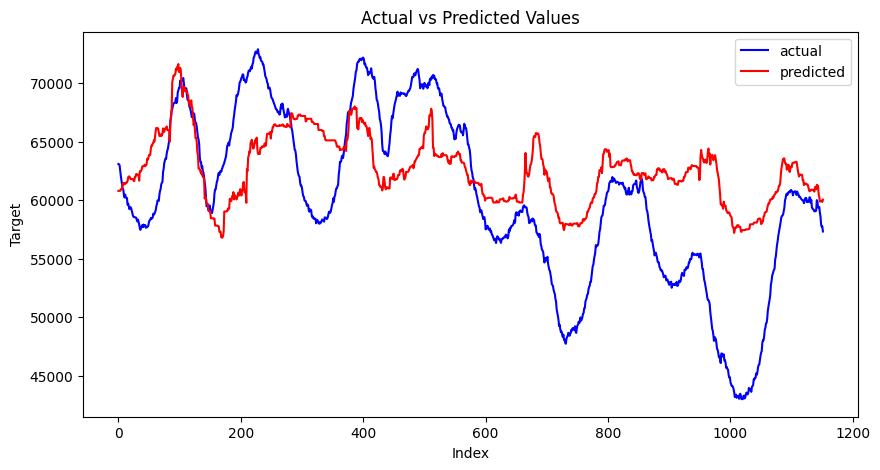

In [51]:
# Now, we can create the plot
plt.figure(figsize=(10,5))

# Plot the actual values
plt.plot(y_test, 'b-', label='actual')

# Plot the predicted values
plt.plot(preds, 'r-', label='predicted')

# Create a legend
plt.legend()

# Add a title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Target')

# Show the plot
plt.show()

# Transformer

In [52]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # 사용할 GPU 장치 번호를 입력합니다. 0은 첫 번째 GPU를 의미합니다.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('현재 디바이스:', device)

현재 디바이스: cuda


In [53]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [54]:
torch.set_default_device('cuda')

In [55]:
torch.__version__

'2.0.1+cu117'

In [56]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)
        self.seq_length = sequence_length

    def __len__(self):
        return self.X.__len__() - self.seq_length #timeDAta에서 seq 길이를 뺀것이 무슨 의미가 있는거지

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_length], self.y[index+self.seq_length])

SEQUENCE_LENGTH = 3  # 이는 문제에 따라 조정해야 합니다.
N_FEATURES = 10


dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dataset = TimeSeriesDataset(X_test, y_test, SEQUENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [57]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, input_dim, output_dim, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_dim, dropout)
        encoder_layers = TransformerEncoderLayer(input_dim, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(input_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        #src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src) 
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [58]:
X_train.shape, y_train.shape

((437095, 10), (437095, 1))

In [59]:
import torch.optim as optim
import numpy as np
import math

# Initialize model, loss, and optimizer
model = TransformerModel(input_dim=10, output_dim=1, nhead=2, nhid=16, nlayers=2).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [60]:
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
        )
        (linear1): Linear(in_features=10, out_features=16, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=16, out_features=10, bias=True)
        (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=10, out_features=1, bias=True)
)


In [61]:
import torchmetrics

In [62]:
def train_model(model, epochs):
    model.train()
    best_val_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(dataloader): # assume train_loader is your DataLoader
            optimizer.zero_grad()
            x = x.transpose(0, 1) # Transform input to suitable shape
            output = model(x)
            loss = loss_fn(output[-1], y) # Compute loss
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

        # Validation
        model.eval()
        val_loss = 0
        val_mape = 0
        for i, (x, y) in enumerate(val_loader): # assume val_loader is your DataLoader
            x = x.transpose(0, 1)
            output = model(x)
            loss = loss_fn(output[-1], y)
            val_loss += loss.item()
            val_mape += torchmetrics.functional.mean_absolute_percentage_error(output[-1], y).item()

        val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}, Val MAPE: {val_mape}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        model.train()

train_model(model, epochs=100)


Epoch 1/100, Train Loss: 24616812.0, Val Loss: 116598860.62007229, Val MAPE: 0.14914149933509627
Epoch 2/100, Train Loss: 29404500.0, Val Loss: 121939740.77750504, Val MAPE: 0.15342942391376327
Epoch 3/100, Train Loss: 29768658.0, Val Loss: 122343935.09593247, Val MAPE: 0.15374692267674195
Epoch 4/100, Train Loss: 29933458.0, Val Loss: 122526740.60685167, Val MAPE: 0.1538901934599283
Epoch 5/100, Train Loss: 30184804.0, Val Loss: 122805612.27076317, Val MAPE: 0.1541083853306606
Epoch 6/100, Train Loss: 30777824.0, Val Loss: 123462953.00929493, Val MAPE: 0.15462099803021206
Early stopping


In [63]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_mape = 0
    with torch.no_grad():  # Don't track gradients
        for i, (x, y) in enumerate(dataloader):
            x = x.transpose(0, 1)
            output = model(x)
            loss = loss_fn(output[-1], y)
            total_loss += loss.item()
            total_mape += torchmetrics.functional.mean_absolute_percentage_error(output[-1], y).item()
    
    avg_loss = total_loss / len(dataloader)
    mape = total_mape / len(dataloader)
    print(f'Average Loss: {avg_loss}, MAPE: {mape}')
    return avg_loss, mape

# Suppose you have a validation or test dataloader, named val_loader or test_loader
evaluate_model(model, test_loader)


Average Loss: 123462953.00929493, MAPE: 0.15462099803021206


(123462953.00929493, 0.15462099803021206)

# LINEAR

In [43]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # 사용할 GPU 장치 번호를 입력합니다. 0은 첫 번째 GPU를 의미합니다.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('현재 디바이스:', device)

현재 디바이스: cuda


In [38]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)
        self.seq_length = sequence_length

    def __len__(self):
        return self.X.__len__() - self.seq_length #timeDAta에서 seq 길이를 뺀것이 무슨 의미가 있는거지

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_length], self.y[index+self.seq_length])

SEQUENCE_LENGTH = 3  # 이는 문제에 따라 조정해야 합니다.
N_FEATURES = 10


dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TimeSeriesDataset(X_test, y_test, SEQUENCE_LENGTH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

# Here, the input size will be the product of SEQUENCE_LENGTH and N_FEATURES
# because we are flattening the sequence into a single vector.
# The output size is set to 1 because we're making a single prediction.

INPUT_SIZE = SEQUENCE_LENGTH * N_FEATURES
OUTPUT_SIZE = 1

model = LinearModel(INPUT_SIZE, OUTPUT_SIZE).to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):  # 100 epochs
    for i, (sequences, labels) in enumerate(dataloader):
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backpropagation and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

print('Finished Training')

Epoch [10/100], Loss: 49353176.0000
Epoch [20/100], Loss: 45966864.0000
Epoch [30/100], Loss: 46295292.0000
Epoch [40/100], Loss: 46576576.0000
Epoch [50/100], Loss: 46607816.0000
Epoch [60/100], Loss: 46493268.0000
Epoch [70/100], Loss: 46313352.0000
Epoch [80/100], Loss: 46113412.0000
Epoch [90/100], Loss: 45916952.0000
Epoch [100/100], Loss: 45733240.0000
Finished Training


In [69]:
import torchmetrics

model.eval()  # Set the model to evaluation mode

total_mape = 0
count = 0

# No need to track gradients for validation, we're not optimizing.
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)

        total_mape += torchmetrics.functional.mean_absolute_percentage_error(outputs, labels).item()
        count += 1

print('test MAPE: {:.4f}'.format(total_mape / count))


test MAPE: 0.1606


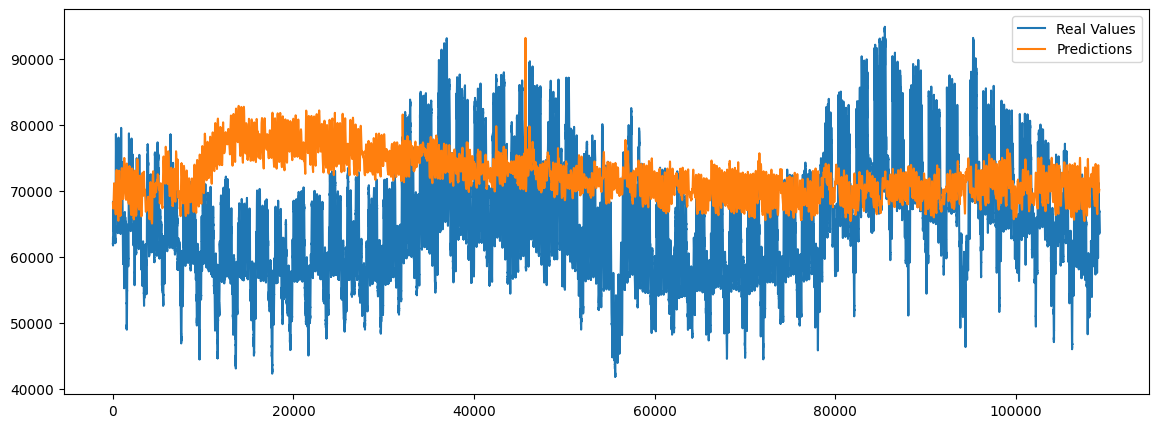

In [70]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Set the model to evaluation mode

predictions = []
real_values = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.view(-1, INPUT_SIZE)  # Flatten the sequence
        outputs = model(sequences)

        predictions.extend(outputs.flatten().tolist())
        real_values.extend(labels.flatten().tolist())

# Convert to numpy arrays for easier manipulation
predictions = np.array(predictions)
real_values = np.array(real_values)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(real_values, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()
